In [2]:
devtools::install_github("clairbarnes/rwwa")
library(rwwa)

library(mice) # for imputation of missing values

filter <- stats::filter # otherwise is overridden by mice::filter

Skipping install of 'rwwa' from a github remote, the SHA1 (689ddfe1) has not changed since last install.
  Use `force = TRUE` to force installation

Loading required package: extRemes

Loading required package: Lmoments

Loading required package: distillery


Attaching package: ‘extRemes’


The following objects are masked from ‘package:stats’:

    qqnorm, qqplot



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind




# Model exploration - precipitation

## Parametric form

In [2]:
# load data
df <- merge(merge(load_ts("ts/panama_pr-wetseason_chirps.dat", col.names = c("year", "chirps")),
                  load_ts("ts/panama_pr-wetseason_mswep.dat", col.names = c("year", "mswep"))),
                  load_ts("ts/panama_pr-wetseason_acp-sp.dat", col.names = c("year", "acp")), all = T)

df <- merge(df, setNames(df[df$year >= 1979, c("year", "acp")], c("year", "acp_sat")), all = T)

In [5]:
# normal distribution is not a bad fit
apply(df[,-1], 2, function(x) c("skewness" = moments::skewness(x, na.rm = T), "kurtosis" = moments::kurtosis(x, na.rm = T)-3, "ks.pval" = ks.test(scale(x), pnorm)$p.value))

chirps     mswep       acp       acp_sat  
skewness  0.2507408  0.03800706 0.4169208 0.3453182
kurtosis -0.1182673 -0.13779223 0.4859299 1.1132165
ks.pval   0.9949046  0.97490654 0.6350088 0.7634679

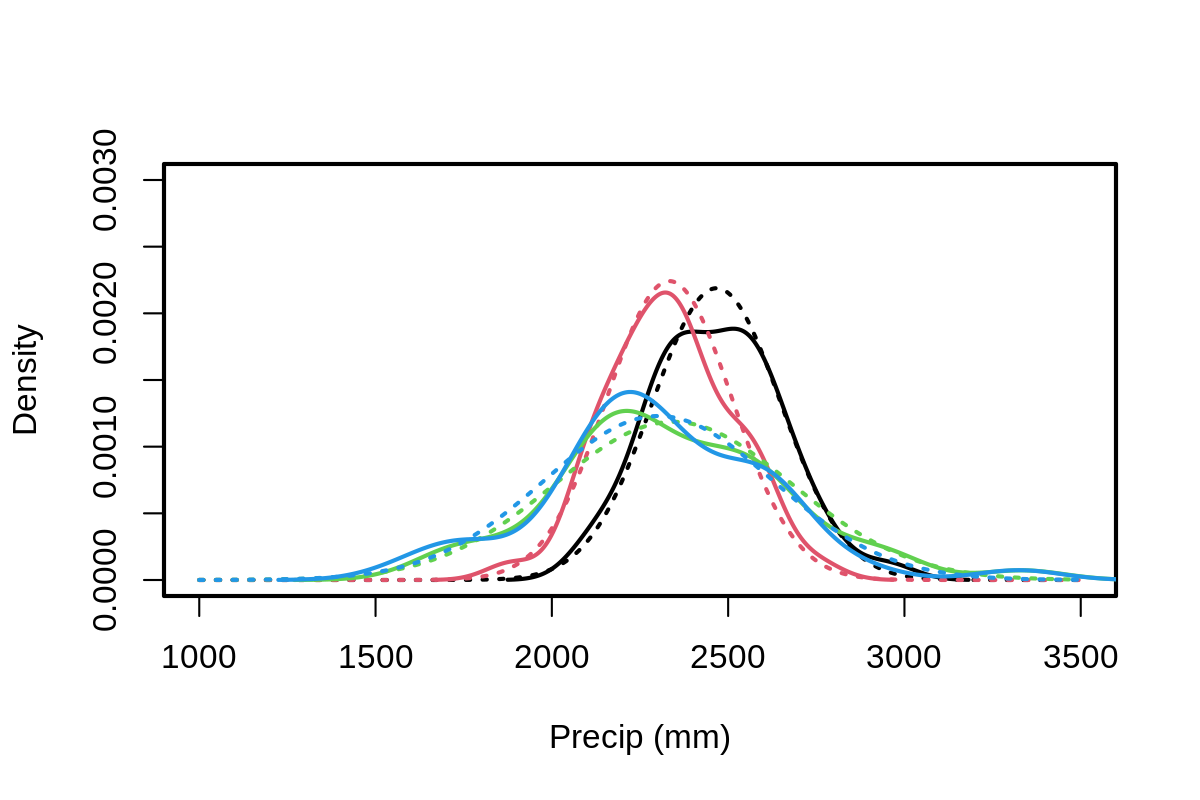

In [6]:
prep_window(c(1,1), h = 4, w = 6, lwd = 2)
x <- 1000:3500

plot(1, type = "n", xlim = range(x), ylim = c(0,0.003), xlab = "Precip (mm)", ylab = "Density")
for(i in 1:4) {
    lines(density(df[,i+1], na.rm = T), col = i)
    lines(x, dnorm(x, mean(df[,i+1], na.rm = T), sd(df[,i+1], na.rm = T)), lty = 3, col = i)
}

## Fit models

In [120]:
# load & compile data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

df_chirps <- merge(merge(gmst, nino), load_ts("ts_all/panama_pr-wetseason_chirps.dat", col.names = c("year", "pr")))
df_mswep <- merge(merge(gmst, nino), load_ts("ts_all/panama_pr-wetseason_mswep.dat", col.names = c("year", "pr")))
df_acp_sp <- merge(merge(gmst, nino), load_ts("ts_all/panama_pr-wetseason_acp-sp.dat", col.names = c("year", "pr")))
df_acp_long <- merge(merge(gmst, nino), load_ts("ts_all/panama_pr-wetseason_acp-long.dat", col.names = c("year", "pr")))
df_acp_mid <- merge(merge(gmst, nino), load_ts("ts_all/panama_pr-wetseason_acp-mid.dat", col.names = c("year", "pr")))
df_acp_sat <- merge(merge(gmst, nino), load_ts("ts_all/panama_pr-wetseason_acp-sat.dat", col.names = c("year", "pr")))

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

### Mixture model formulation
The density of the long time series looks a lot like a mixture model - would it be better to treat Nino/Nina as factor variable?

In [140]:
df <- df_acp_long
df$nino_type <- as.factor(c(2,1,3)[findInterval(df$nino, c(-Inf, -0.7, 0.7, Inf))] )

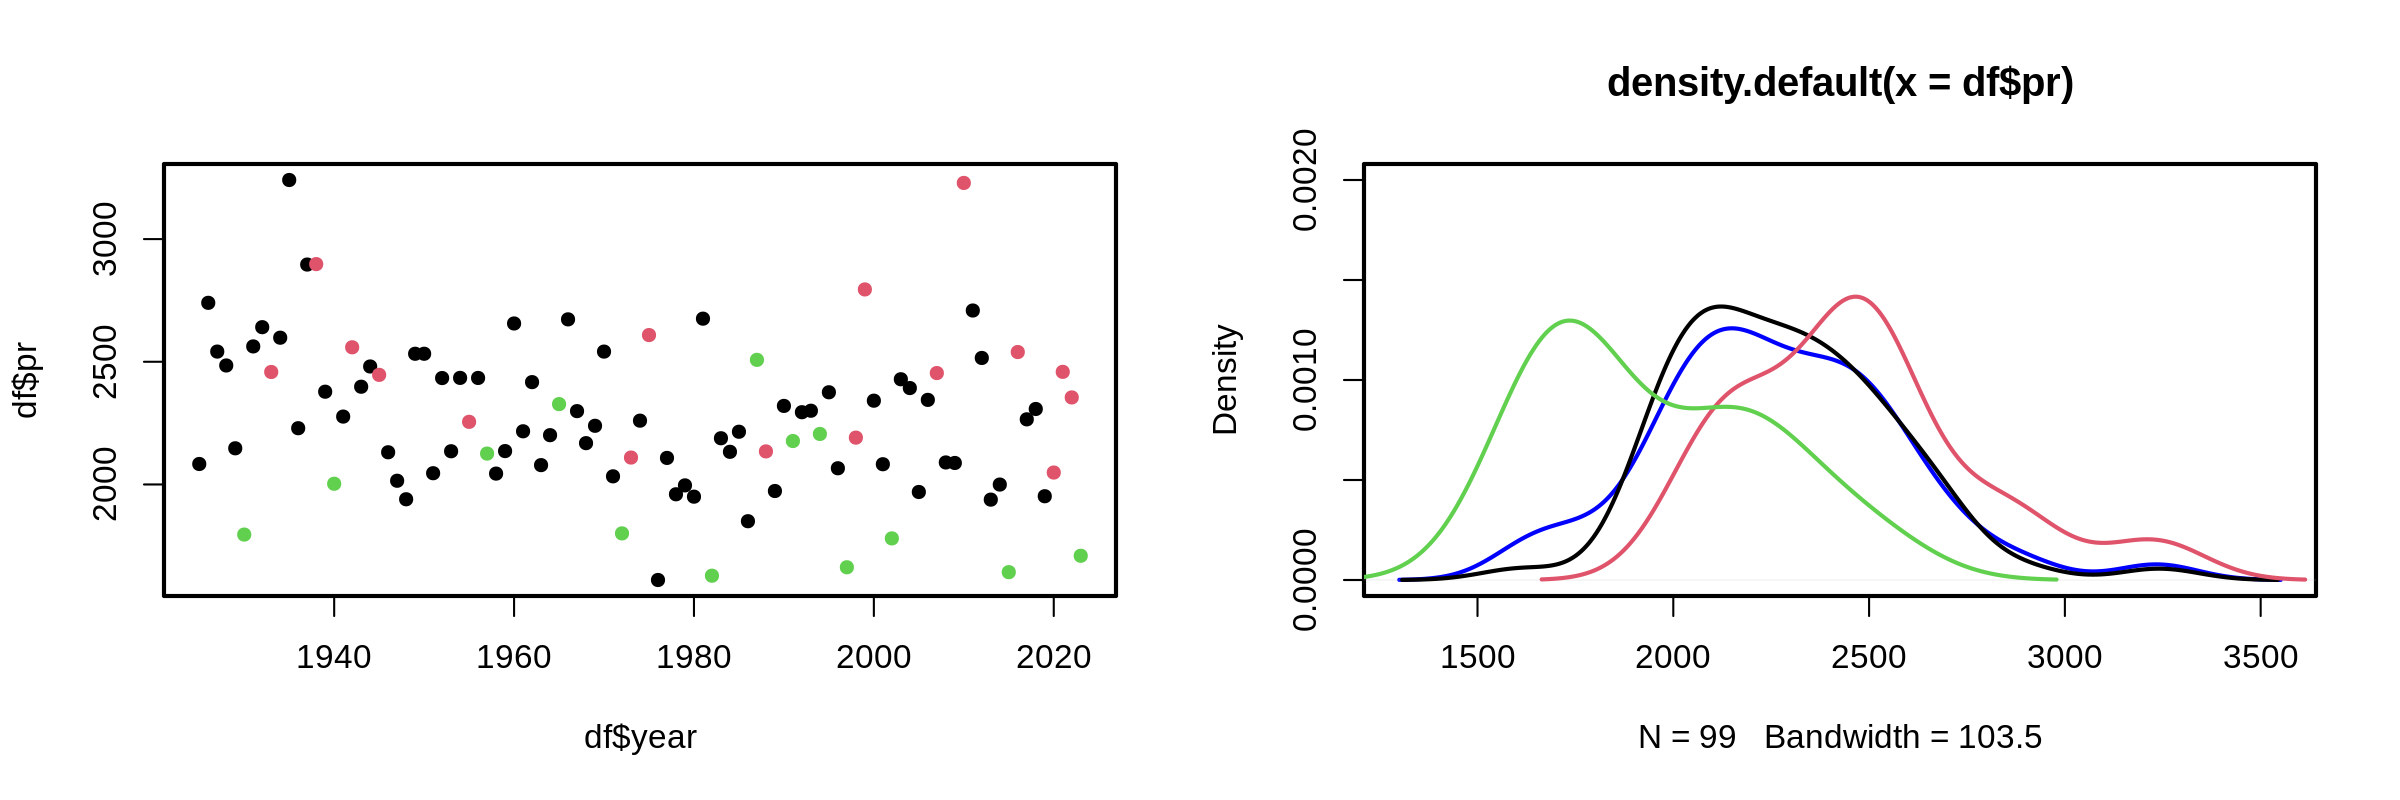

In [141]:
prep_window(c(1,2), h = 4, w = 6, lwd = 2)

plot(df$year, df$pr, col = df$nino_type, pch = 20)

plot(density(df$pr), col = "blue", lwd = 2, ylim = c(0,0.002))
for(i in 1:3) lines(density(df$pr[df$nino_type == i]), col = i)

In [142]:
lm_factor <- lm(pr ~ gmst + nino_type, df)
lm_cts <- lm(pr ~ gmst + nino, df)

lmtest::coxtest(lm_factor, lm_cts)

Estimate  Std. Error z value    Pr(>|z|)   
fitted(M1) ~ M2 -5.680844 2.162620   -2.6268338 0.008618342
fitted(M2) ~ M1 -2.088203 2.339465   -0.8925984 0.372072262

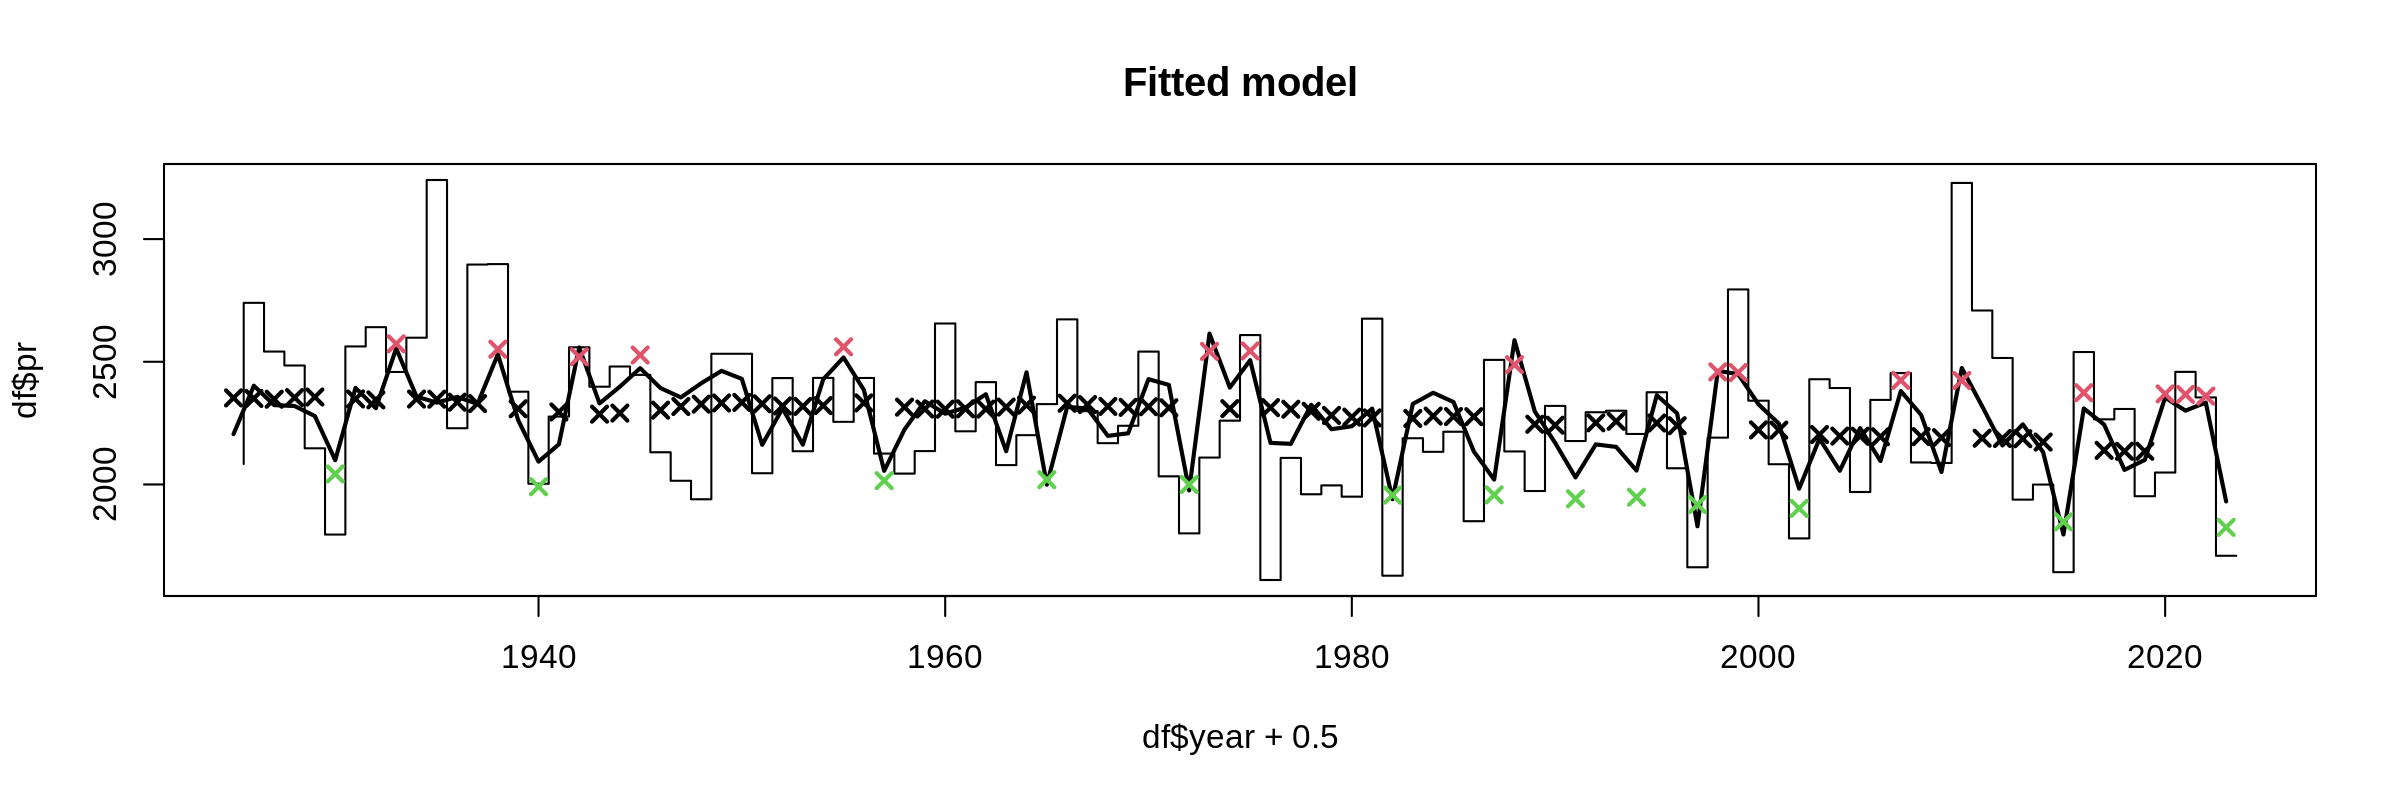

In [144]:
plot(df$year+0.5, df$pr, type = "S", main = "Fitted model")
lines(df$year, fitted(lm_cts), lwd = 2)
points(df$year, fitted(lm_factor), pch = 4, lwd = 2, col = df$nino_type)

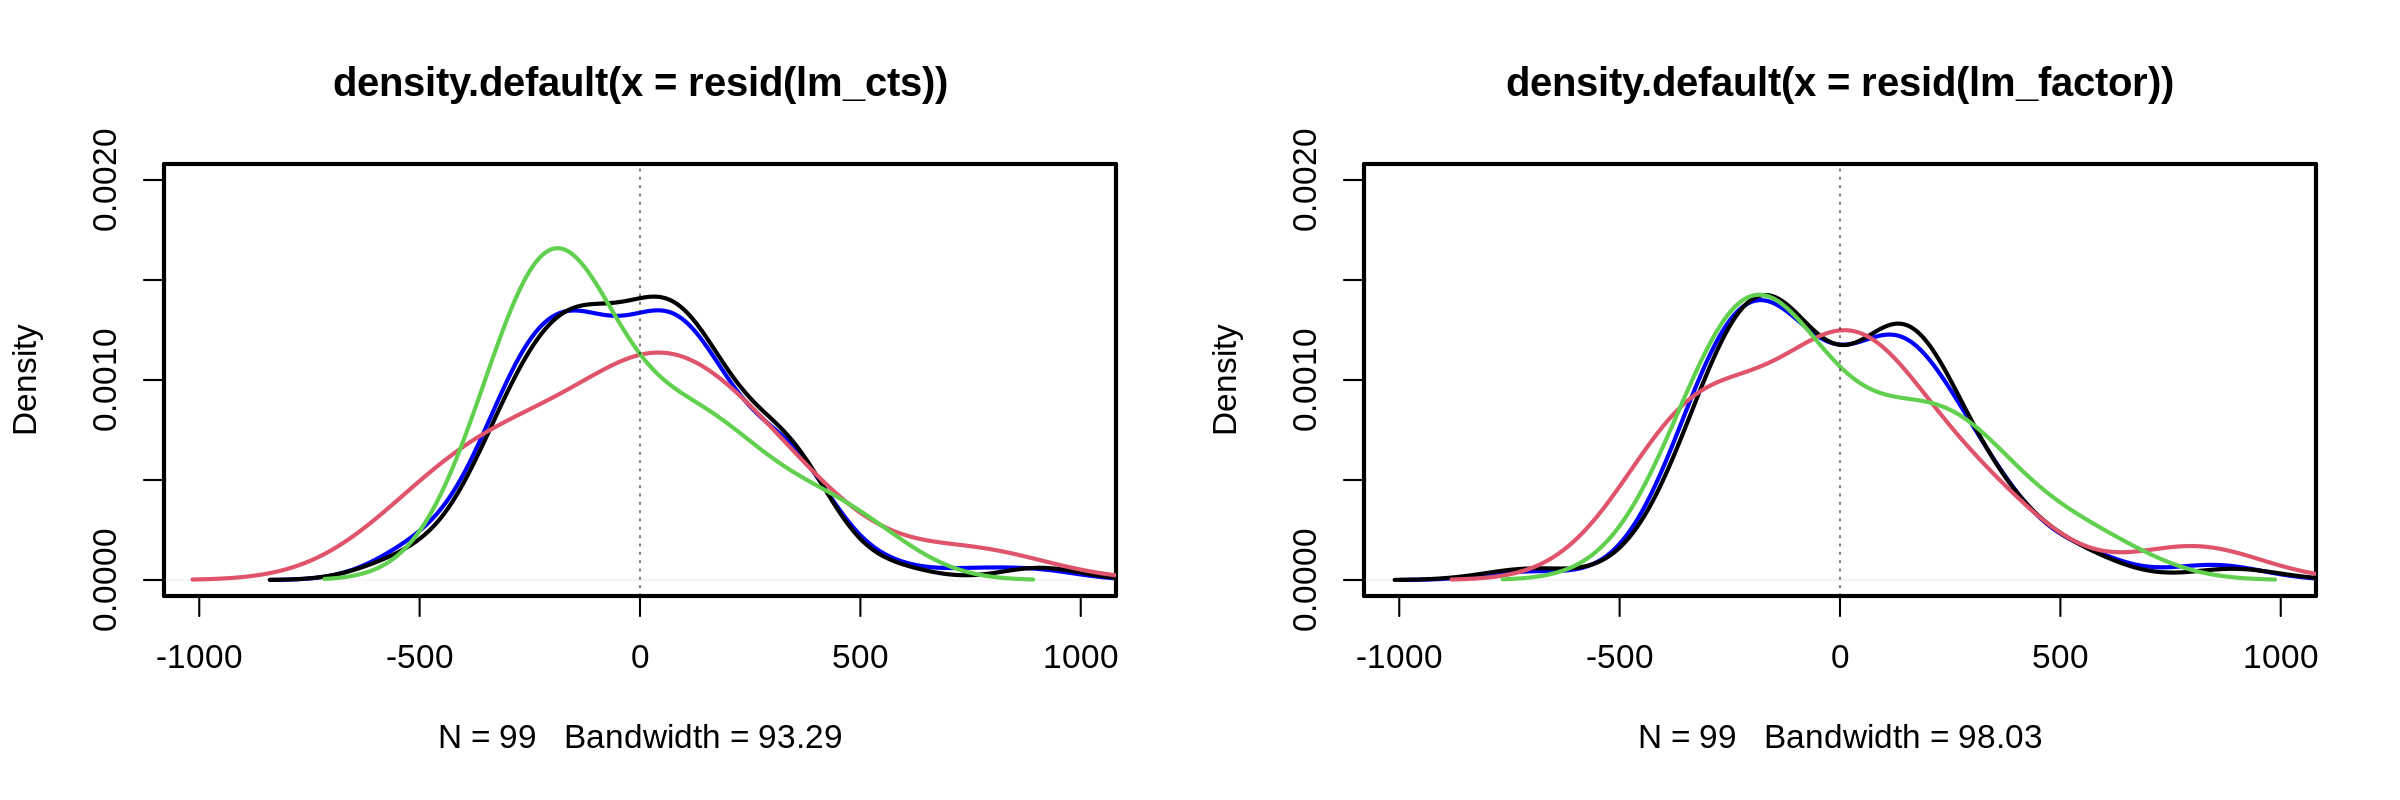

In [145]:
prep_window(c(1,2), h = 4, w = 6, lwd = 2)

plot(density(resid(lm_cts)), col = "blue", ylim = c(0,0.002), xlim = c(-1000,1000))
for(i in 1:3) lines(density(resid(lm_cts)[df$nino_type == i]), col = i)
abline(v = 0, lwd = 0.5, lty = 3)

plot(density(resid(lm_factor)), col = "blue", ylim = c(0,0.002), xlim = c(-1000,1000))
for(i in 1:3) lines(density(resid(lm_factor)[df$nino_type == i]), col = i)
abline(v = 0, lwd = 0.5, lty = 3)

### Linear model formulation

In [121]:
models <- list("CHIRPS" = fit_ns("norm", "fixeddisp", df_chirps, "pr", c("gmst", "nino"), lower = T),
               "MSWEP" = fit_ns("norm", "fixeddisp", df_mswep, "pr", c("gmst", "nino"), lower = T),
               "ACP sat" = fit_ns("norm", "fixeddisp", df_acp_sat, "pr", c("gmst", "nino"), lower = T),
               "ACP mid" = fit_ns("norm", "fixeddisp", df_acp_mid, "pr", c("gmst", "nino"), lower = T),
               "ACP long" = fit_ns("norm", "fixeddisp", df_acp_long, "pr", c("gmst", "nino"), lower = T),
               "ACP all" = fit_ns("norm", "fixeddisp", df_acp_sp, "pr", c("gmst", "nino"), lower = T))

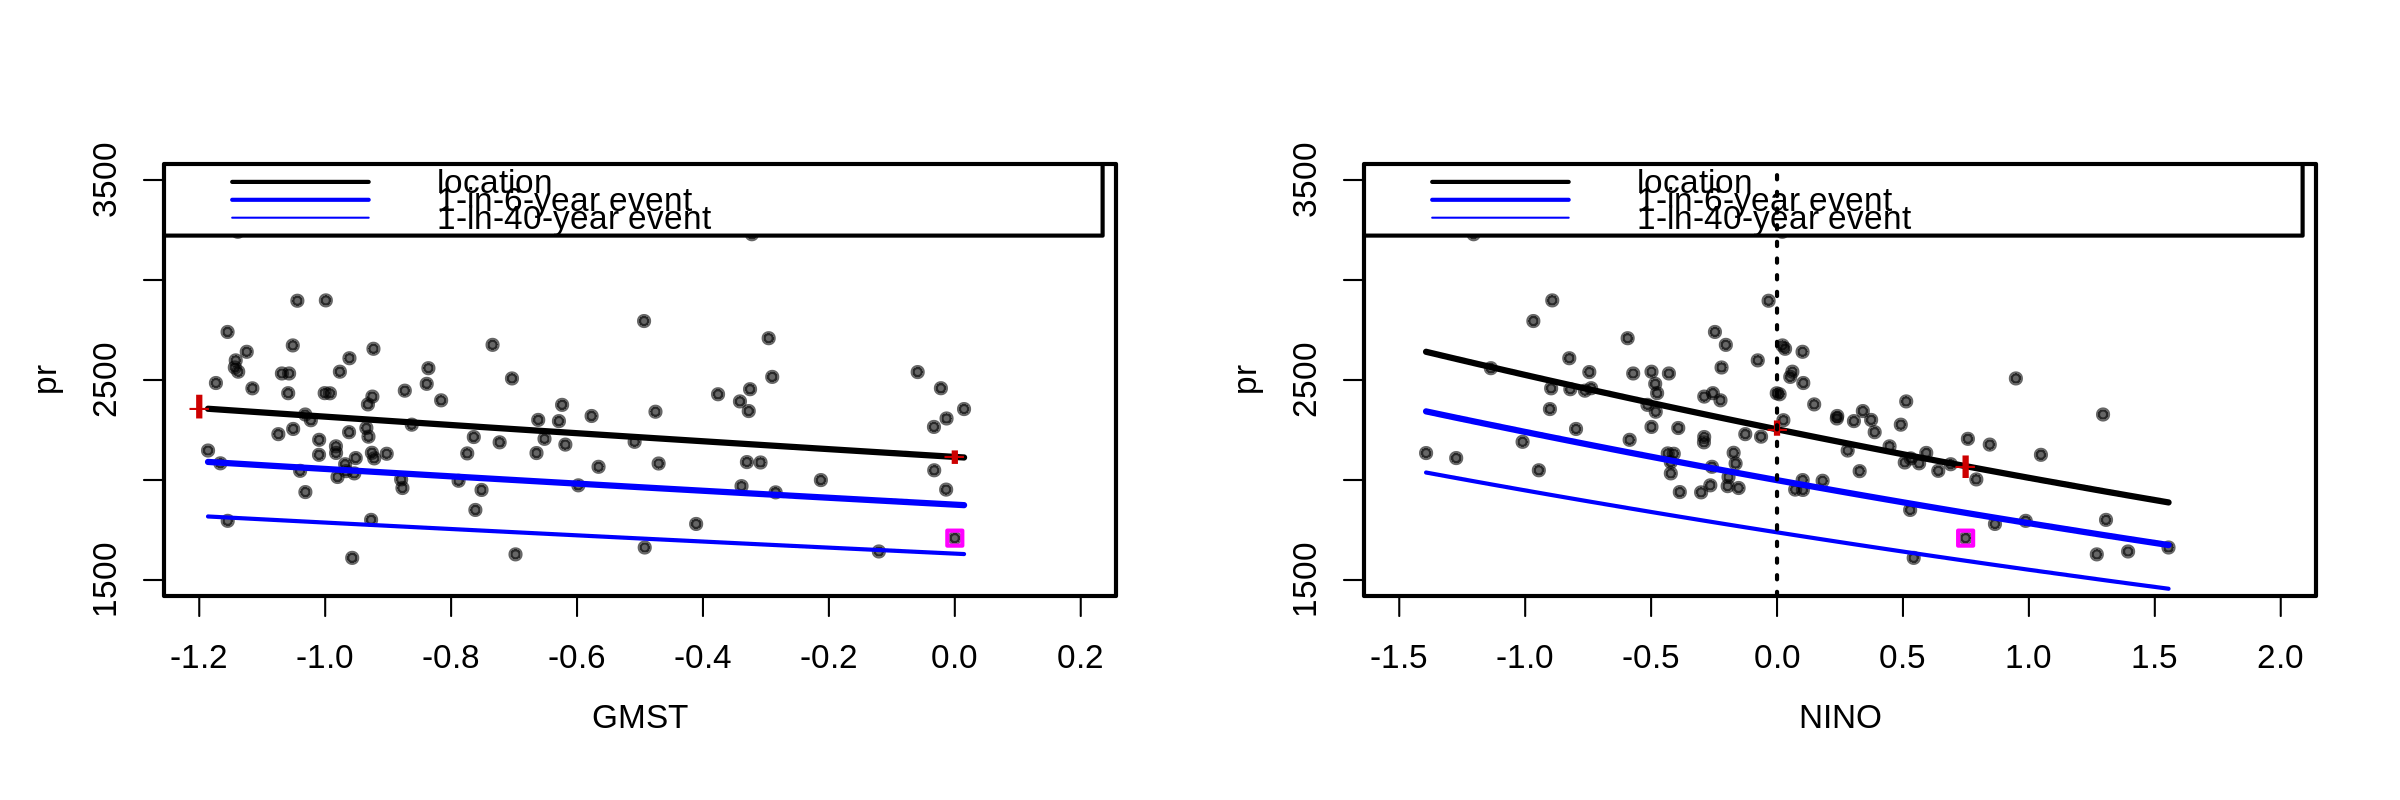

In [147]:
prep_window(c(1,2), h = 4, w = 6, lwd = 2)
plot_covtrend(models[["ACP long"]], "gmst", plot_cov = data.frame(gmst = df_acp_long$gmst, nino = mean(df_acp_long$nino)), 
              ci_cov = data.frame(gmst = gmst$gmst[gmst$year == 2023] + c(0,-1.2), nino = mean(df_acp_long$nino)), nsamp = 10)
plot_covtrend(models[["ACP long"]], "nino", plot_cov = data.frame(gmst = mean(df_acp_long$gmst), nino = (df_acp_long$nino)), 
              ci_cov = data.frame(gmst = mean(df_acp_long$gmst), nino = c(nino$nino[nino$year == 2023], 0)), nsamp = 10)
abline(v = 0, lty = 3)

## Check residuals

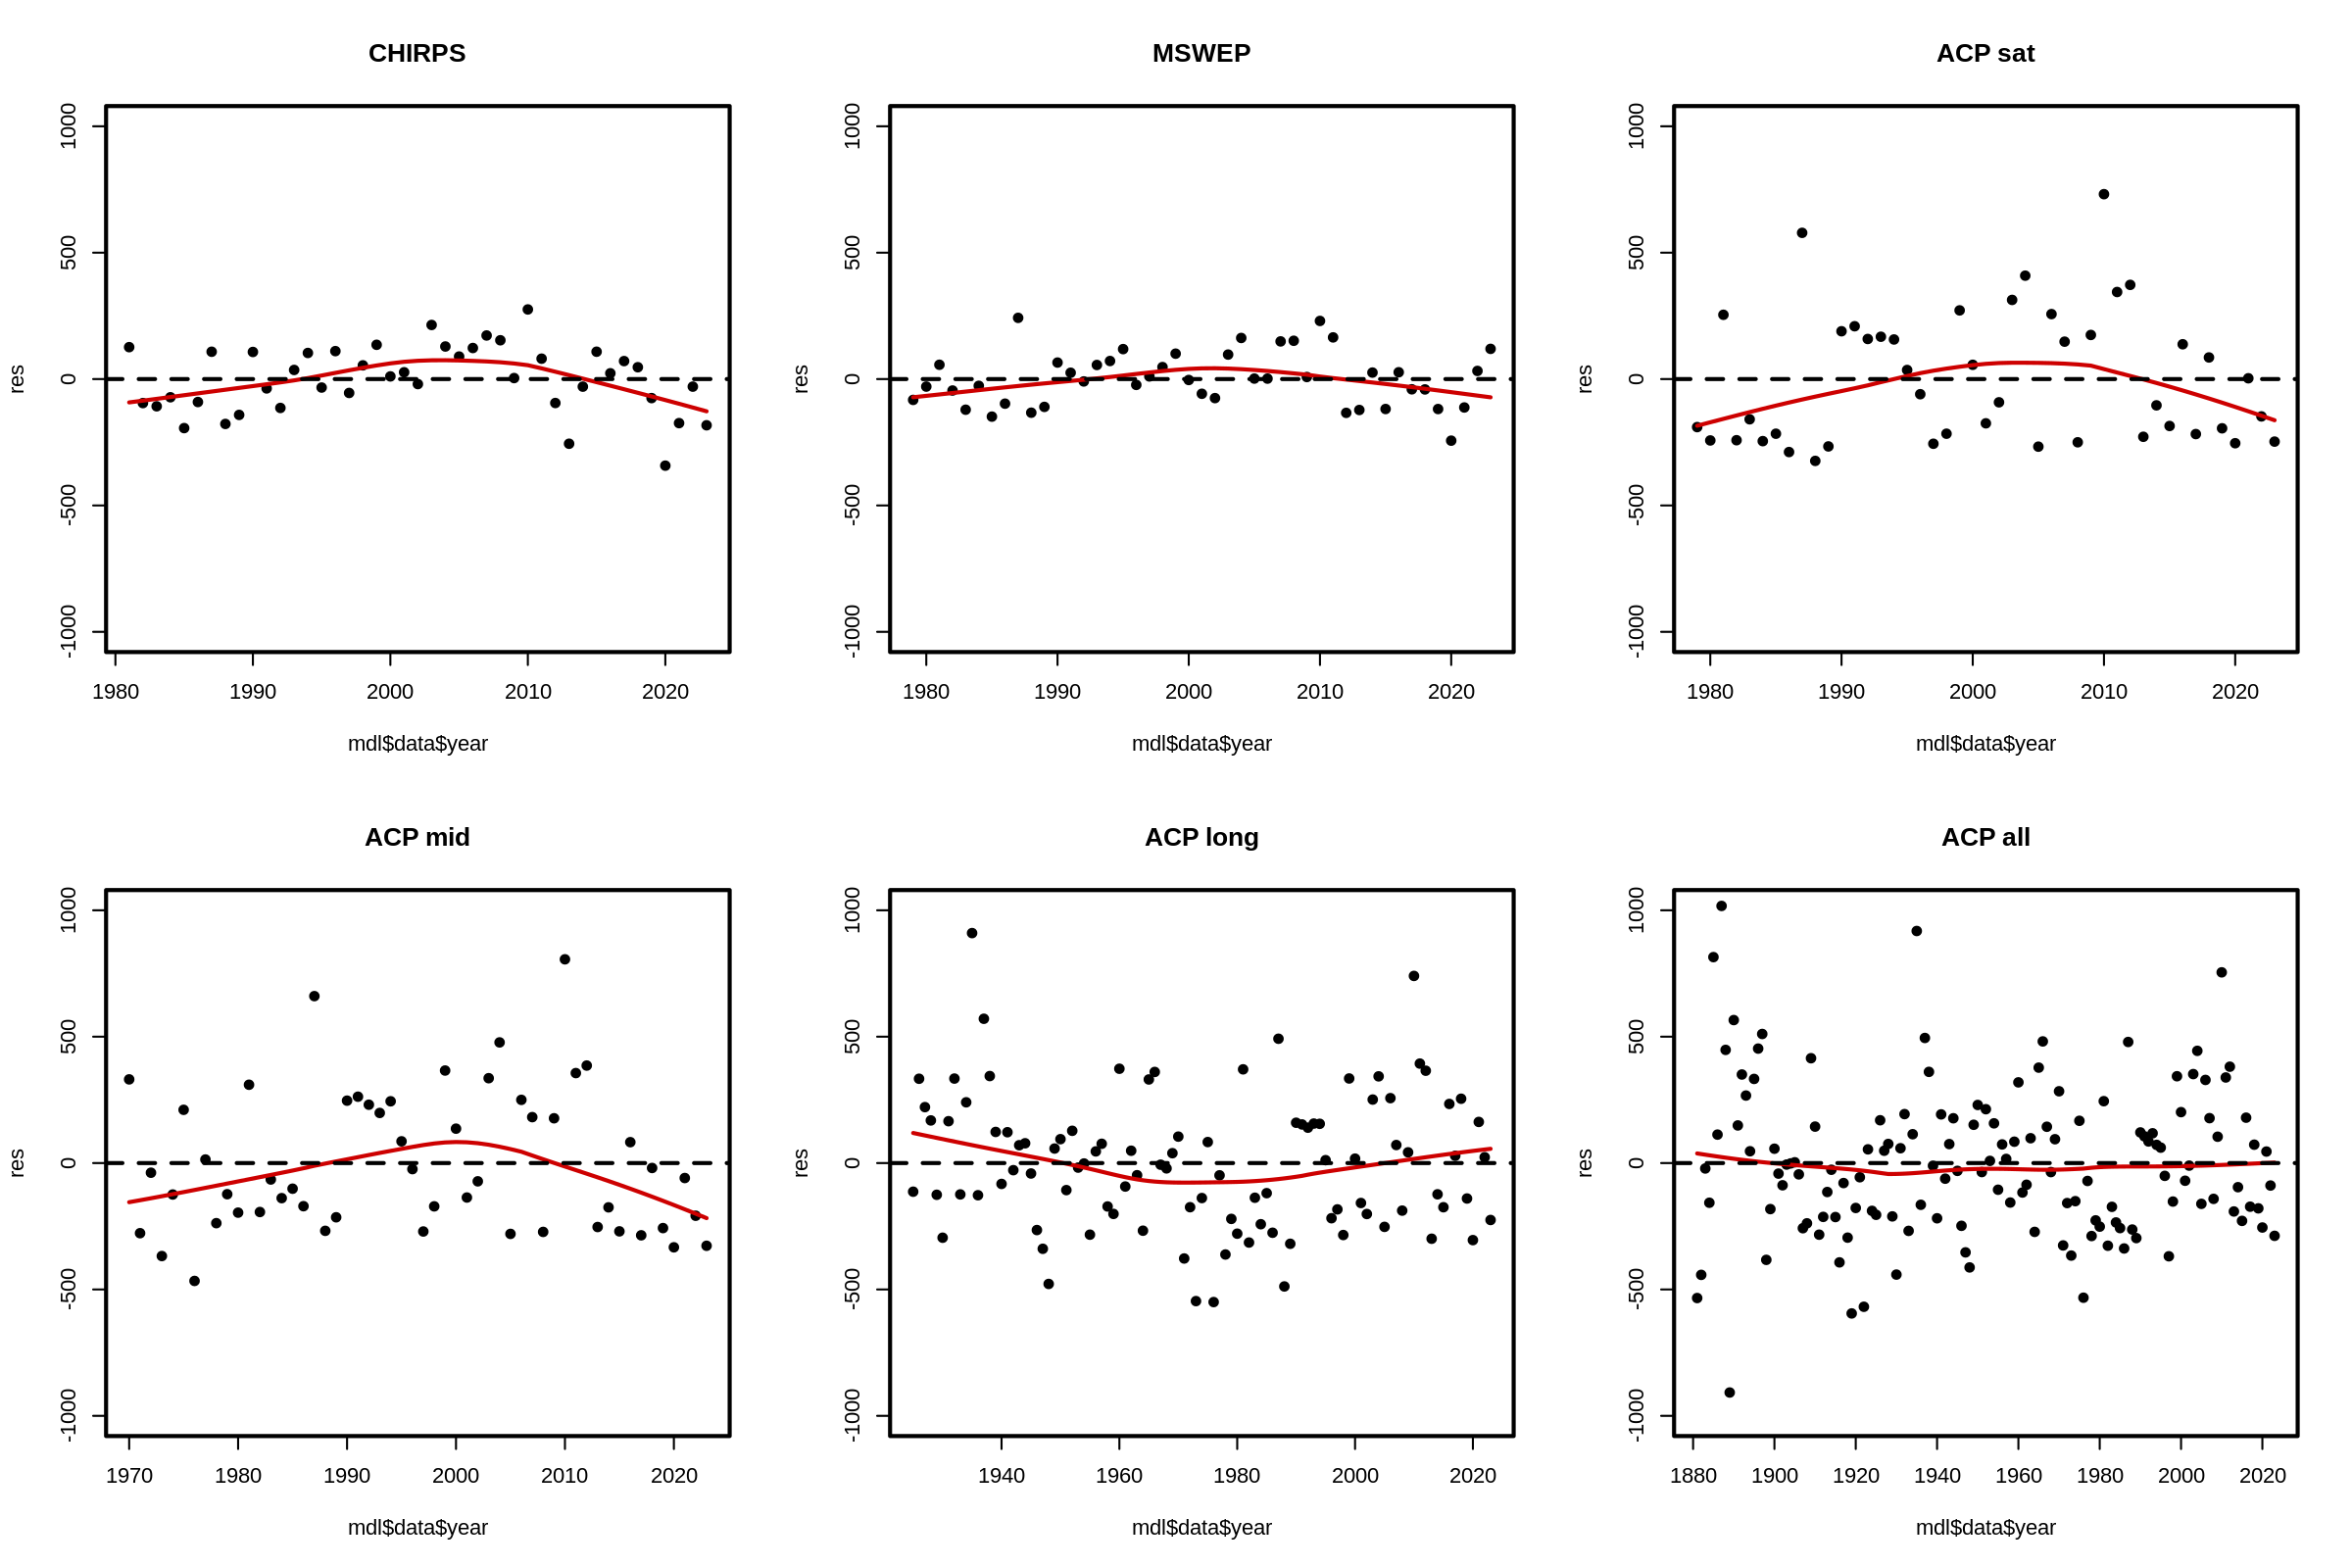

In [148]:
prep_window(c(2,3), h = 4, w = 4, lwd = 2)

for (i in 1:length(models)) {
    mdl <- models[[i]]
    res <- mdl$x - ns_pars(mdl)$loc
    plot(mdl$data$year, res, main = names(models)[i], ylim = c(-1000,1000))
    lines(lowess(mdl$data$year, res), col = "red3")
    abline(h = 0, lty = 2)
}

## Return level plots

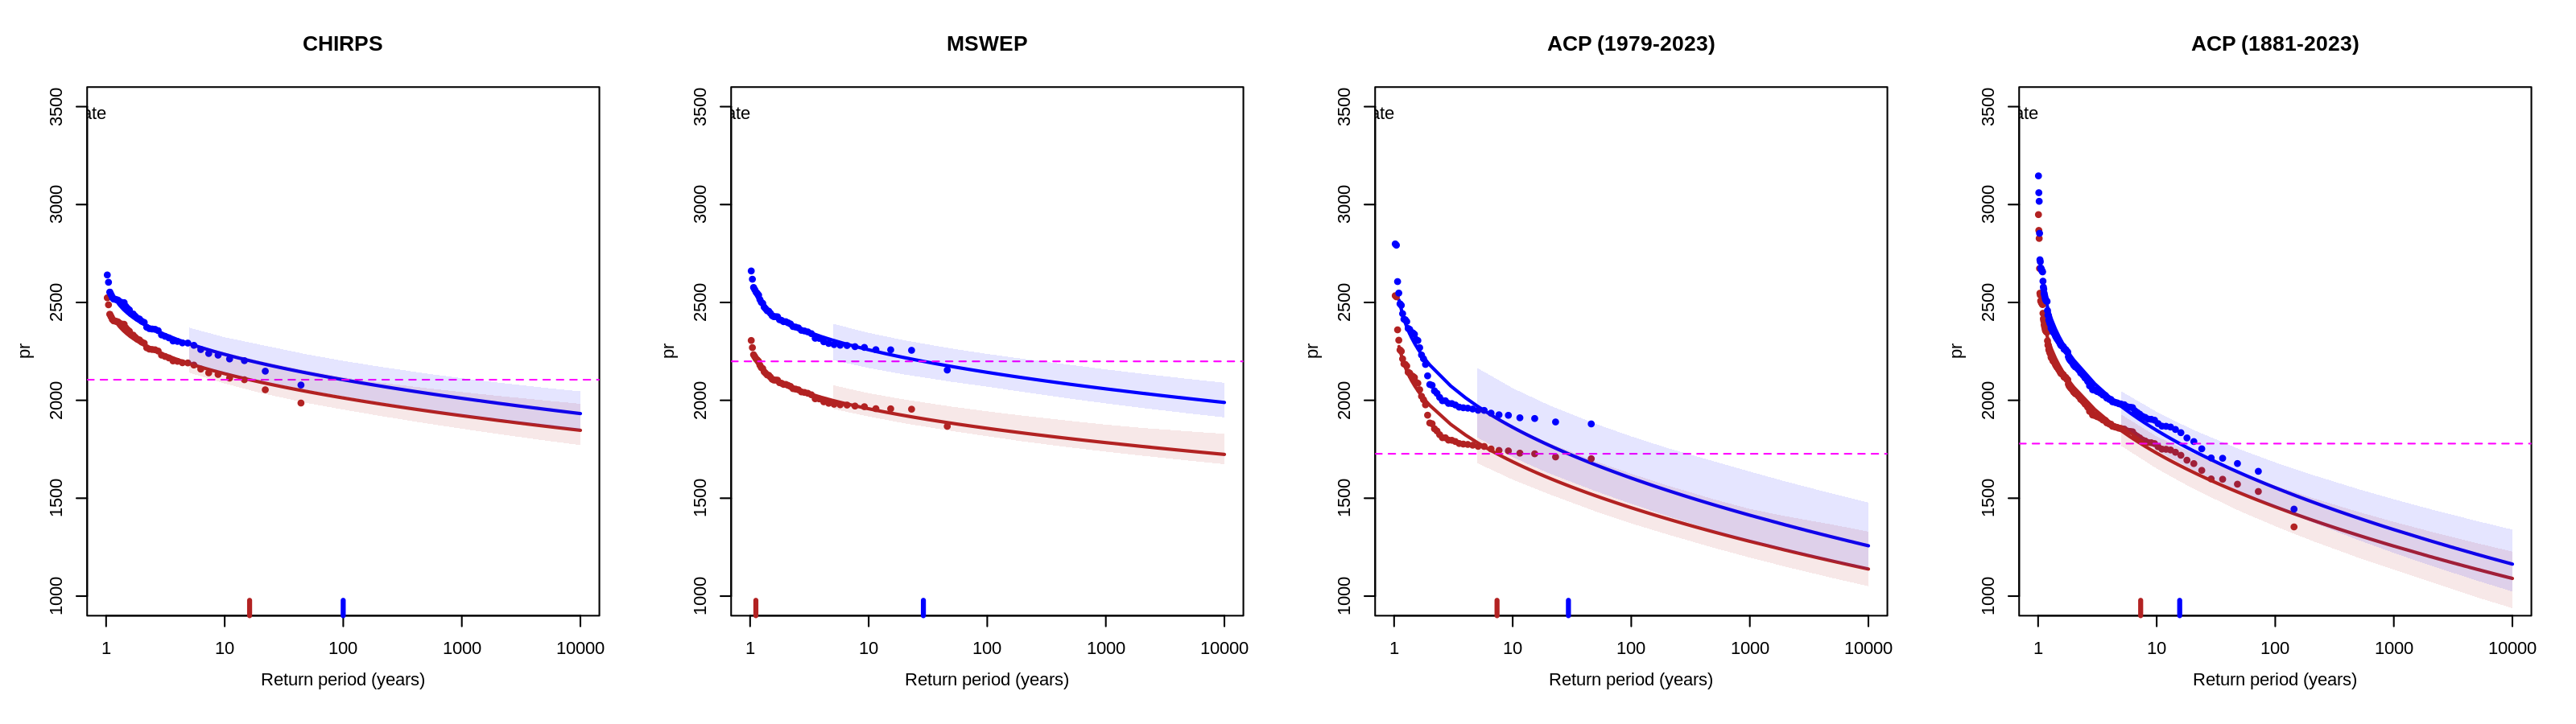

In [161]:
prep_window(c(1,4), h = 4.5)
ns = 50
ylim <- c(1000,3500) 
plot_returnlevels(models[["CHIRPS"]], cov_f = cov_2023, cov_cf = cov_cf["hist",,drop=F], main = "CHIRPS", nsamp = ns, ylim = ylim)
plot_returnlevels(models[["MSWEP"]], cov_f = cov_2023, cov_cf = cov_cf["hist",,drop=F], main = "MSWEP", nsamp = ns, ylim = ylim)
plot_returnlevels(models[["ACP sat"]], cov_f = cov_2023, cov_cf = cov_cf["hist",,drop=F], main = "ACP (1979-2023)", nsamp = ns, ylim = ylim)
plot_returnlevels(models[["ACP all"]], cov_f = cov_2023, cov_cf = cov_cf["hist",,drop=F], main = "ACP (1881-2023)", nsamp = ns, ylim = ylim)

## Parameter estimates

In [162]:
# what do the model results look like?
res_chirps <- boot_ci(models[["CHIRPS"]], cov_f = cov_2023, cov_cf = cov_cf)
res_acp <- boot_ci(models[["ACP all"]], cov_f = cov_2023, cov_cf = cov_cf)
res_acp_sat <- boot_ci(models[["ACP sat"]], cov_f = cov_2023, cov_cf = cov_cf)
res_mswep <- boot_ci(models[["MSWEP"]], cov_f = cov_2023, cov_cf = cov_cf)

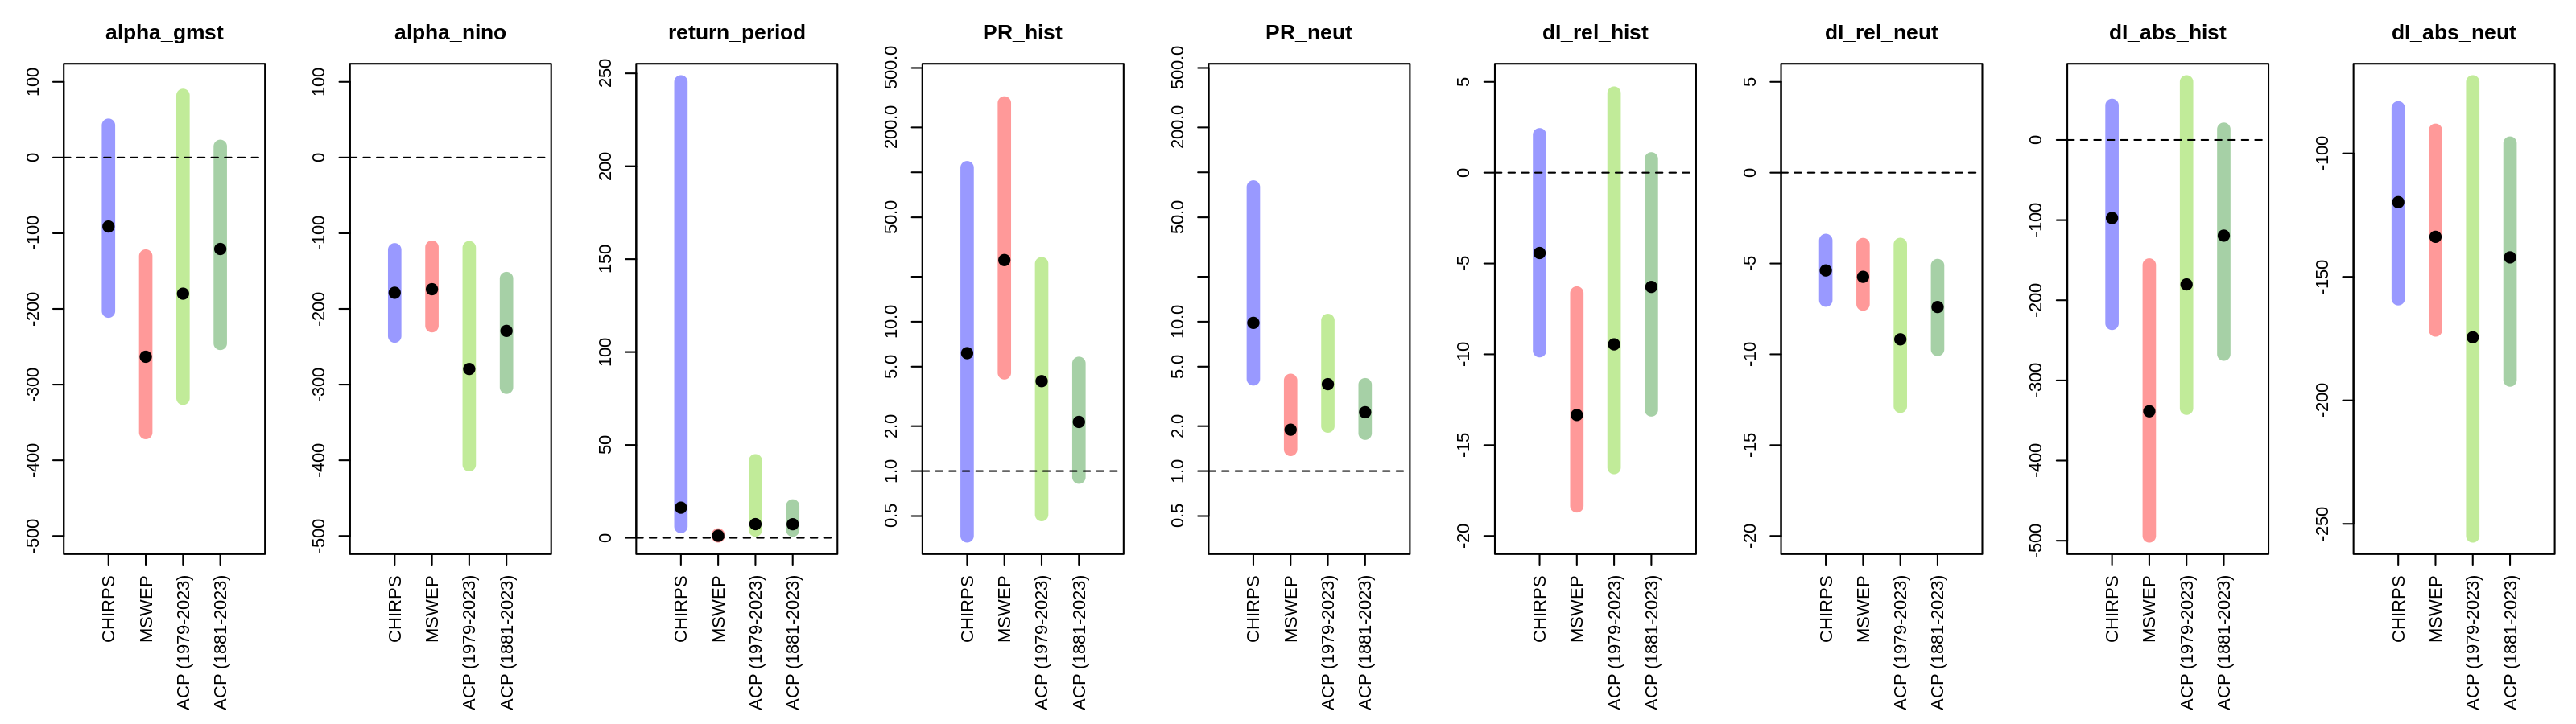

In [163]:
all_res <- abind::abind("CHIRPS" = res_chirps, "MSWEP" = res_mswep, "ACP (1979-2023)" = res_acp_sat, "ACP (1881-2023)" = res_acp, along = 0)

plot_pars <- c("alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_rel_hist", "dI_rel_neut", "dI_abs_hist", "dI_abs_neut")
prep_window(c(1,4), h = 4.5); par(mar = c(8,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- all_res[,r,]
        ylim = range(res, na.rm = T)
        
        n <- nrow(res)
        if(grepl("alpha", r)) {
            ylim = range(pretty(all_res[,grepl("alpha", colnames(all_res)),]))
        } 
        
        if(grepl("dI_rel", r)) {
            ylim = range(pretty(all_res[,grepl("dI_rel", colnames(all_res)),]))
        } 
        
        if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(pretty(log(all_res[,grepl("PR", colnames(all_res)),]))))
        } else {
            h = 0
            logaxs = ""
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = 1:n, labels = rownames(res), las = 2)
        segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 8, col = adjustcolor(c("blue", "red", "chartreuse3", "forestgreen"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }

## Additional modes of variability

### Does PDO explain remaining systematic variability?

Warning message in readLines(file, n = thisblock):
“incomplete final line found on 'data/pdo_ersst.txt'”


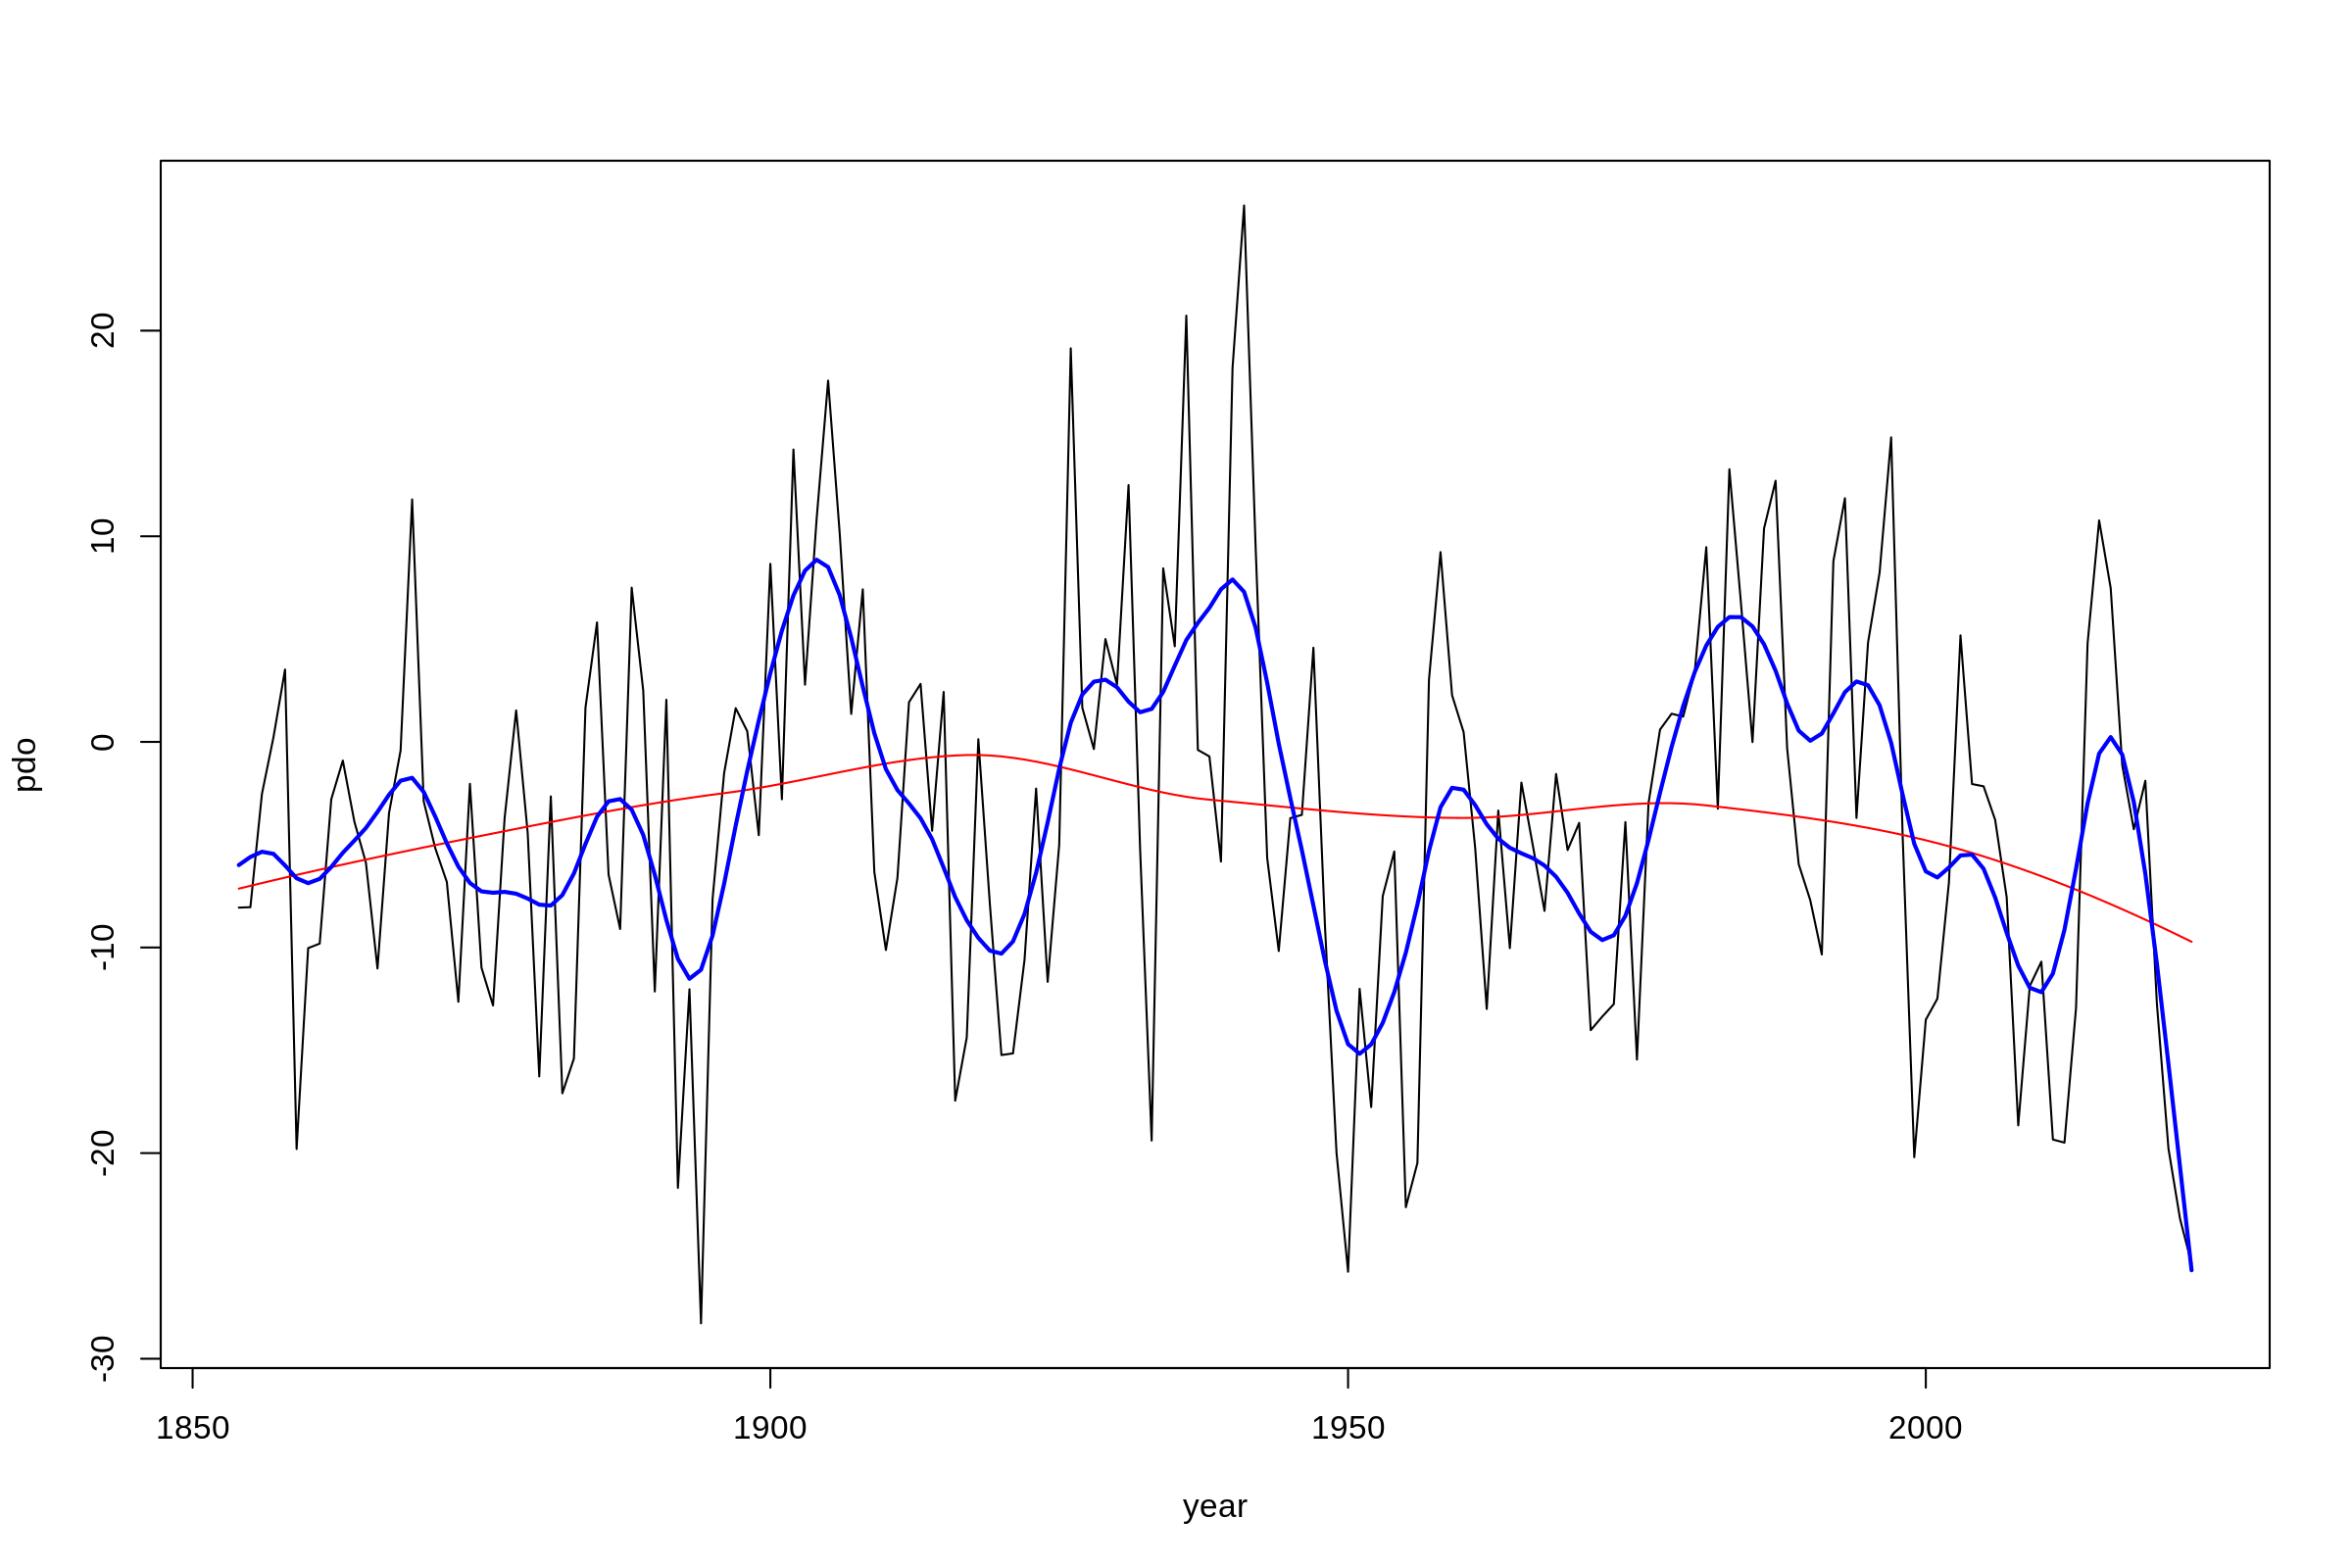

In [149]:
pdo <- rowSums(read.fwf("data/pdo_ersst.txt", skip = 2, widths = c(5, rep(6, 11)), row.names = "V1", na.strings = 99.99))
pdo <- data.frame(year = names(pdo), pdo = pdo)
pdo <- pdo[pdo$year < 2024,,drop = F]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(pdo, type = "l")
lines(pdo$year, fitted(loess(pdo ~ year, pdo), degree = 1, span = 0.25), col = "red")

# add smoothed version as alternative covariate
pdo$pdo_sm <- fitted(smooth.spline(pdo$year, pdo$pdo, df = 30))
lines(pdo$year, pdo$pdo_sm, col = "blue", lwd = 2)

In [151]:
# load & compile data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

df <- merge(merge(merge(gmst, nino), load_ts("ts_all/panama_pr-wetseason_acp-sat.dat", col.names = c("year", "pr"))), pdo)

cov_2023 <- df[df$year == 2023,c("gmst", "nino", "pdo", "pdo_sm")]
cov_cf <- rbind("hist" = cov_2023 - c(1.2,0,0,0), "neut" = cov_2023 - c(0,cov_2023$nino,0,0))

In [152]:
models <- list("gmst+nino" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T),
               "gmst+pdo" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "pdo"), lower = T),
               "gmst+nino+pdo" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino", "pdo"), lower = T),
               "gmst+nino+pdo_sm" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino", "pdo_sm"), lower = T))

In [153]:
# no evidence that fit is improved
round(sapply(models, aic), 2)

gmst+nino         gmst+pdo    gmst+nino+pdo gmst+nino+pdo_sm 
          635.30           653.59           637.30           637.83

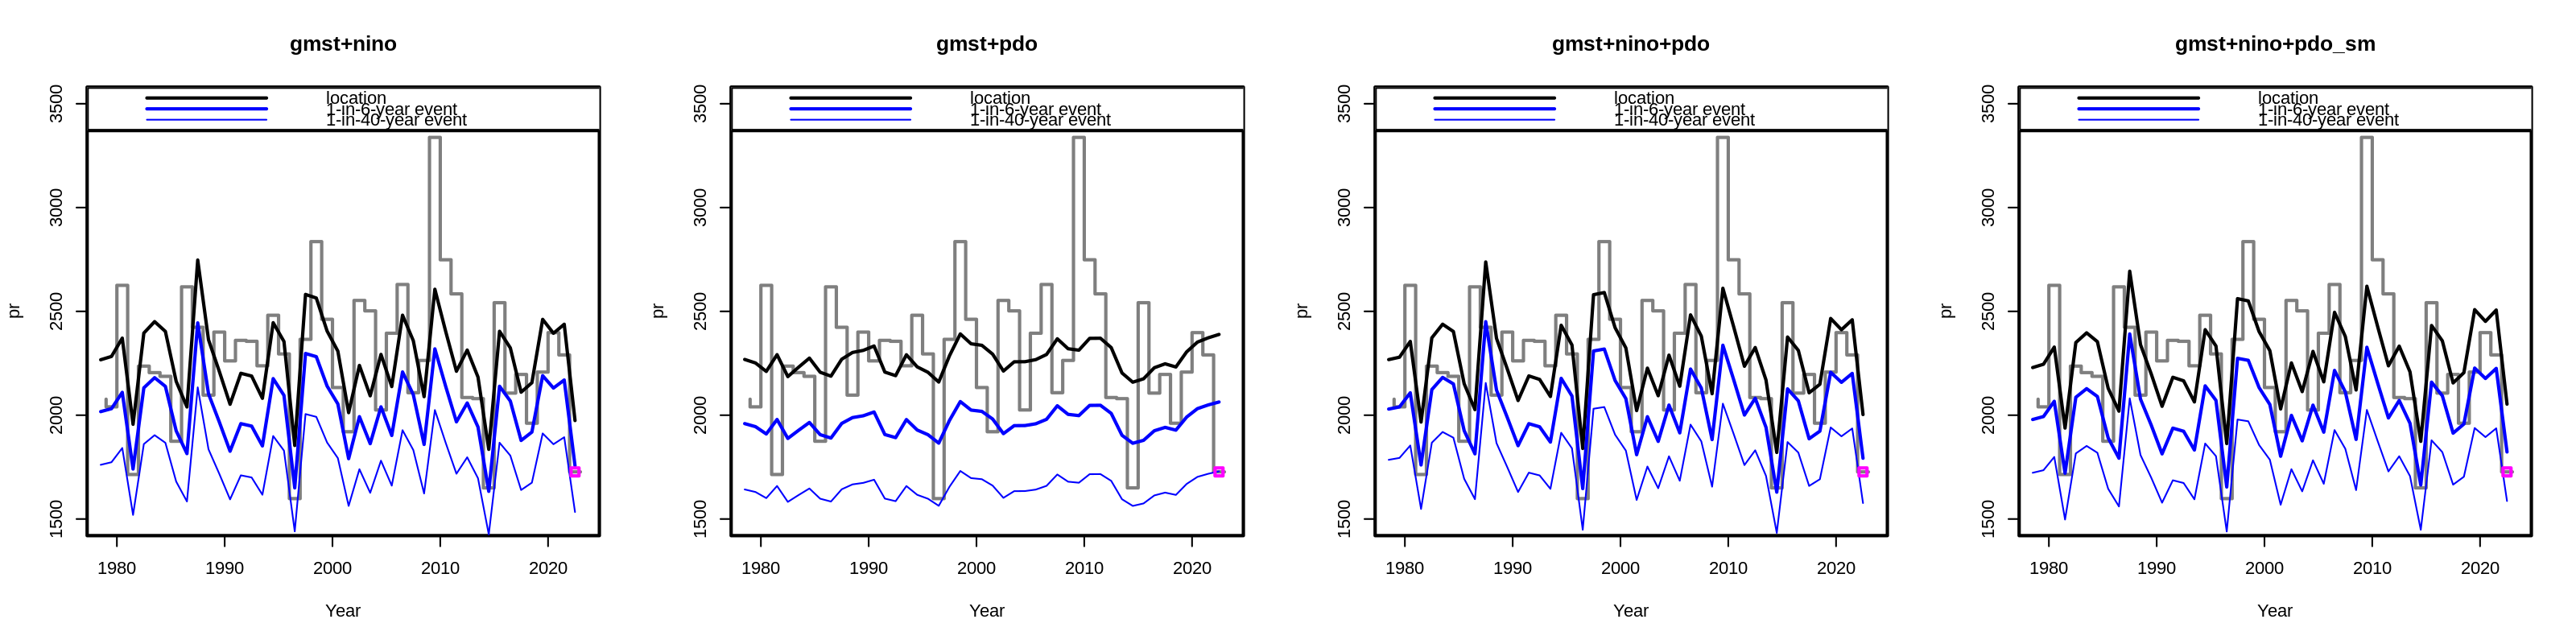

In [154]:
prep_window(c(1,4), h = 4, w = 4, lwd = 2)

for (i in 1:length(models)) {
    mdl <- models[[i]]
    plot_trend(mdl, main = names(models)[i])
}

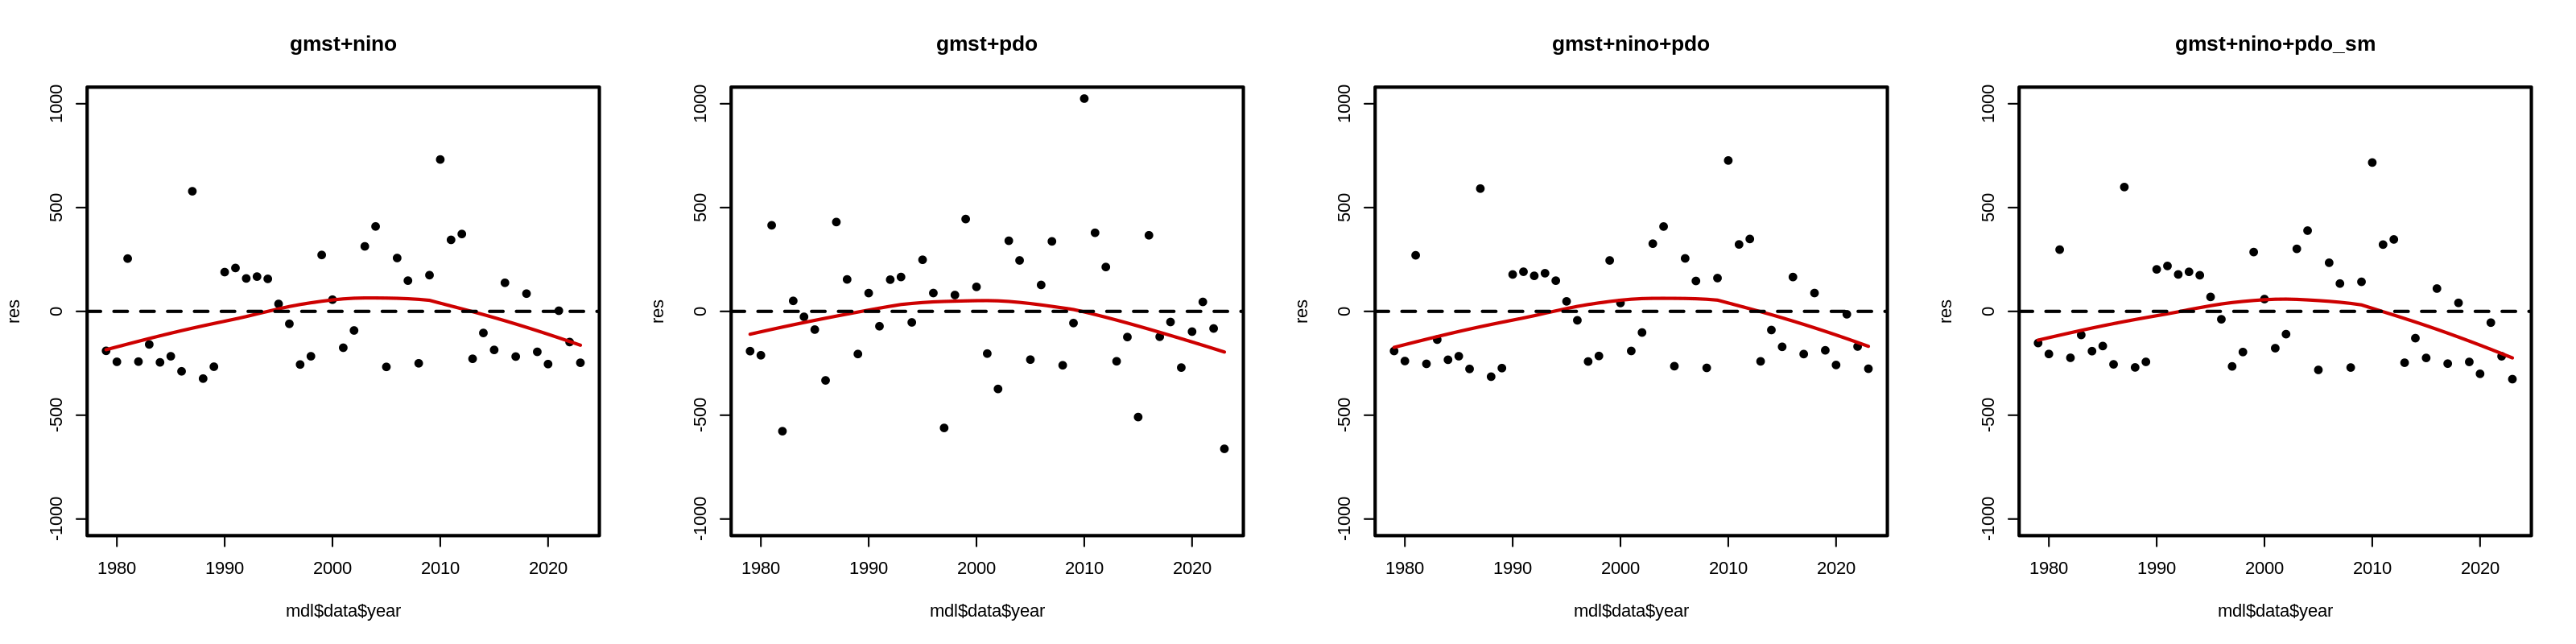

In [155]:
prep_window(c(1,4), h = 4, w = 4, lwd = 2)

for (i in 1:length(models)) {
    mdl <- models[[i]]
    res <- mdl$x - ns_pars(mdl)$loc
    plot(mdl$data$year, res, main = names(models)[i], ylim = c(-1000,1000))
    lines(lowess(mdl$data$year, res), col = "red3")
    abline(h = 0, lty = 2)
}

In [156]:
all_res <- sapply(models, function(mdl) boot_ci(mdl, cov_f = cov_2023, cov_cf = cov_cf, nsamp = 100), simplify = F)

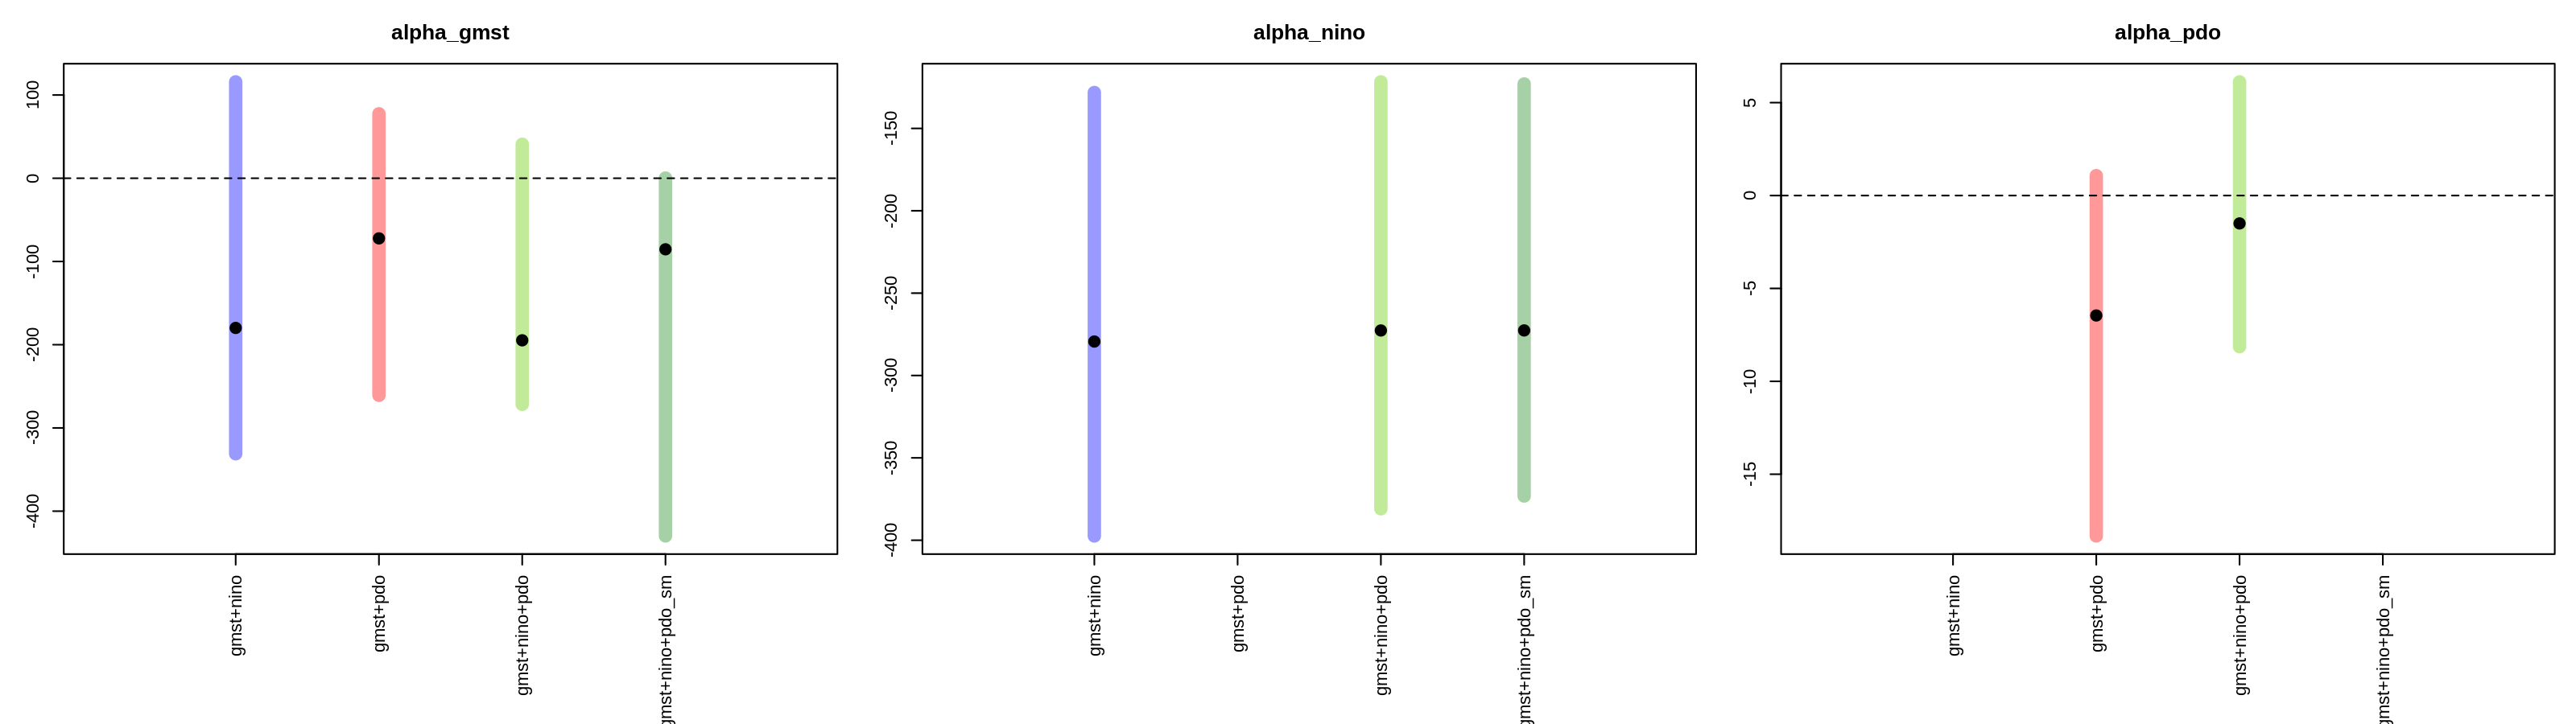

In [157]:
plot_pars <- c("alpha_gmst", "alpha_nino", "alpha_pdo")
n <- 4
prep_window(c(1,4), h = 4.5); par(mar = c(8,3,3,1))

    par(mfrow = c(1,length(plot_pars)))

    for (r in plot_pars) {
        res <- t(sapply(all_res, function(res) if(r %in% rownames(res)) {res[r,]} else {setNames(rep(NA,3), colnames(all_res[[1]]))}))
        ylim = range(res, na.rm = T)
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", log = "")
        axis(1, at = 1:n, labels = names(all_res), las = 2)
        segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 8, col = adjustcolor(c("blue", "red", "chartreuse3", "forestgreen"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = 0, lty = 2)
    }

### Or the AMO?

_Also no. Will look in more detail at some point_

In [370]:
amo <- read.table("data/amo_ersst.txt", comment = "#", row.names = "V1")
amo[amo < -100] <- NA
amo <- data.frame(year = rownames(amo), amo = rowMeans(amo, na.rm = T))

In [371]:
# load & compile data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

df <- merge(merge(merge(gmst, nino), load_ts("ts/panama_pr-wetseason_acp-sat.dat", col.names = c("year", "pr"))), amo)

cov_2023 <- df[df$year == 2023,c("gmst", "nino", "amo")]
cov_cf <- rbind("hist" = cov_2023 - c(1.2,0,0), "neut" = cov_2023 - c(0,cov_2023$nino,0))

In [374]:
models <- list("gmst+nino" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T),
               "gmst+amo" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "amo"), lower = T),
               "gmst+nino+amo" = fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino", "amo"), lower = T))

In [375]:
# no evidence that fit is improved
round(sapply(models, aic), 2)

gmst+nino      gmst+amo gmst+nino+amo 
       635.30        652.39        637.06

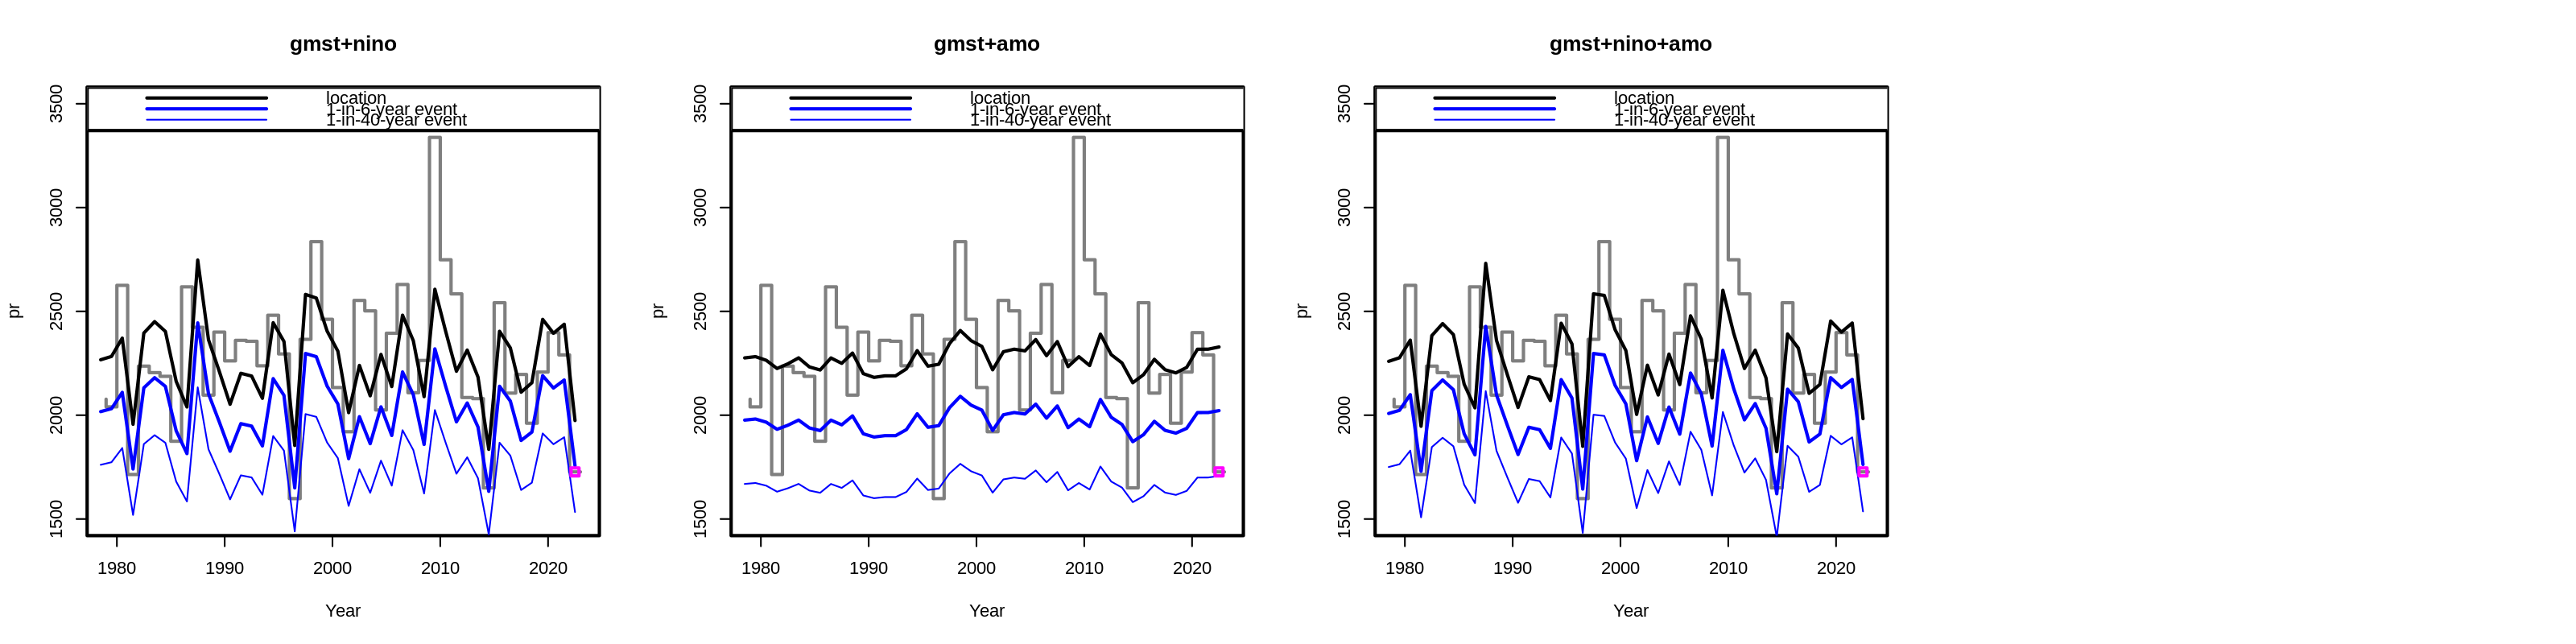

In [376]:
prep_window(c(1,4), h = 4, w = 4, lwd = 2)

for (i in 1:length(models)) {
    mdl <- models[[i]]
    plot_trend(mdl, main = names(models)[i])
}

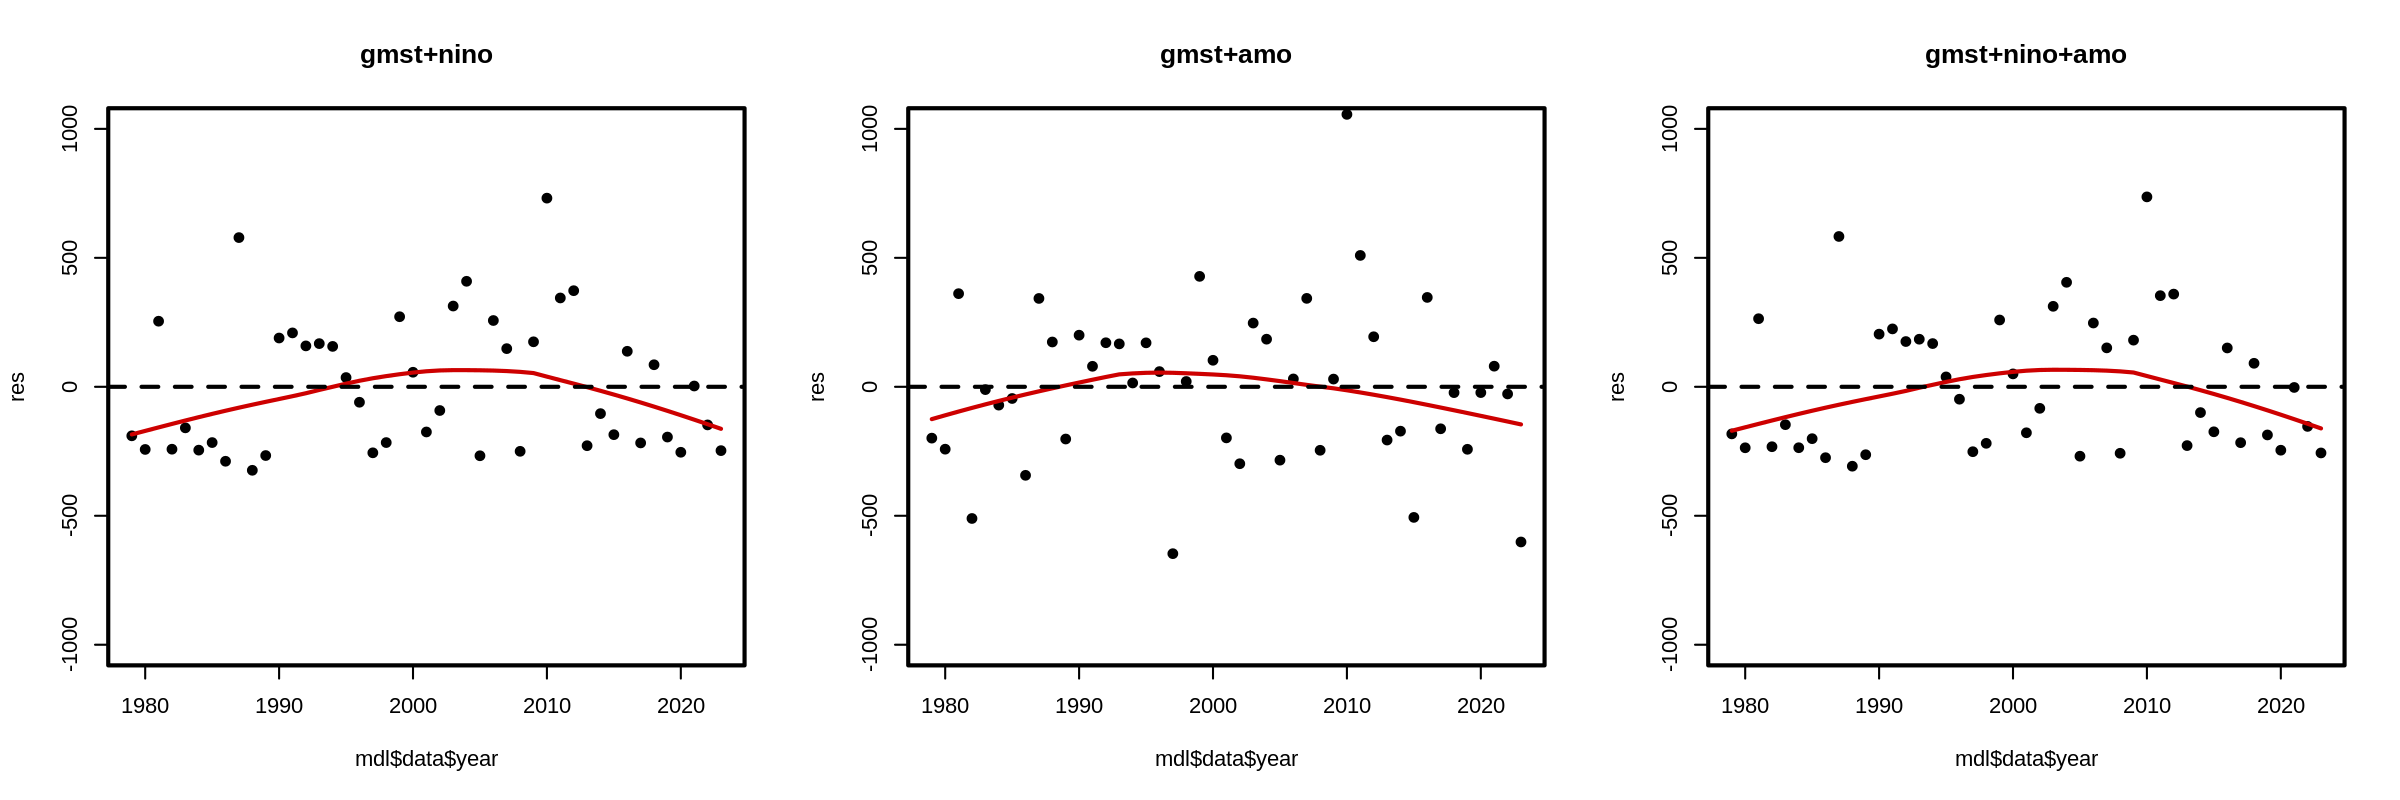

In [377]:
prep_window(c(1,length(models)), h = 4, w = 4, lwd = 2)

for (i in 1:length(models)) {
    mdl <- models[[i]]
    res <- mdl$x - ns_pars(mdl)$loc
    plot(mdl$data$year, res, main = names(models)[i], ylim = c(-1000,1000))
    lines(lowess(mdl$data$year, res), col = "red3")
    abline(h = 0, lty = 2)
}

# Temperatures & PET

## Trends in PET
- Short station time series for BCI (1994-2019) - no evidence of trend over available period
- MSWX has a significant but small increasing trend - maybe an extra 30mm lost to evapotranspiration over the dry season - however, this is a much smaller contribution than the precipitation deficit (100mm or so each from both GMST and Nino)
- also we know that MSWX doesn't do well in this region, either at precip or at PET

### BCI


In [199]:
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

ds <- load_ts("ts_all/panama_pet-dryseason_acp-BCI_claro.dat", col.names = c("year", "pet_ds"))
rs <- load_ts("ts_all/panama_pet-wetseason_acp-BCI_claro.dat", col.names = c("year", "pet_rs"))

df <- merge(merge(merge(gmst, nino), ds), rs)

# remove the two missing/partial years
df <- df[df$year <= 2019,]

In [219]:
mdl_bci_ds <- fit_ns("norm", "shift", df, "pet_ds", c("gmst", "nino"), lower = F)
mdl_bci_rs <- fit_ns("norm", "shift", df, "pet_rs", c("gmst", "nino"), lower = F)

prep_window(c(1,2), h = 4, w = 6)
png("fig/fitted-models_bci-pet_trend.png", height = 480, width = 480*2.5); par(mfrow = c(1,2), cex.main = 1.4); {
    plot_trend(mdl_bci_ds, ylim = c(0,1000), main = "Dry season (Jan-Apr)")
    lines(df$year, fitted(loess(pet_ds ~ year, df, degree = 1)), col = "orange", lwd = 2)
    # abline(line(df$year, df$pet_ds), col = "red", lwd = 2)
    plot_trend(mdl_bci_rs, ylim = c(0,1000), main = "Wet season (May-Dec)")
    lines(df$year, fitted(loess(pet_rs ~ year, df, degree = 1)), col = "orange", lwd = 2)
    # abline(line(df$year, df$pet_rs), col = "red", lwd = 2)
}; dev.off()


png 
  2

In [232]:
res_bci_ds <- boot_ci(mdl_bci_ds, cov_f = data.frame(gmst = 0, nino = 1), cov_cf = rbind("hist" = data.frame(gmst = -1.2, nino = 1), "neut" = data.frame("gmst" = 0, "nino" = 0)))
res_bci_rs <- boot_ci(mdl_bci_rs, cov_f = data.frame(gmst = 0, nino = 1), cov_cf = rbind("hist" = data.frame(gmst = -1.2, nino = 1), "neut" = data.frame("gmst" = 0, "nino" = 0)))

In [233]:
plot_pars <- c("mu0", "alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_abs_hist", "dI_abs_neut", "dI_rel_hist", "dI_rel_neut")
prep_window(c(1,4), h = 4.5)

png("fig/fitted-models_bci-pet_parameters.png", height = 480, width = 480*4); par(cex.main = 2.4); {
    par(mfrow = c(1,length(plot_pars)), mar = c(8,3,3,1))

    for (r in plot_pars) {
        res <- rbind(res_bci_ds[r,], res_bci_rs[r,])
        ylim = range(res, na.rm = T)
        
        n <- nrow(res)
        if(grepl("PR", r)) {
            h = 1
        } else {
            h = 0
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", cex.axis = 2)
        axis(1, at = 1:n, labels = c("Jan-Apr", "May-Dec"), las = 2, cex.axis = 2)
        segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 12, col = adjustcolor(c("blue", "red", "chartreuse3", "forestgreen"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }
}; dev.off()

png 
  2

### MSWX

In [87]:
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

ds <- load_ts("ts_all/panama_pet-dryseason_mswx_br65.dat", col.names = c("year", "pet_ds"))
rs <- load_ts("ts_all/panama_pet-wetseason_mswx_br65.dat", col.names = c("year", "pet_rs"))
df <- merge(merge(merge(gmst, nino), ds), rs)
# df <- df[(df$year >= 1994) & (df$year <= 2019),]

In [88]:
mdl_ds <- fit_ns("norm", "shift", df, "pet_ds", c("gmst", "nino"), lower = F)
mdl_rs <- fit_ns("norm", "shift", df, "pet_rs", c("gmst", "nino"), lower = F)

prep_window(c(1,2), h = 4, w = 6)

png("fig/fitted-models_mswx-petbr_trend.png", height = 480, width = 480*2.5); par(mfrow = c(1,2), cex.main = 1.4); {
    plot_trend(mdl_ds, ylim = c(400,600), main = "Dry season (Jan-Apr)")
    lines(df$year, fitted(loess(pet_ds ~ year, df, degree = 2)), col = "orange", lwd = 2)
    # abline(line(df$year, df$pet_ds), col = "red", lwd = 2)
    plot_trend(mdl_rs, ylim = c(800,1050), main = "Wet season (May-Dec)")
    lines(df$year, fitted(loess(pet_rs ~ year, df, degree = 1)), col = "orange", lwd = 2)
    # abline(line(df$year, df$pet_rs), col = "red", lwd = 2)
}; dev.off()

In [237]:
res_ds <- boot_ci(mdl_ds, cov_f = data.frame(gmst = 0, nino = 1), cov_cf = rbind("hist" = data.frame(gmst = -1.2, nino = 1), "neut" = data.frame("gmst" = 0, "nino" = 0)))
res_rs <- boot_ci(mdl_rs, cov_f = data.frame(gmst = 0, nino = 1), cov_cf = rbind("hist" = data.frame(gmst = -1.2, nino = 1), "neut" = data.frame("gmst" = 0, "nino" = 0)))

In [238]:
plot_pars <- c("mu0", "alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_abs_hist", "dI_abs_neut", "dI_rel_hist", "dI_rel_neut")
prep_window(c(1,4), h = 4.5)

png("fig/fitted-models_mswx-pet_parameters.png", height = 480, width = 480*4); par(cex.main = 2.4); {
    par(mfrow = c(1,length(plot_pars)), mar = c(8,3,3,1))

    for (r in plot_pars) {
        res <- rbind(res_ds[r,], res_rs[r,])
        ylim = range(res, na.rm = T)
        
        n <- nrow(res)
        if(grepl("PR", r)) {
            h = 1
        } else {
            h = 0
        }
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", cex.axis = 2)
        axis(1, at = 1:n, labels = c("Jan-Apr", "May-Dec"), las = 2, cex.axis = 2)
        segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 15, col = adjustcolor(c("blue", "red", "chartreuse3", "forestgreen"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 3)
        abline(h = h, lty = 2)
    }
}; dev.off()

png 
  2

### ERA5Land

In [94]:
pet_ds <- load_ts(paste0("ts_all/panama_pet-dryseason_era5land.dat"), col.names = c("year", "pet_ds"))
pet_rs <- load_ts(paste0("ts_all/panama_pet-wetseason_era5land.dat"), col.names = c("year", "pet_rs"))

nino_rs <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino_rs"))
nino_ds <- load_ts("ts/panama_nino-ds.dat", col.names = c("year", "nino_ds"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

df <- merge(merge(merge(merge(gmst, nino_ds), nino_rs), pet_ds), pet_rs)
df <- df[df$year < 2022,]

df$pet_ds <- -df$pet_ds / 4; df$pet_rs <- -df$pet_rs / 4

cov_2023 <- data.frame(gmst = 0, "nino_ds" = nino_ds$nino_ds[nino_ds$year == 2023], "nino_rs" = nino_rs$nino_rs[nino_rs$year == 2023])
cov_cf <- rbind("hist" = data.frame("gmst" = -1.2, "nino_ds" = nino_ds$nino_ds[nino_ds$year == 2023], "nino_rs" = nino_rs$nino_rs[nino_rs$year == 2023]),
                "neut" = data.frame("gmst" = 0, "nino_ds" = 0, "nino_rs" = 0))

In [111]:
# have to infer the 2023 event value
models <- list("pet ds" = fit_ns("norm", "shift", df, "pet_ds", c("gmst", "nino_ds"), lower = F, ev = mean(df$pet_ds)),
               "pet rs" = fit_ns("norm", "shift", df, "pet_rs", c("gmst", "nino_rs"), lower = F, ev = mean(df$pet_rs)))
nmod <- length(models)

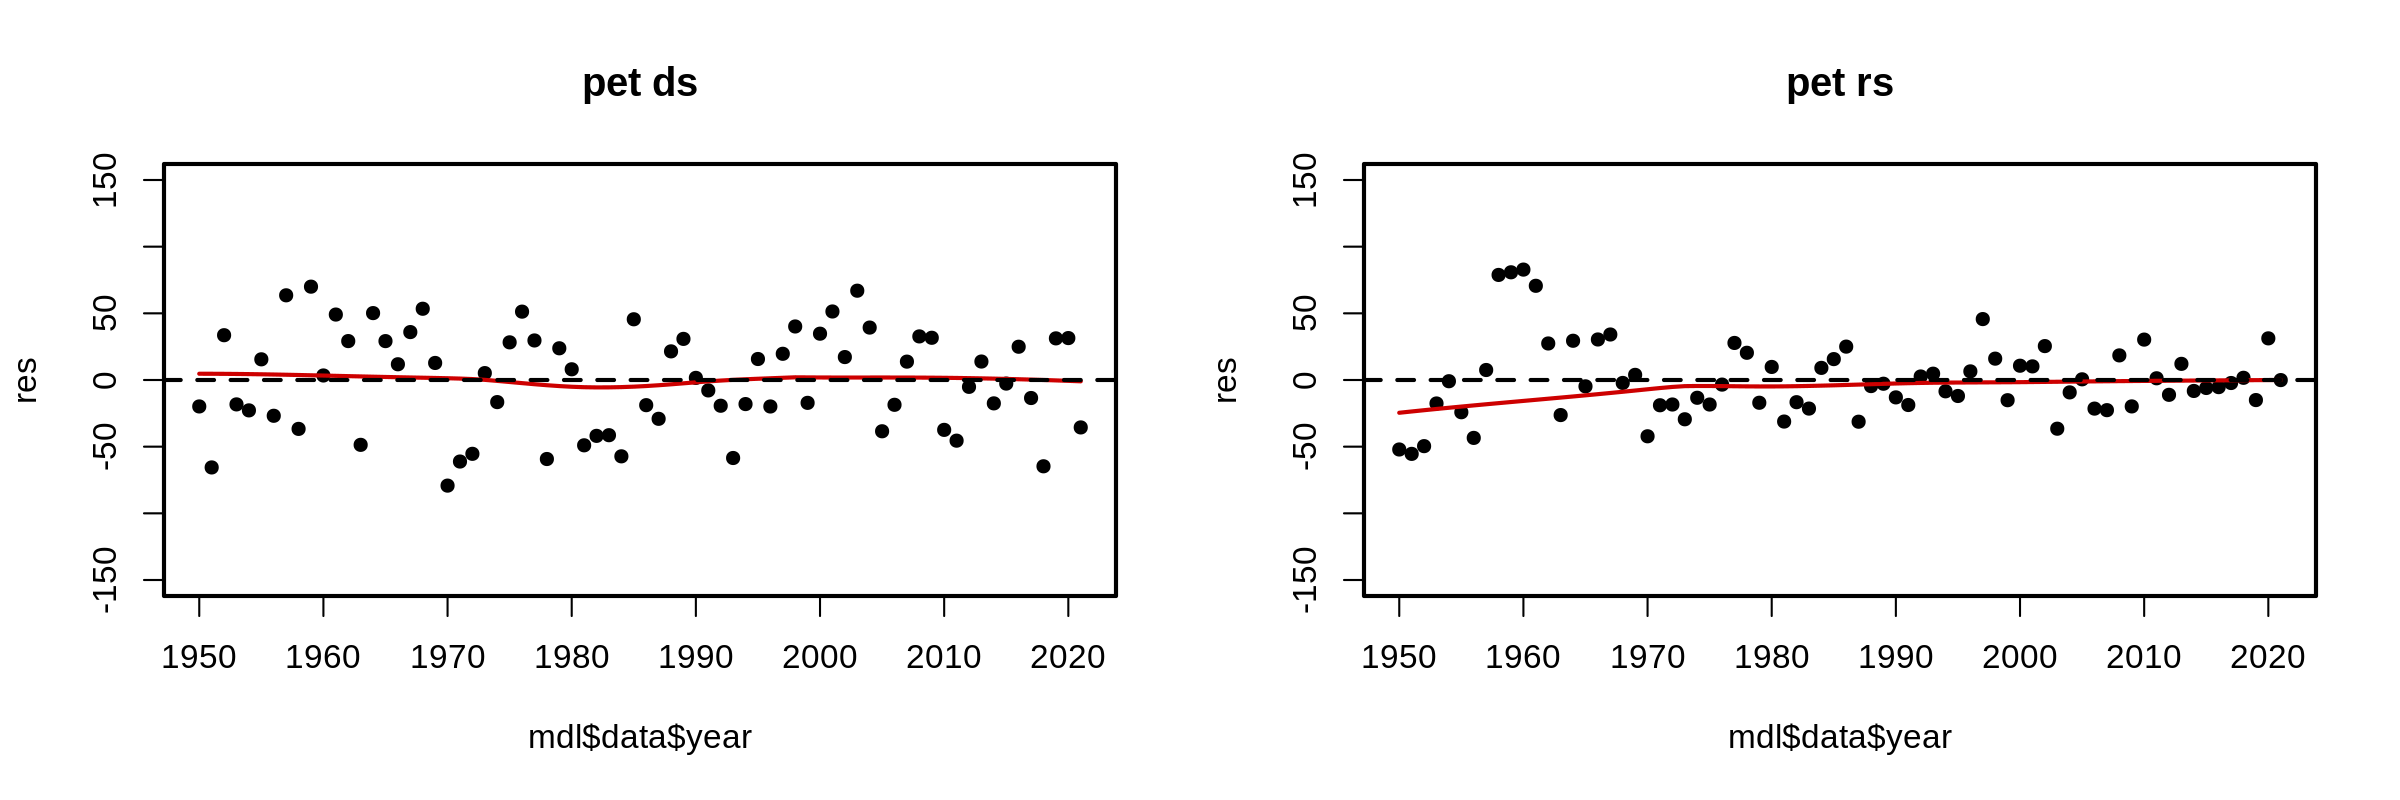

In [112]:
# residuals look pretty good - some decadal structure remaining, but nothing linear
prep_window(c(1,nmod), h = 4, w = 6, lwd = 2)

for (i in 1:nmod) {
    mdl <- models[[i]]
    res <- mdl$x - ns_pars(mdl)$loc
    plot(mdl$data$year, res, main = names(models)[i], ylim = 150*c(-1,1))
    lines(lowess(mdl$data$year, res), col = "red3")
    abline(h = 0, lty = 2)
}

In [113]:
mdl_res <- abind::abind(sapply(models, boot_ci, cov_f = cov_2023, cov_cf = cov_cf, nsamp = 1000, simplify = F), along = 0)
colnames(mdl_res)[4] <- "alpha_nino"

In [124]:
colSums(mdl_res[,"dI_abs_hist",])

est      2.5%     97.5% 
 90.97226  29.32975 146.62855

In [114]:
prep_window(c(1,nmod), h = 4, w = 6)
png(paste0("fig/fitted-models_era5land_pet_trend.png"), height = 480, width = 540*nmod); par(mfrow = c(1,nmod), cex.main = 1.4); {
    for (i in 1:nmod) {
        mdl <- models[[i]]

        plot_trend(mdl, ylim = c(300,700), main = names(models)[i])
        lines(df$year-0.5, fitted(loess(formula(paste0(mdl$varnm, "~ year")), mdl$data, degree = 1)), col = "orange", lwd = 2)
    }
}; dev.off()

png 
  2

In [115]:
plot_pars <- c("mu0", "alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_abs_hist", "dI_abs_neut", "dI_rel_hist", "dI_rel_neut")
prep_window(c(1,4), h = 4.5)

png(paste0("fig/fitted-models_era5land_pet_parameters.png"), height = 480, width = 480*4); par(cex.main = 2.4); {
    par(mfrow = c(1,length(plot_pars)), mar = c(8,3,3,1))

    for (r in plot_pars) {
        res <- mdl_res[,r,]

        n <- nrow(res)
        h <- NA
        
        logxy = ""
        if(grepl("PR", r)) {
            logxy = "y"
            h = 1
        } else if(grepl("alpha", r) | grepl("dI", r)){
            h = 0
        }
        ylim = range(h, res, na.rm = T)

        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", cex.axis = 2, log = logxy)
        axis(1, at = 1:n, labels = rownames(res), las = 2, cex.axis = 2)
        segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 12, col = adjustcolor(c("blue", "red", "chartreuse3", "forestgreen"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }
}; dev.off()

png 
  2

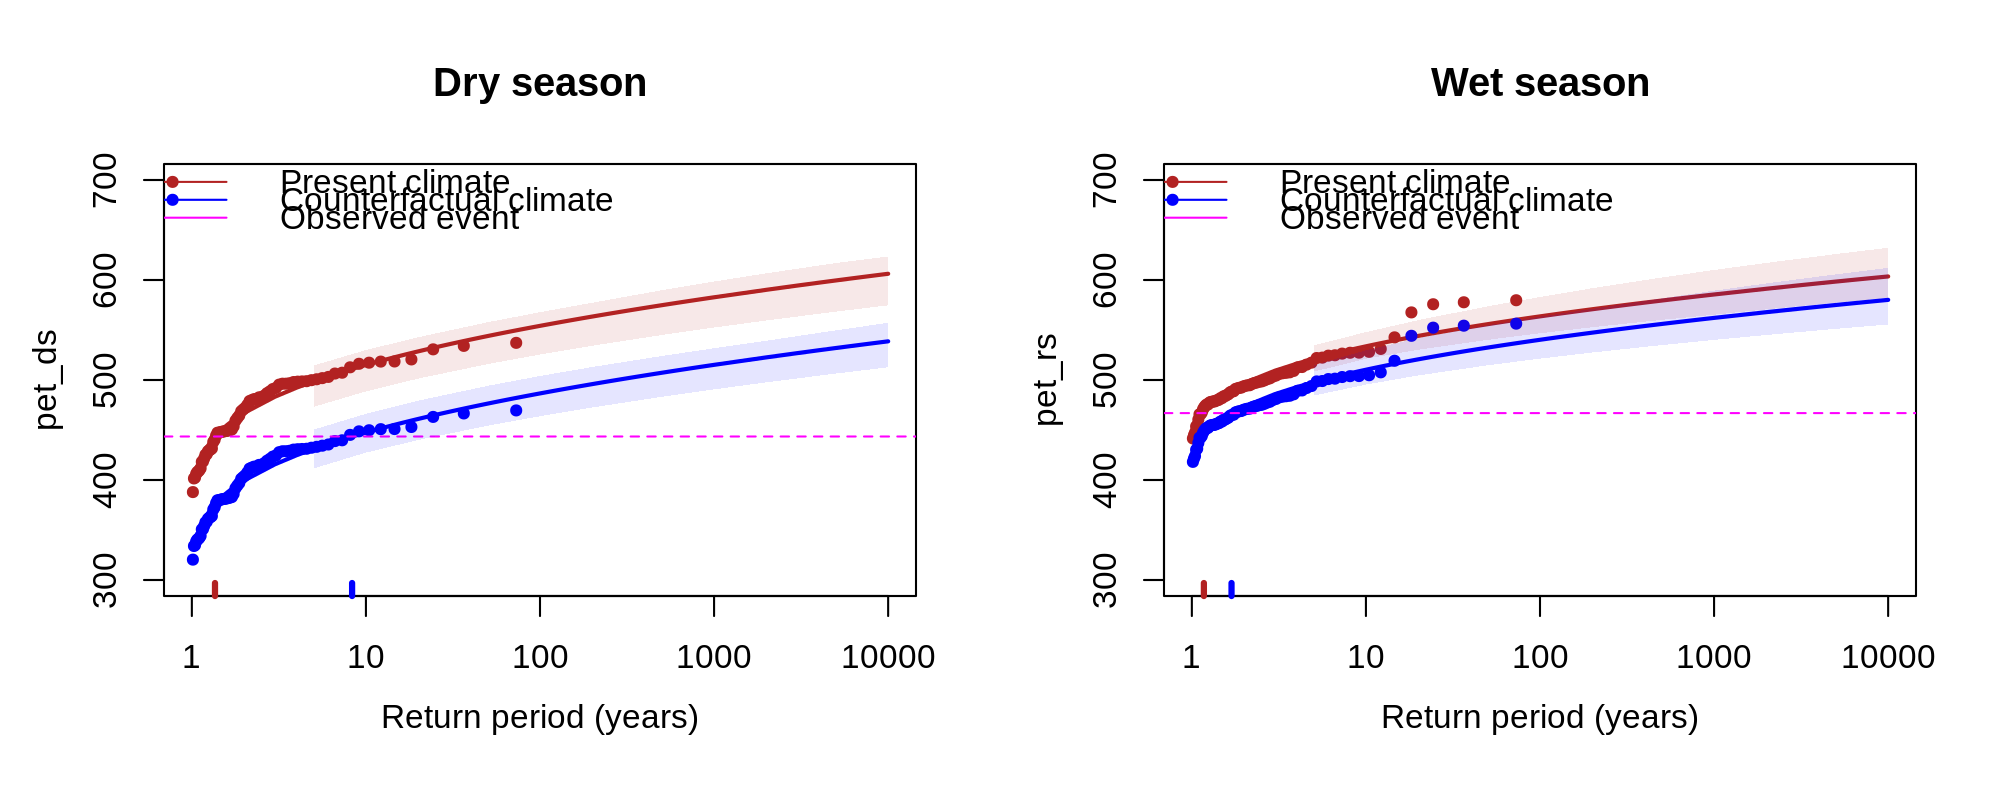

In [116]:
prep_window(c(1,2), h = 4, w = 5)

for (i in 1:nmod) {
    mdl <- models[[i]]
    plot_returnlevels(mdl, cov_f = cov_2023, cov_cf = cov_cf["hist",,drop=F], nsamp = 50, ylim = c(300,700), main = c("Dry season", "Wet season")[i])
}

## Trends in temperatures

In [42]:
df <- read.csv("data/mswx-tmax_ts_monthly.csv")
df$tmax12 <- filter(df$tmax, rep(1/12,12), sides = 1)
df <- df[substr(df$time,6,7) == "12",]
df$year <- as.integer(substr(df$time,1,4))

nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))

df <- merge(merge(gmst, nino), df)

models <- list("GMST only" = fit_ns("norm", "shift", df, "tmax12", "gmst", lower = F),
               "GMST + Nino" = fit_ns("norm", "shift", df, "tmax12", c("gmst", "nino"), lower = F))

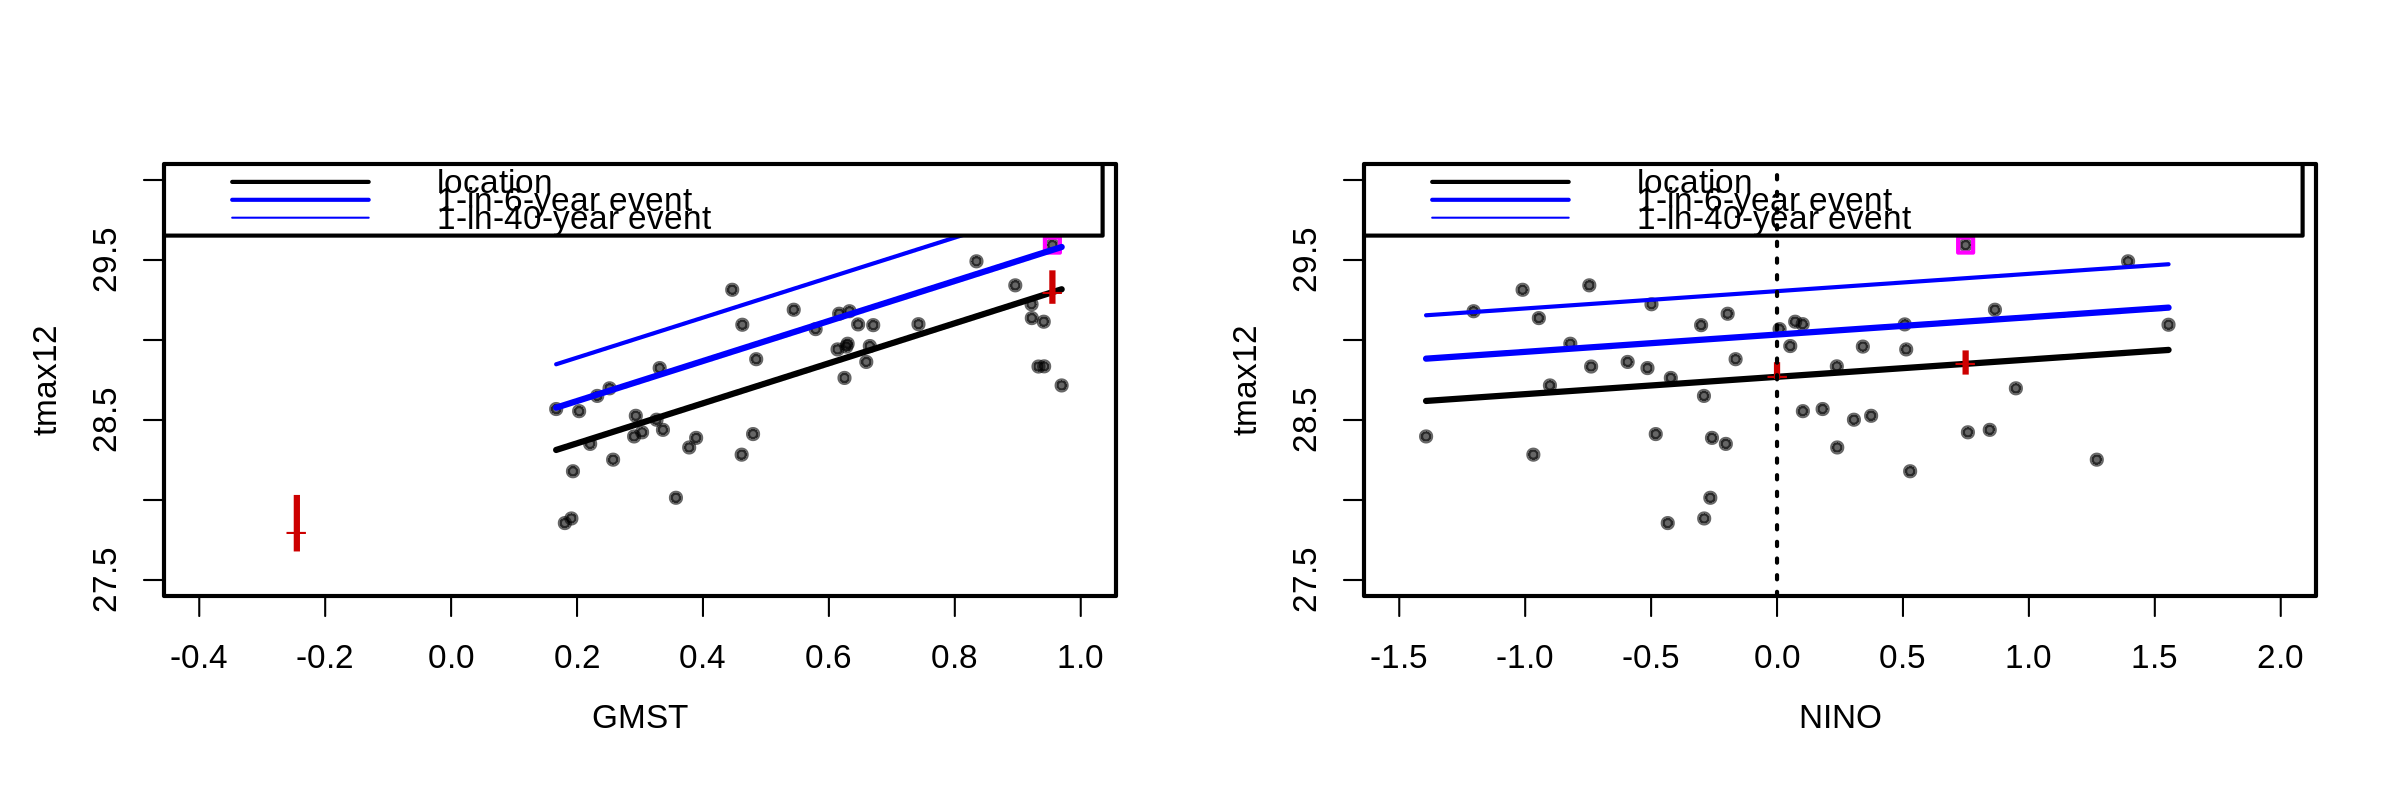

In [43]:
prep_window(c(1,2), h = 4, w = 6, lwd = 2)
plot_covtrend(models[["GMST + Nino"]], "gmst", plot_cov = data.frame(gmst = df$gmst, nino = mean(df$nino)), 
              ci_cov = data.frame(gmst = gmst$gmst[gmst$year == 2023] + c(0,-1.2), nino = mean(df$nino)), nsamp = 10)
plot_covtrend(models[["GMST + Nino"]], "nino", plot_cov = data.frame(gmst = mean(df$gmst), nino = (df$nino)), 
              ci_cov = data.frame(gmst = mean(df$gmst), nino = c(nino$nino[nino$year == 2023], 0)), nsamp = 10)
abline(v = 0, lty = 3)

### ERA5 (mean temps only)

In [140]:
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

ds <- load_ts("ts_all/panama_tas-dryseason_era5.dat", col.names = c("year", "tas_ds"))
rs <- load_ts("ts_all/panama_tas-wetseason_era5.dat", col.names = c("year", "tas_rs"))
df <- merge(merge(merge(gmst, nino), ds), rs)

cov_2023 <- df[df$year == 2023,]
cov_cf <- rbind("hist" = data.frame(gmst = -1.2, nino = df$nino[df$year == 2023]), "neut" = data.frame("gmst" = 0, "nino" = 0))

df <- df[df$year >= 1970,]

In [141]:
models <- list("ERA5 ds" = fit_ns("norm", "shift", df, "tas_ds", c("gmst", "nino"), lower = F),
               "ERA5 rs" = fit_ns("norm", "shift", df, "tas_rs", c("gmst", "nino"), lower = F))

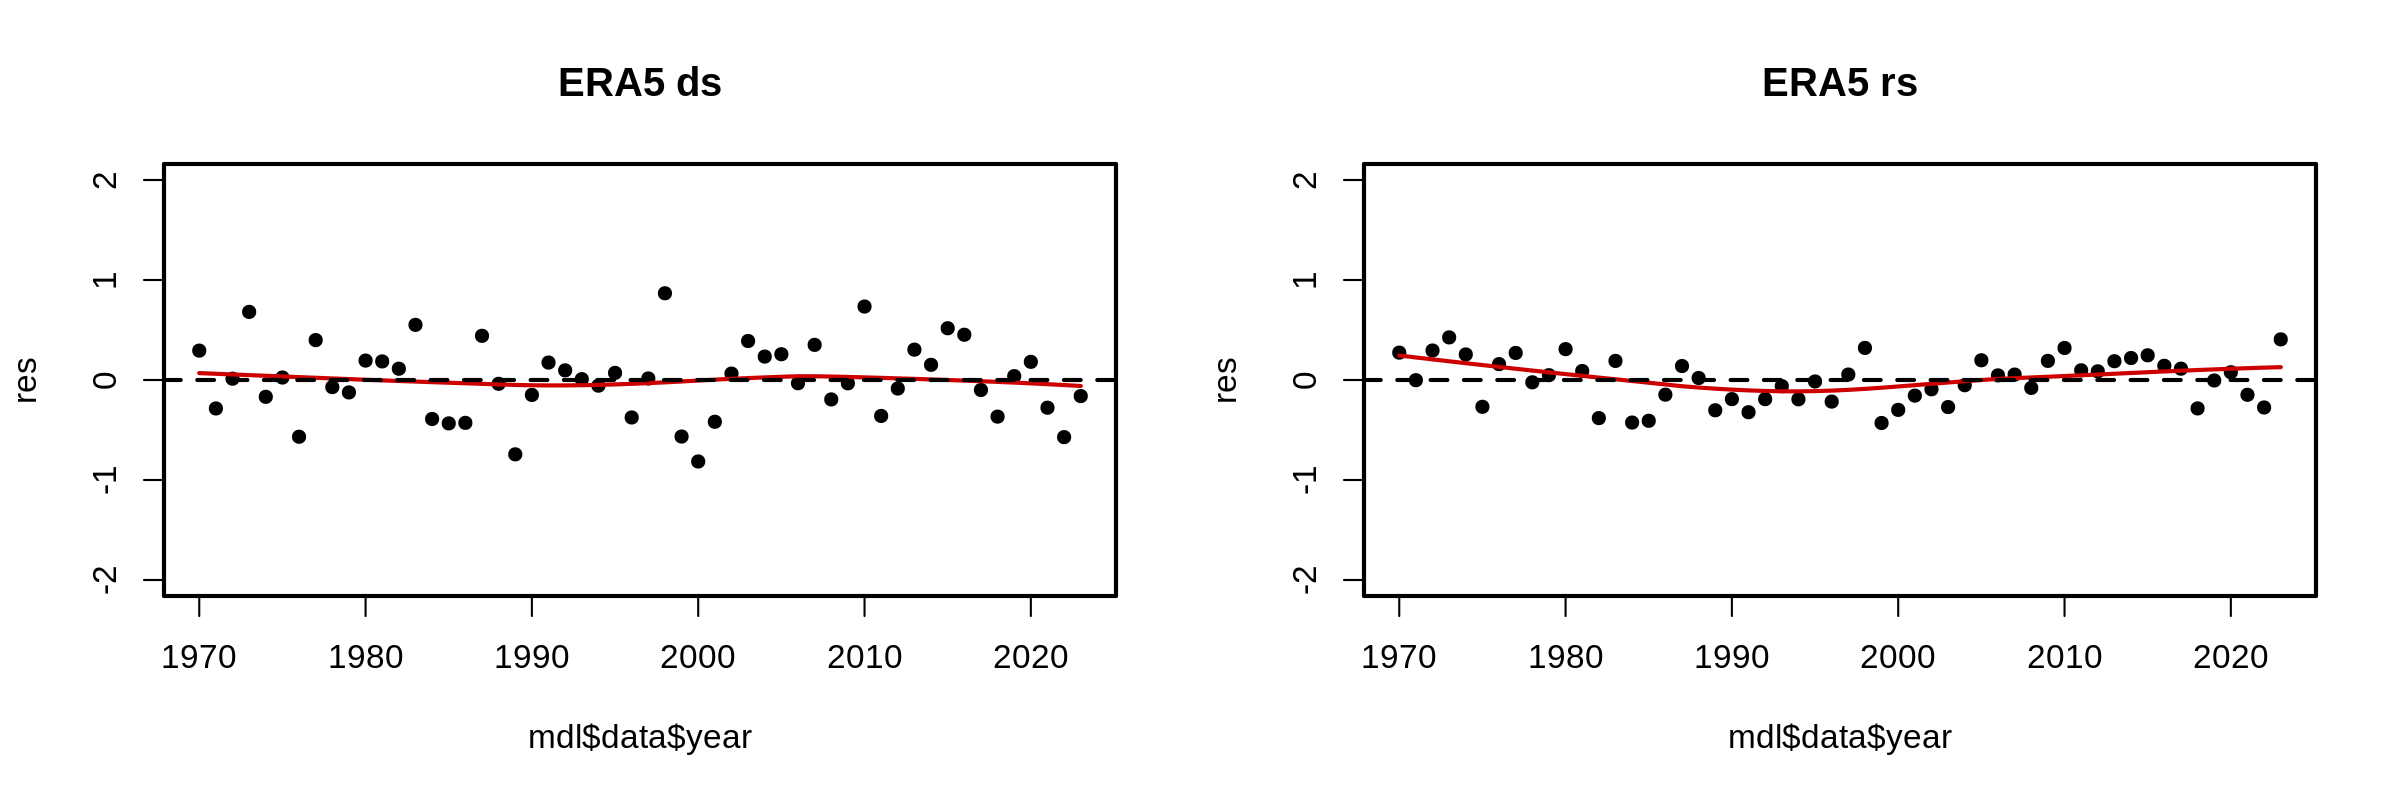

In [142]:
# residuals look pretty good (possibly some structure in RS induced by Nino covariate?)
prep_window(c(1,2), h = 4, w = 6, lwd = 2)

for (i in 1:length(models)) {
    mdl <- models[[i]]
    res <- mdl$x - ns_pars(mdl)$loc
    plot(mdl$data$year, res, main = names(models)[i], ylim = 2*c(-1,1))
    lines(lowess(mdl$data$year, res), col = "red3")
    abline(h = 0, lty = 2)
}

In [143]:
mdl_res <- abind::abind(sapply(models, boot_ci, cov_f = cov_2023, cov_cf = cov_cf, nsamp = 1000, simplify = F), along = 0)

In [144]:
ylim <- c(24,28)
prep_window(c(1,2), h = 4, w = 6)
png("fig/fitted-models_era5_tas_trend.png", height = 480, width = 480*2.5); par(mfrow = c(1,2), cex.main = 1.4); {
    plot_trend(models[["ERA5 ds"]], ylim = ylim, main = "Dry season (Jan-Apr)")
    lines(df$year, fitted(loess(tas_ds ~ year, df, degree = 1)), col = "orange", lwd = 2)
    plot_trend(models[["ERA5 rs"]], ylim = ylim, main = "Wet season (May-Dec)")
    lines(df$year, fitted(loess(tas_rs ~ year, df, degree = 1)), col = "orange", lwd = 2)
}; dev.off()

png 
  2

In [145]:
plot_pars <- c("mu0", "alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_abs_hist", "dI_abs_neut")
prep_window(c(1,4), h = 4.5)

png("fig/fitted-models_era5_tas_parameters.png", height = 480, width = 480*4); par(cex.main = 2.4); {
    par(mfrow = c(1,length(plot_pars)), mar = c(8,3,3,1))

    for (r in plot_pars) {
        res <- mdl_res[,r,]
        ylim = range(res, na.rm = T)

        n <- nrow(res)
        h <- NA
        if(grepl("PR", r)) {
            logxy = "y"
            h = 1
        } else if(grepl("alpha", r) | grepl("dI", r)){
            h = 0
            logxy = ""
        }
        ylim = range(h, res, na.rm = T)

        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", cex.axis = 2, log = logxy)
        axis(1, at = 1:n, labels = c("Jan-Apr", "May-Dec"), las = 2, cex.axis = 2)
        segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 12, col = adjustcolor(c("blue", "red", "chartreuse3", "forestgreen"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }
}; dev.off()

png 
  2

### MSWX

In [125]:
tmax_ds <- load_ts(paste0("ts_all/panama_tmax-dryseason_mswx.dat"), col.names = c("year", "tmax_ds"))
tmax_rs <- load_ts(paste0("ts_all/panama_tmax-wetseason_mswx.dat"), col.names = c("year", "tmax_rs"))

tmin_ds <- load_ts(paste0("ts_all/panama_tmin-dryseason_mswx.dat"), col.names = c("year", "tmin_ds"))
tmin_rs <- load_ts(paste0("ts_all/panama_tmin-wetseason_mswx.dat"), col.names = c("year", "tmin_rs"))

nino_rs <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino_rs"))
nino_ds <- load_ts("ts/panama_nino-ds.dat", col.names = c("year", "nino_ds"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

df <- merge(merge(merge(merge(merge(merge(gmst, nino_ds), nino_rs), tmin_ds), tmin_rs), tmax_ds), tmax_rs)

cov_2023 <- df[df$year == 2023,]
cov_cf <- rbind("hist" = data.frame("gmst" = -1.2, "nino_ds" = df$nino_ds[df$year == 2023], "nino_rs" = df$nino_rs[df$year == 2023]),
                "neut" = data.frame("gmst" = 0, "nino_ds" = 0, "nino_rs" = 0))

In [126]:
models <- list("MSWX tmax ds" = fit_ns("norm", "shift", df, "tmax_ds", c("gmst", "nino_ds"), lower = F),
               "MSWX tmin ds" = fit_ns("norm", "shift", df, "tmin_ds", c("gmst", "nino_ds"), lower = F),
               "MSWX tmax rs" = fit_ns("norm", "shift", df, "tmax_rs", c("gmst", "nino_rs"), lower = F),
               "MSWX tmin rs" = fit_ns("norm", "shift", df, "tmin_rs", c("gmst", "nino_rs"), lower = F))
nmod <- length(models)

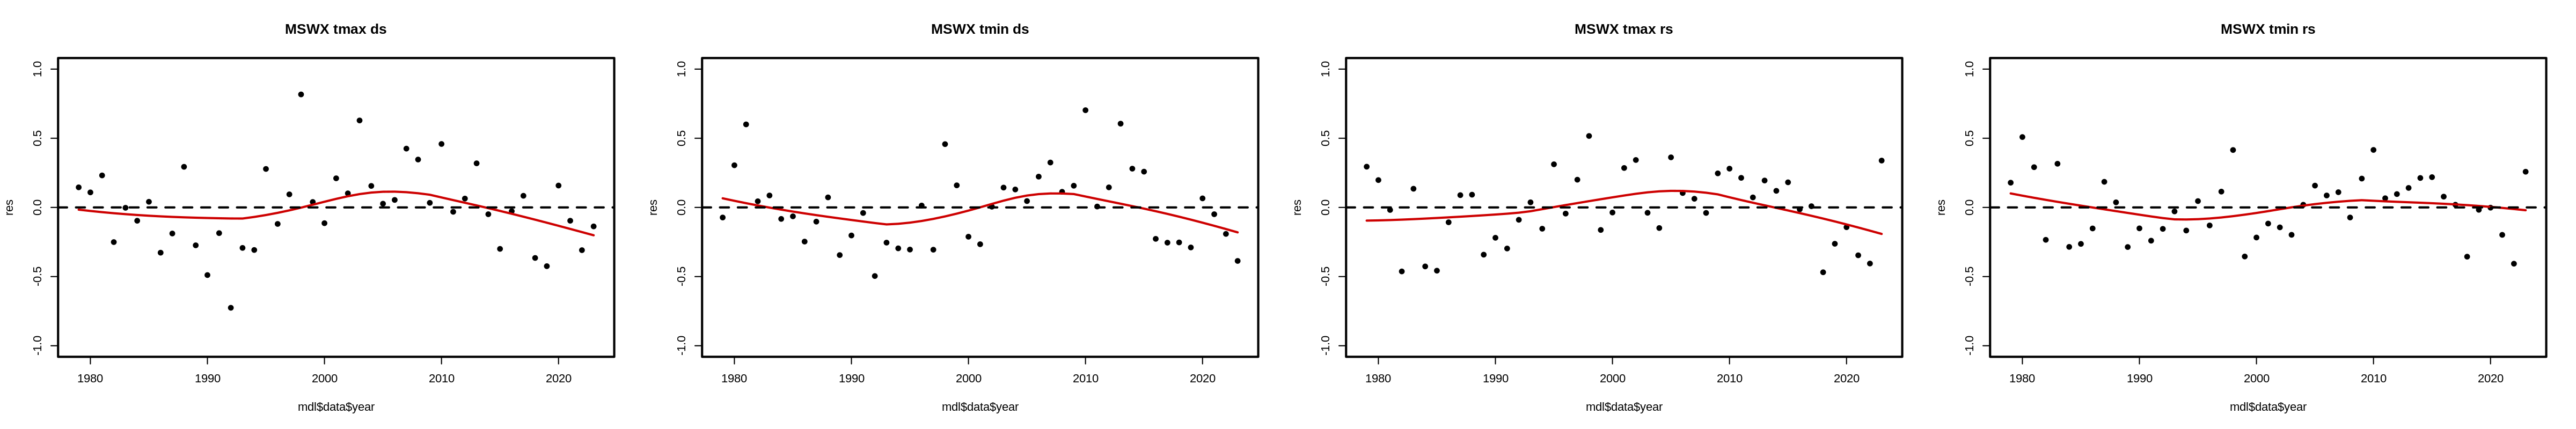

In [127]:
# residuals look pretty good - some decadal structure remaining, but nothing linear
prep_window(c(1,nmod), h = 4, w = 6, lwd = 2)

for (i in 1:nmod) {
    mdl <- models[[i]]
    res <- mdl$x - ns_pars(mdl)$loc
    plot(mdl$data$year, res, main = names(models)[i], ylim = 1*c(-1,1))
    lines(lowess(mdl$data$year, res), col = "red3")
    abline(h = 0, lty = 2)
}

In [128]:
mdl_res <- abind::abind(sapply(models, boot_ci, cov_f = cov_2023, cov_cf = cov_cf, nsamp = 1000, simplify = F), along = 0)
colnames(mdl_res)[4] <- "alpha_nino"

In [134]:
mdl_res[,"dI_abs_hist",]

est      2.5%     97.5%   
MSWX tmax ds 1.596347 1.259718 1.996978
MSWX tmin ds 1.517775 1.166422 1.985710
MSWX tmax rs 1.698842 1.284902 2.140563
MSWX tmin rs 1.811789 1.410123 2.188640

In [131]:
prep_window(c(1,nmod), h = 4, w = 6)
png(paste0("fig/fitted-models_mswx_tas_trend.png"), height = 480, width = 540*nmod); par(mfrow = c(1,nmod), cex.main = 1.4); {
    for (i in 1:nmod) {
        mdl <- models[[i]]

        ylim <- switch(substr(mdl$varnm,1,4), tmax = c(27,32), tmin = c(22,27))

        plot_trend(mdl, ylim = ylim, main = names(models)[i])
        lines(df$year-0.5, fitted(loess(formula(paste0(mdl$varnm, "~ year")), mdl$data, degree = 1)), col = "orange", lwd = 2)
    }
}; dev.off()

png 
  2

In [132]:
plot_pars <- c("mu0", "alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_abs_hist", "dI_abs_neut")
prep_window(c(1,4), h = 4.5)

png(paste0("fig/fitted-models_mswx_tas_parameters.png"), height = 480, width = 480*4); par(cex.main = 2.4); {
    par(mfrow = c(1,length(plot_pars)), mar = c(8,3,3,1))

    for (r in plot_pars) {
        res <- mdl_res[,r,]
        ylim = range(res, na.rm = T)

        n <- nrow(res)
        h <- NA
        if(grepl("PR", r)) {
            logxy = "y"
            h = 1
        } else if(grepl("alpha", r) | grepl("dI", r)){
            h = 0
            logxy = ""
        }
        ylim = range(h, res, na.rm = T)

        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", cex.axis = 2, log = logxy)
        axis(1, at = 1:n, labels = rownames(res), las = 2, cex.axis = 2)
        segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 12, col = adjustcolor(c("blue", "red", "chartreuse3", "forestgreen"), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }
}; dev.off()

## Model for gridded data

In [6]:
ds <- "era5land"; varnm <- "pet"; season <- "rs"

nino <- load_ts(paste0("ts/panama_nino-",season,".dat"), col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

df <- read.csv(paste0("data/",ds,"_",varnm,"-",season,"_flattened.csv"), skip = 3, header = F)
colnames(df)[1] <- "year"

df <- merge(merge(nino, gmst), df)

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [7]:
# fit nonstationary model to all grid cells
models <- sapply(colnames(df)[-(1:3)], function(cnm) {
    df_c <- df[,c("year", "gmst", "nino", cnm)]
    fit_ns("norm", "shift", df_c, cnm, c("gmst", "nino"), lower = F)
}, simplify = F)

In [8]:
fitted_res <- sapply(models, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
fitted_res <- rbind(fitted_res, rp_neut = sapply(models, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop=F])))
write.csv(fitted_res, paste0("res/res_",season,"_",varnm,"_",ds,"-gridded.csv"))

# Station composites
Using predictive mean matching based on year & month, as this guarantees realistic values

## Check number of stations available

In [313]:
# load all station data, add year & month
df <- read.csv("data/pr_stations_acp_monthly.csv", row.names = "X")
df <- cbind("year" = as.integer(substr(rownames(df),1,4)),
            "month" = as.integer(substr(rownames(df),6,7)), df)

# count months each year with non-missing data
rs <- df[df$month > 4,]
nmonths = aggregate(!is.na(df)[,-(1:2)], list(df$year), FUN = "sum")
rs_nmonths = aggregate(!is.na(rs)[,-(1:2)], list(rs$year), FUN = "sum")

In [315]:
rs_stations <- colSums(sapply(1882:1979, function(start_year) {
    min_years <- ceiling((2023-start_year)*0.9)
    colSums(rs_nmonths[rs_nmonths$Group.1 >= start_year,-1] == 8) > min_years
}))
fy_stations <- colSums(sapply(1882:1979, function(start_year) {
    min_years <- ceiling((2023-start_year)*0.9)
    colSums(nmonths[nmonths$Group.1 >= start_year,-1] == 12) > min_years
}))

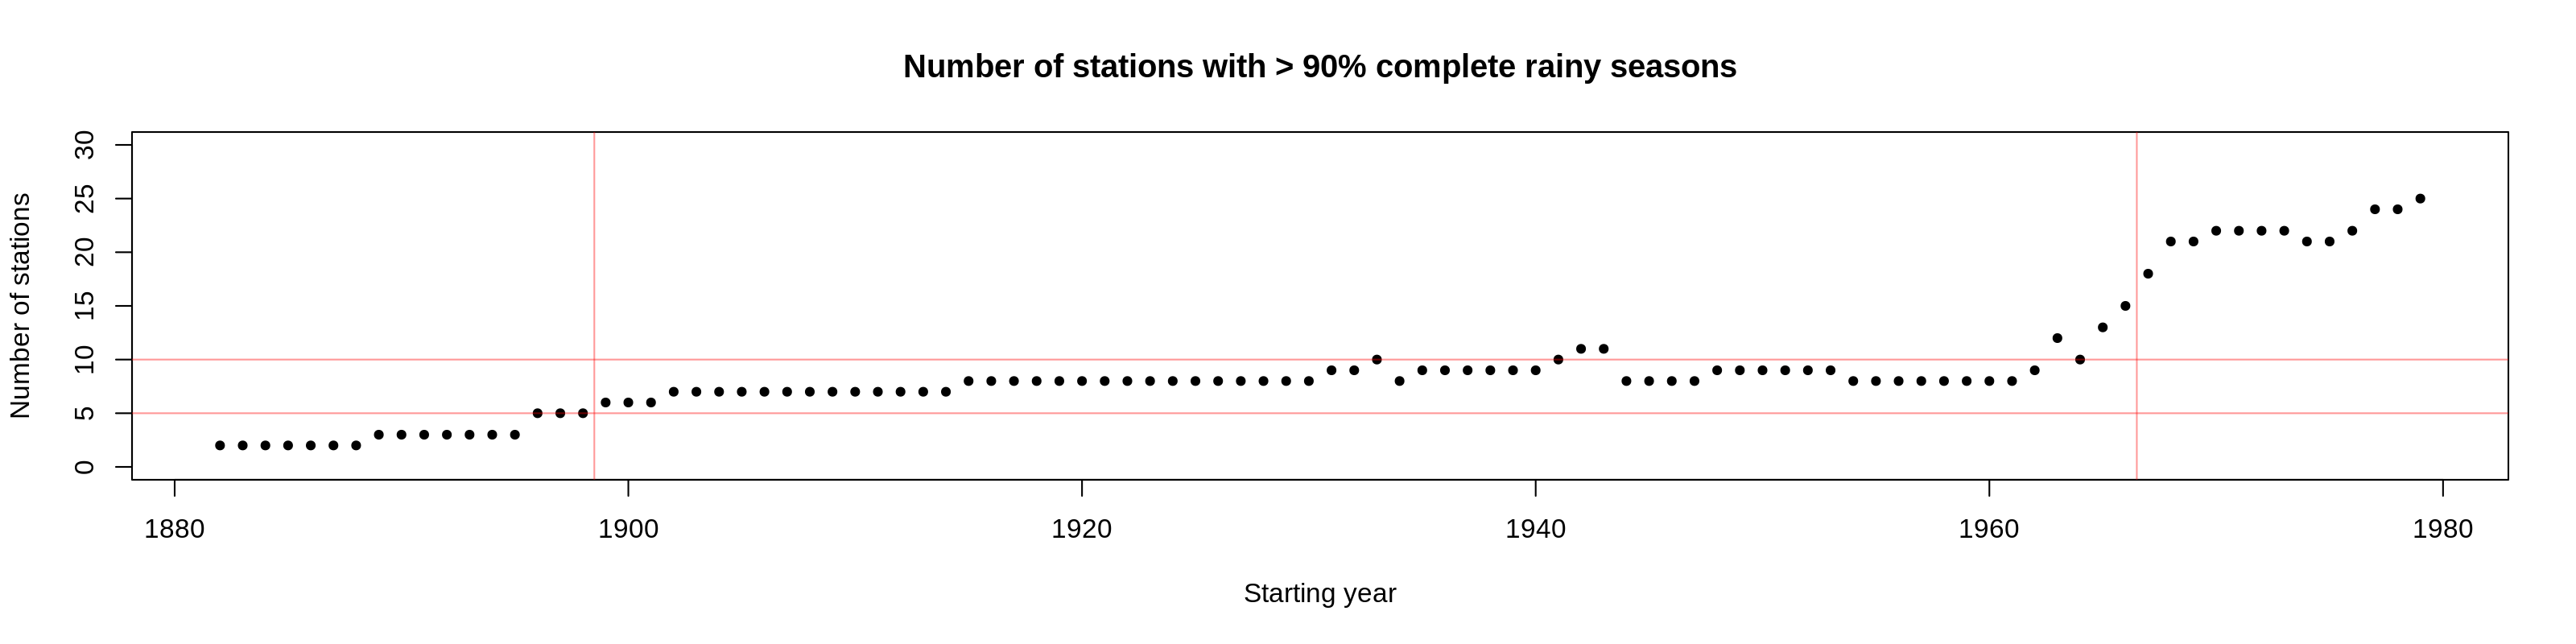

In [319]:
plot(1882:1979, rs_stations, pch = 20, ylim = c(0,30),
     xlab = "Starting year", ylab = "Number of stations", main = "Number of stations with > 90% complete rainy seasons")
# points(1882:1979, fy_stations)
abline(v = c(1899, 1967)-.5, col = adjustcolor("red", 0.4))
abline(h = c(5, 10), col = adjustcolor("red", 0.4))

## Test imputation method

In [16]:
# load all station data
df <- read.csv("data/pr_stations_acp_monthly.csv", row.names = "X")

df <- cbind("year" = as.integer(substr(rownames(df),1,4), "month" = as.integer(substr(rownames(df),6,7), df)

imputed <- df

for(stn in colnames(df)[2:(ncol(df)-2)][1:3]) {
    
    # select the station, year & month columns
    z <- df[,c("year", "month", stn)]
    
    # trim any data prior to first partially complete year; get indices
    years_available <- which(z$year >= min(z$year[!is.na(z[,stn])]))
    z <- z[years_available,]
    
    imputed[years_available, stn] <- complete(mice(z, method = "pmm", print = F))[,stn]
}

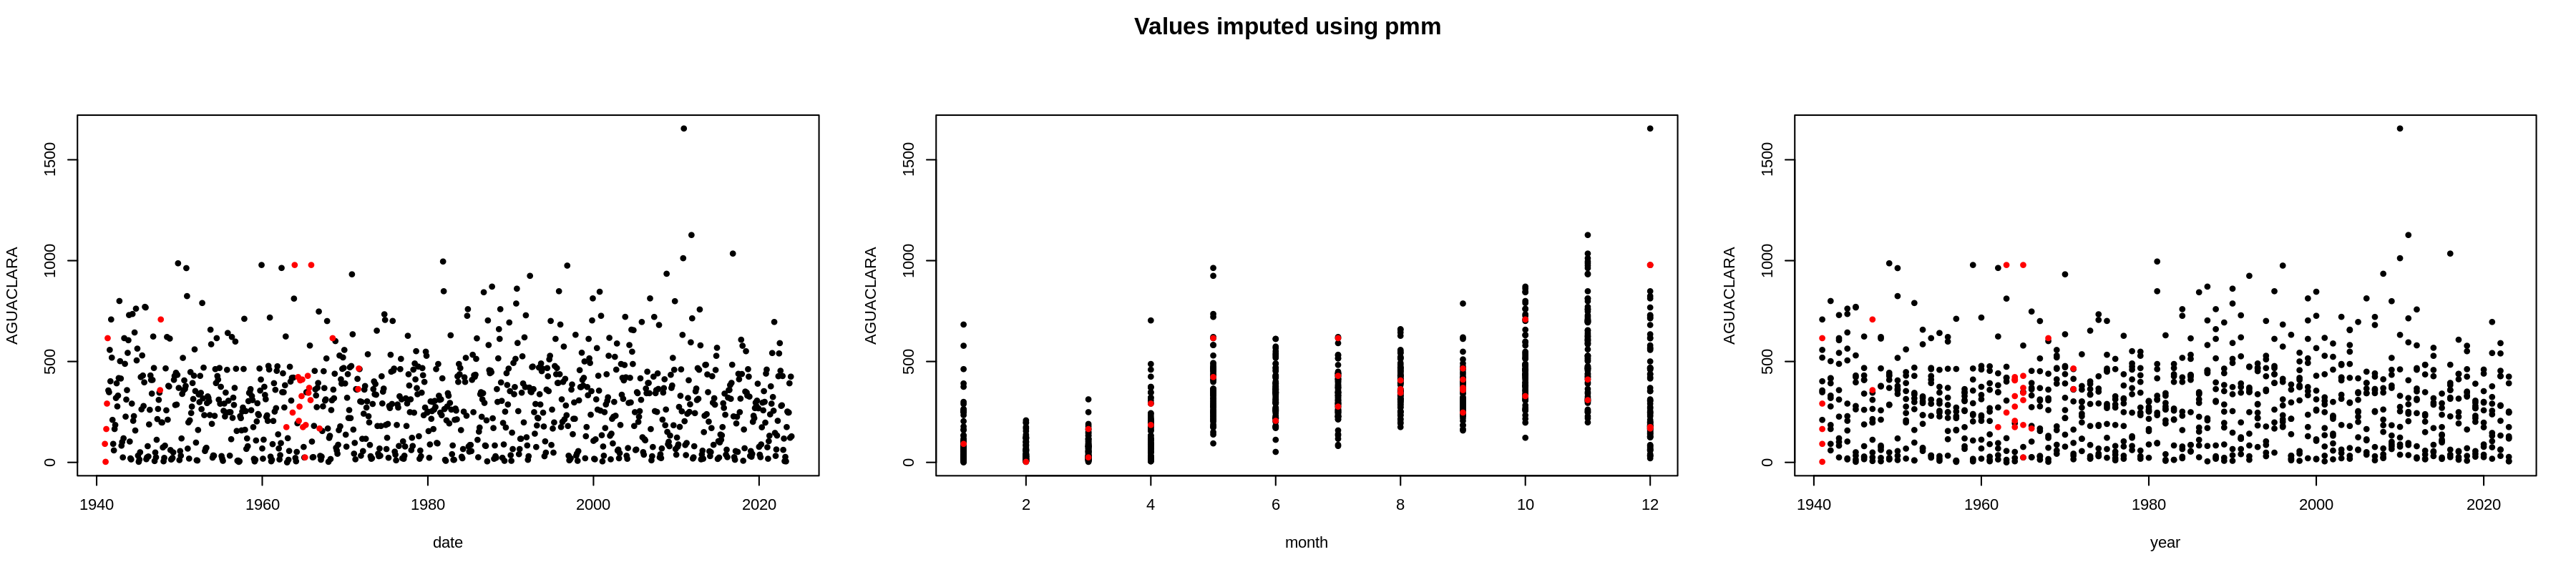

In [21]:
stn <- "AGUACLARA"; mthd <- "pmm"

z <- df[,c("year", "month", stn)]
z <- z[z$year >= min(z$year[!is.na(z[,stn])]),]

set.seed(42)
z_imp <- complete(mice(z, method = mthd, print = F))
colnames(z_imp)[3] <- mthd
z <- merge(z, z_imp)

z$date <- z$year+((z$month-1)/12)

prep_window(c(1,3), w = 6, oma = c(0,0,2,0))

for(xvar in c("date", "month", "year")) {
    plot(z[,c(xvar, stn)])
    points(z[is.na(z[,stn]), c(xvar, mthd)], col = "red")
}

mtext(paste0("Values imputed using ", mthd), outer = T, font = 2, line = 0)

## Impute data for subsets of stations

In [140]:
# set period to select & minimum number of partial years required
start_year <- 1882; min_months <- 0; min_years <- ceiling((2023-start_year)*0.9)

# load all station data, add year & month
df <- read.csv("data/pr_stations_acp_monthly.csv", row.names = "X")
df <- cbind("year" = as.integer(substr(rownames(df),1,4)),
            "month" = as.integer(substr(rownames(df),6,7)), df)

# trim to required period
df <- df[df$year >= start_year,]

# count months each year with non-missing data
nmonths = aggregate(!is.na(df)[,-(1:2)], list(df$year), FUN = "sum")[,-1]

# select only stations with min_years 
df <- df[,c("year", "month", colnames(nmonths)[colSums(nmonths > min_months) > min_years])]

# could also consider removing any stations with more than a certain number of missing months in total? But think this is fine for now

In [141]:
# store imputed values in a new dataframe
imputed <- df
set.seed(42)
for(stn in colnames(df)[-(1:2)]) {
     
    imputed[,stn] <- complete(mice(df[,c("year", "month", stn)], method = "pmm", print = F))[,stn]
}
imputed <- imputed[,-(1:2)]    # trim off year & month, no longer needed
write.csv(imputed, paste0("data/pr-imputed_stations_acp-", start_year, ".csv"))

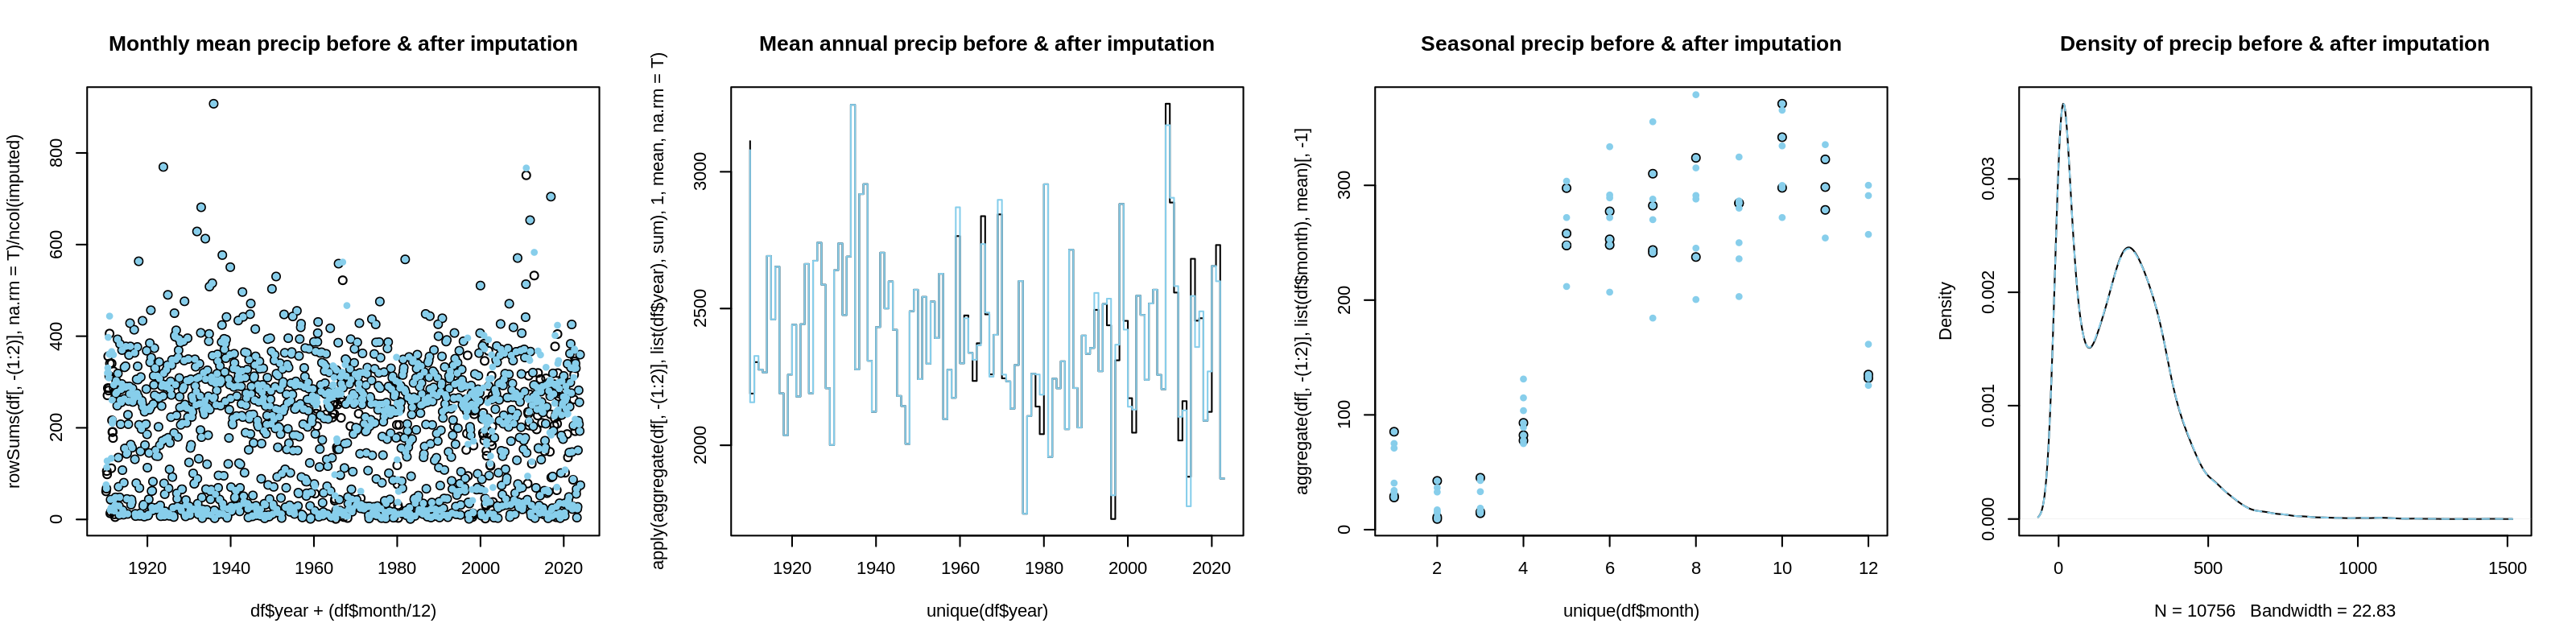

In [139]:
prep_window(c(1,4))

plot(df$year+(df$month/12), rowSums(df[,-(1:2)], na.rm = T) / ncol(imputed), pch = 1, main = "Monthly mean precip before & after imputation")
points(df$year+(df$month/12), rowSums(imputed) / ncol(imputed), pch = 20, col = "skyblue")

plot(unique(df$year), apply(aggregate(df[,-(1:2)], list(df$year), sum), 1, mean, na.rm = T), type = "S", main = "Mean annual precip before & after imputation")
lines(unique(df$year), apply(aggregate(imputed, list(df$year), sum), 1, mean, na.rm = T), type = "S", col = "skyblue")

# matplot(unique(df$year), aggregate(df[,-(1:2)], list(df$year), sum)[,-1], pch = 1, col = "black", main = "Annual total precip before & after imputation")
# matplot(unique(df$year), aggregate(imputed, list(df$year), sum)[,-1], pch = 20, col = "skyblue", add = T)

matplot(unique(df$month), aggregate(df[,-(1:2)], list(df$month), mean)[,-1], pch = 1, col = "black", main = "Seasonal precip before & after imputation")
matplot(unique(df$month), aggregate(imputed, list(df$month), mean)[,-1], pch = 20, col = "skyblue", add = T)

plot(density(unlist(df[,-(1:2)]), na.rm = T), main = "Density of precip before & after imputation")
lines(density(unlist(imputed)), col = "skyblue", lty = 2)

## Impute data for composites

In [19]:
# set period to select & minimum number of partial years required
start_year <- 1882; min_months <- 0; min_years <- ceiling((2023-start_year)*0.9)

# load all station data, add year & month
df <- read.csv("data/pr_stations_acp_monthly.csv", row.names = "X")
df <- cbind("year" = as.integer(substr(rownames(df),1,4)),
            "month" = as.integer(substr(rownames(df),6,7)), df)

# trim to required period
df <- df[df$year >= start_year,]

# count months each year with non-missing data
nmonths = aggregate(!is.na(df)[,-(1:2)], list(df$year), FUN = "sum")[,-1]

# select only stations with min_years 
df <- df[,c("year", "month", colnames(nmonths)[colSums(nmonths > min_months) > min_years])]

# could also consider removing any stations with more than a certain number of missing months in total? But think this is fine for now

nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
df <- merge(gmst, nino)

cov_2023 <- df[df$year == 2023,c("gmst", "nino")]
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(gmst = cov_2023$gmst, nino = 0))

In [20]:
if(!file.exists(paste0("res/imputed-values_acp-", start_year, ".rdata"))) {
    # if not already done, repeat imputation 100 times to test effect
    set.seed(42)
    imputed <- list()

    for(i in 1:100) {
        tmp <- df
        for(stn in colnames(df)[-(1:2)]) {

            tmp[,stn] <- complete(mice(df[,c("year", "month", stn)], method = "pmm", print = F))[,stn]
        }
        imputed[[i]] <- tmp[,-(1:2)]    # trim off year & month, no longer needed
    }
    imputed <- abind::abind(imputed, along = 0)
    save(imputed, file = paste0("res/imputed-values_acp-", start_year, ".rdata"))
} else {
    load(paste0("res/imputed-values_acp-", start_year, ".rdata"))
}

In [21]:
if(!file.exists(paste0("res/imputed-bootstrap_acp-", start_year, ".rdata"))) {
    imputed_bootstrap <- abind::abind(sapply(1:100, function(i) {
        ts <- rowMeans(imputed[i,,])
        years <- unique(as.integer(substr(names(ts),1,4)))
        rs <- stats::filter(ts, rep(1,8), sides = 1)[substr(names(ts),6,7) == "12"]

        df <- merge(merge(gmst, nino), data.frame(year = years, pr = rs))
        boot_ci(fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T), cov_2023, cov_cf, nsamp = 100)
    }, simplify = F), along = 0)
    save(imputed_bootstrap, file = paste0("res/imputed-bootstrap_acp-", start_year, ".rdata"))
}

In [9]:
prep_window(c(1,2), w = 7)

composites <- apply(imputed, c(2,1), mean)
seasons <- (as.integer(substr(colnames(imputed),6,7)) <= 4)+1

png(paste0("fig/effect-of-imputation_acp-", start_year,".png"), height = 480, width = 1680); {
    par(mfrow = c(1,2))
    dates <- as.integer(substr(colnames(imputed),1,4)) + as.integer(substr(colnames(imputed),6,7))/12

    matplot(dates, composites, type = "l", lty = 1, col = adjustcolor("cornflowerblue", 0.3),
            xlab = "", ylab = "Monthly precip (mm)", main = "100 station composites with imputed values")
    lines(dates, rowMeans(df[,-(1:2)], na.rm = T))
    legend("topleft", c("Imputed composite", "Mean without imputation"), col = c("cornflowerblue", "black"), lty = 1)

    plot(dates, apply(composites, 1, sd), pch = 20, col = c("blue", "orange")[seasons], main = "Standard error of composite mean", xlab = "", ylab = "Monthly precip (mm)", )
}; dev.off()

png 
  2

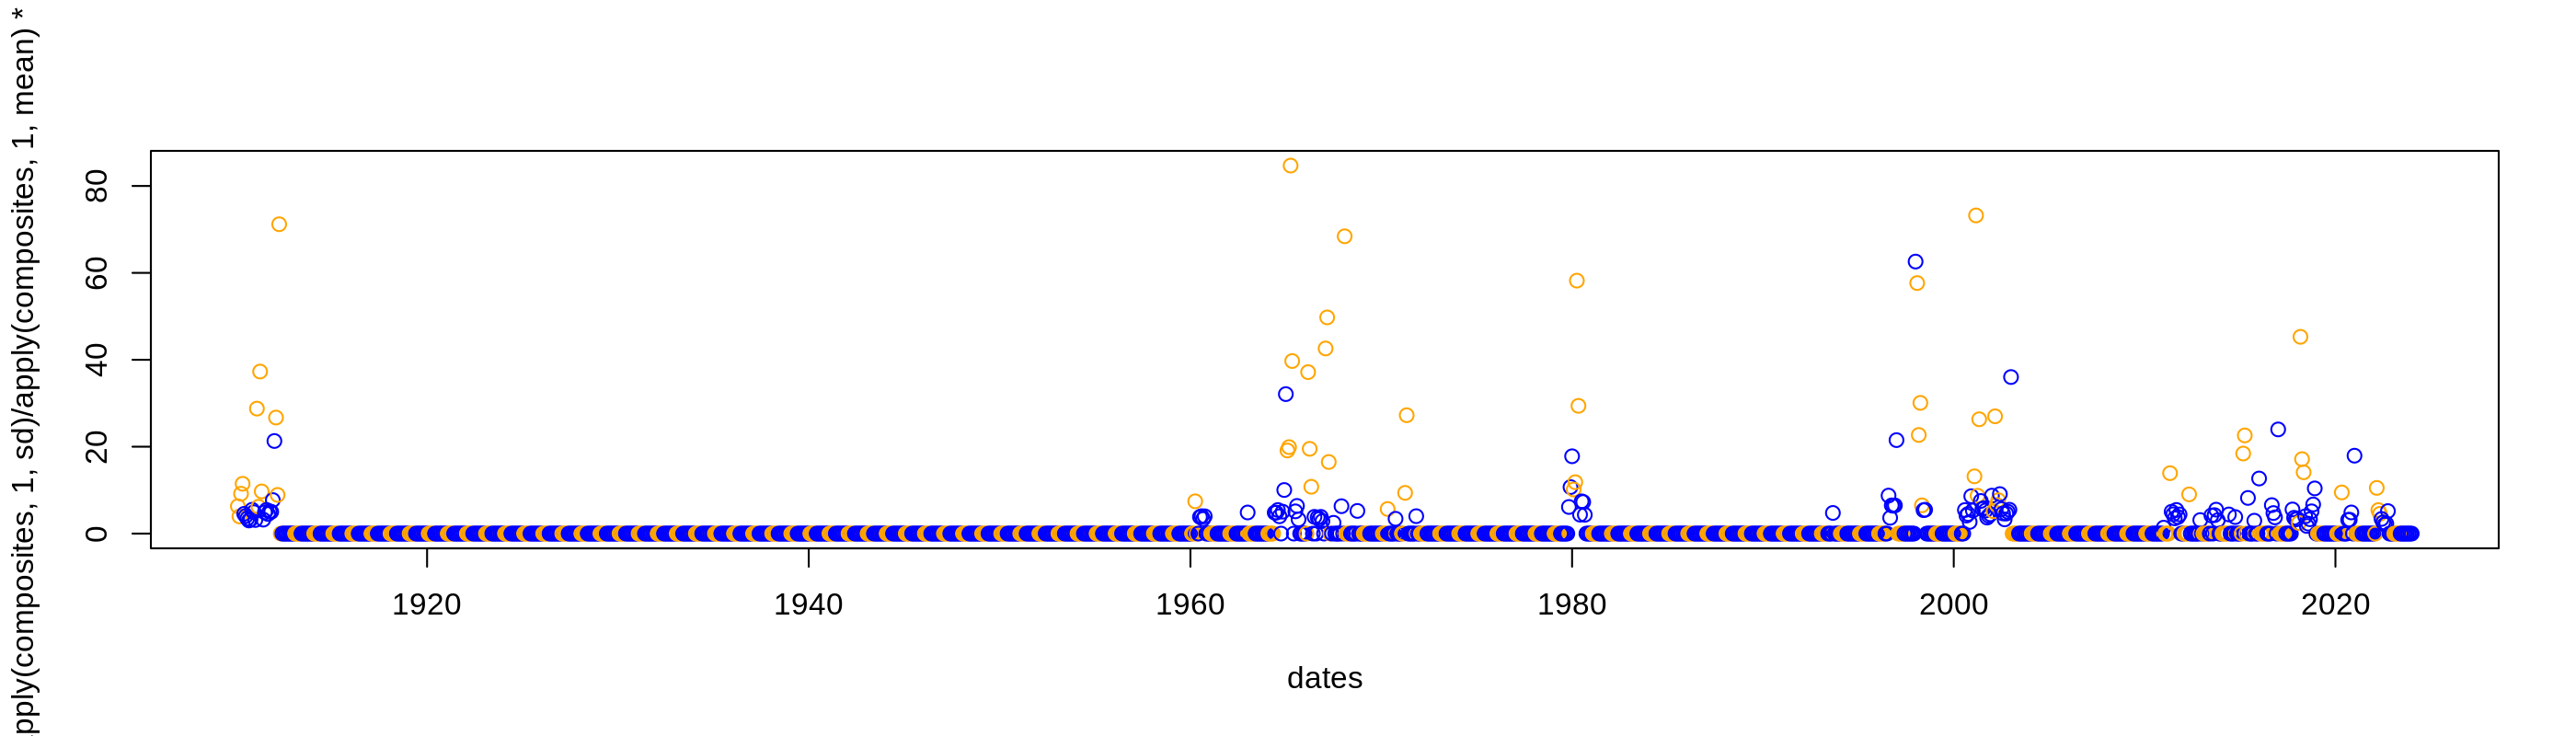

In [10]:
plot(dates, apply(composites, 1, sd) / apply(composites, 1, mean) * 100, col = c("blue", "orange")[seasons])

### Effect of imputation on fitted model

In [322]:
## FIT MODELS WITHOUT IMPUTATION

min_months <- 0

# load all station data, add year & month
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(gmst = cov_2023$gmst, nino = 0))

acp <- read.csv("data/pr_stations_acp_monthly.csv", row.names = "X")
acp <- cbind("year" = as.integer(substr(rownames(acp),1,4)),
            "month" = as.integer(substr(rownames(acp),6,7)), acp)

# fit model to subset of data
mdl_res <- list()
for(start_year in c(1882, 1910, 1979)) {
    
    # select only stations with min_years 
    min_years <- ceiling((2023-start_year)*0.9)
    df <- acp[acp$year >= start_year,]
    
    nmonths = aggregate(!is.na(df)[,-(1:2)], list(df$year), FUN = "sum")[,-1]
    df <- df[,c("year", "month", colnames(nmonths)[colSums(nmonths > min_months) > min_years])]
    
    # get rainy season accumulated precip
    rs <- stats::filter(rowMeans(df[,-(1:2)], na.rm = T), rep(1,8), sides = 1)[substr(rownames(df),6,7) == "12"]
    rs <- data.frame("year" = as.integer(unique(substr(row.names(df),1,4))),
                     "pr" = stats::filter(rowMeans(df, na.rm = T), rep(1,8), sides = 1)[substr(rownames(df),6,7) == "12"])
    
    rs <- merge(merge(gmst, nino), rs)
    mdl <- fit_ns("norm", "fixeddisp", rs, "pr", c("gmst", "nino"), lower = T)
    mdl_res[[as.character(start_year)]] <- boot_ci(mdl, cov_2023, cov_cf, nsamp = 1000)
}
mdl_res <- abind::abind(mdl_res, along = 0)

In [323]:
# fit model to subset of data
complete_res <- list()
for(start_year in c(1882, 1910, 1979)) {
        
    # filter to retain only stations with at least 1 month of data in 90% of years during the period of interest
    min_years <- ceiling((2023-start_year)*0.9)
    df <- acp[acp$year >= start_year,]
    nmonths = aggregate(!is.na(df)[,-(1:2)], list(df$year), FUN = "sum")[,-1]
    df <- df[,c("year", "month", colnames(nmonths)[colSums(nmonths > 0) > min_years])]
    
    # get rainy season accumulated precip - exclude any periods with missing data
    rs <- stats::filter(rowMeans(df[,-(1:2)], na.rm = F), rep(1,8), sides = 1)[substr(rownames(df),6,7) == "12"]
    years <- as.integer(unique(substr(row.names(df),1,4)))
    rs <- data.frame("year" = years, "pr" = rs)[!is.na(rs),]
    
    rs <- merge(merge(gmst, nino), rs)
    mdl <- fit_ns("norm", "fixeddisp", rs, "pr", c("gmst", "nino"), lower = T)
    complete_res[[as.character(start_year)]] <- boot_ci(mdl, cov_2023, cov_cf, nsamp = 1000)
}
complete_res <- abind::abind(complete_res, along = 0)

In [56]:
## FITTED MODELS WITH IMPUTATION
imputed_res <- list()
for(start_year in c(1882, 1910, 1979)) {
    load(paste0("res/imputed-bootstrap_acp-", start_year, ".rdata"))
    imputed_res[[as.character(start_year)]] <- imputed_bootstrap
}
imputed_res <- abind::abind(imputed_res, along = 0)

In [102]:
all_res <- abind::abind(mdl_res, imputed_res, complete_res, along = 2)

In [118]:
all_res["1979",,"return_period","97.5%"][all_res["1979",,"return_period","97.5%"] > 5000] <- NA

In [136]:
plot_pars <- c("alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_rel_hist", "dI_rel_neut", "dI_abs_hist", "dI_abs_neut")
prep_window(c(1,4), h = 4.5)

png("fig/imputed-par-ests_acp-composite.png", height = 480, width = 480*4); par(cex.main = 1.4); {

    par(mfrow = c(1,length(plot_pars)), mar = c(11,3,3,1), oma = c(0,0,2,0))

    for (r in plot_pars) {
        res <- all_res[,,r,]
        
        h <- NA
        logaxs = ""
        ylim = range(pretty(res))
        
        if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(0, pretty(log(all_res[,,grepl("PR", dimnames(all_res)[[3]]),]))))
        } else if (grepl("dI_abs", r)) {
            h = 0
            ylim = range(h, pretty(all_res[,,grepl("dI_abs", dimnames(all_res)[[3]]),]))
        } else if(grepl("dI_rel", r)) {
            h = 0
            ylim = range(h, pretty(all_res[,,grepl("dI_rel", dimnames(all_res)[[3]]),]))
        } else if(grepl("alpha", r)) {
            h = 0
            ylim = range(pretty(all_res[,,grepl("alpha", dimnames(all_res)[[3]]),]))
        } 
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,10), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = 1:9, labels = paste(rep(c("Simple mean", "Complete years", "Imputed"), each = 3), paste0(rownames(all_res), "-2023")), las = 2)
        
        segments(x0 = 1:3, y0 = res[,1,"2.5%"], y1 = res[,1,"97.5%"], lwd = 8, col = adjustcolor("blue", alpha = 0.4))
        segments(x0 = 7:9, y0 = res[,2:101,"2.5%"], y1 = res[,2:101,"97.5%"], lwd = 8, col = adjustcolor("red", alpha = 0.1))
        segments(x0 = 4:6, y0 = res[,-(1:101),"2.5%"], y1 = res[,-(1:101),"97.5%"], lwd = 8, col = adjustcolor("forestgreen", alpha = 0.4))

        points(1:3, res[,1,"est"], pch = 20,  lwd = 2, cex = 2)
        points(rep(7:9,100), res[,2:101,"est"], pch = 20,  lwd = 2, cex = 2)
        points(4:6, res[,-(1:101),"est"], pch = 20,  lwd = 2, cex = 2)

        abline(h = h, lty = 2)
    }
    mtext("Effect of imputation / using complete years only on parameters of model fitted to ACP station mean", outer = T, font = 2)
}; dev.off()

png 
  2

### Parameters for single year

In [26]:
start_year <- 1882

# load imputed values & bootstrapped range
load(paste0("res/imputed-bootstrap_acp-", start_year, ".rdata"))

# fit model to mean of available data without imputation

rs <- rs[rs$year >= start_year,]

nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
df <- merge(merge(gmst, nino), rs)

cov_2023 <- df[df$year == 2023,c("gmst", "nino")]
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(gmst = cov_2023$gmst, nino = 0))

# get results
mdl <- fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
boot_res <- boot_ci(mdl, cov_2023, cov_cf)

all_res <- abind::abind(boot_res, imputed_bootstrap, along = 1)

In [27]:
plot_pars <- c("alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_rel_hist", "dI_rel_neut", "dI_abs_hist", "dI_abs_neut")
prep_window(c(1,4), h = 4.5)

png(paste0("fig/imputed-par-ests_acp-", start_year,".png"), height = 480, width = 480*4); par(cex.main = 1.4); {

    par(mfrow = c(1,length(plot_pars)), mar = c(7,3,3,1), oma = c(0,0,2,0))

    for (r in plot_pars) {
        res <- all_res[,r,]
        
        n <- nrow(res)
        h <- NA
        logaxs = ""
        ylim = range(pretty(res))
        
        if(grepl("PR", r)) {
            h = 1
            logaxs = "y"
            ylim = exp(range(0, pretty(log(all_res[,grepl("PR", colnames(all_res)),]))))
        } else if (grepl("dI_abs", r)) {
            h = 0
            ylim = range(h, pretty(all_res[,grepl("dI_abs", colnames(all_res)),]))
        } else if(grepl("dI_rel", r)) {
            h = 0
            ylim = range(h, pretty(all_res[,grepl("dI_rel", colnames(all_res)),]))
        } else if(grepl("alpha", r)) {
            h = 0
            ylim = range(pretty(all_res[,grepl("alpha", colnames(all_res)),]))
        } 
        
        plot(1, type = "n", ylim = ylim, xlim = c(0,3), main = r, xaxt = "n", xlab = "", ylab = "", log = logaxs)
        axis(1, at = 1:2, labels = c("Simple mean", "Imputed"), las = 2)
        
        segments(x0 = 1, y0 = res[1,"2.5%"], y1 = res[1,"97.5%"], lwd = 8, col = adjustcolor("blue", alpha = 0.4))
        segments(x0 = 2, y0 = res[-1,"2.5%"], y1 = res[-1,"97.5%"], lwd = 8, col = adjustcolor("red", alpha = 0.1))

        # segments(x0 = rep(1,n), y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 8, col = adjustcolor(c("blue", "red", "chartreuse3", "forestgreen"), alpha = 0.4))
        points(1, res[1,"est"], pch = 20,  lwd = 2, cex = 2)
        points(rep(2,100), res[-1,"est"], pch = 20,  lwd = 2, cex = 2)

        abline(h = h, lty = 2)
    }
    mtext(paste0("Effect of imputation on fitted model using ACP station mean (",start_year,"-2023)"), outer = T, font = 2)
}; dev.off()

png 
  2

# Fitted trend - precipitation

## Model for gridded data

In [7]:
ds <- "era5land"

nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))
gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

df <- read.csv(paste0("data/",ds,"_pr-MJJASOND_flattened.csv"), skip = 3, header = F)
colnames(df)[1] <- "year"

df <- merge(merge(nino, gmst), df)

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

In [8]:
# fit nonstationary model to all grid cells
models <- sapply(colnames(df)[-(1:3)], function(cnm) {
    df_c <- df[,c("year", "gmst", "nino", cnm)]
    fit_ns("norm", "fixeddisp", df_c, cnm, c("gmst", "nino"), lower = T)
}, simplify = F)

In [9]:
fitted_res <- sapply(models, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
fitted_res <- rbind(fitted_res, rp_neut = sapply(models, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop=F])))
write.csv(fitted_res, paste0("res/res_rs_",ds,"-gridded.csv"))

## Trends at individual stations
- complete years only
- impute missing values using predictive mean matching
- infill missing values using mean of extant values (then complete years only)


In [32]:
start_year <- 1882

# load covariate data
nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2, 0), "neut" = c(cov_2023$gmst, 0))

# load station data & filter
imputed <- read.csv(paste0("data/pr-imputed_stations_acp-",start_year,".csv"), row.names = "X")
acp <- read.csv("data/pr_stations_acp_monthly.csv", row.names = "X")[rownames(imputed),colnames(imputed)]
infilled <- read.csv("data/pr_stations_infilled.csv", row.names = "X")[rownames(imputed),colnames(imputed)]

# get rainy season total for each
acp_rs <- merge(merge(gmst, nino), 
                data.frame(year = start_year:2023, 
                           apply(acp, 2, function(x) filter(x, rep(1,8), sides = 1))[substr(rownames(acp),6,7) == "12",]))
                                 
imputed_rs <- merge(merge(gmst, nino), 
                    data.frame(year = start_year:2023, 
                               apply(imputed, 2, function(x) filter(x, rep(1,8), sides = 1))[substr(rownames(imputed),6,7) == "12",]))
                                     
infilled_rs <- merge(merge(gmst, nino), 
                    data.frame(year = start_year:2023, 
                               apply(infilled, 2, function(x) filter(x, rep(1,8), sides = 1))[substr(rownames(infilled),6,7) == "12",]))

In [33]:
# fit models at individual stations and get results
models_complete <- list()
for(stn in colnames(acp_rs)[-(1:3)]) {
    df_stn <- acp_rs[!is.na(acp_rs[,stn]),c("year", "gmst", "nino", stn)]
    models_complete[[stn]] <- fit_ns("norm", "fixeddisp", df_stn, stn, c("gmst", "nino"), lower = T)
}
res_complete <- sapply(models_complete, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
res_complete <- rbind(res_complete, rp_neut = sapply(models_complete, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop=F])))
write.csv(res_complete, paste0("res/res_rs_stations-",start_year,"-complete.csv"))

models_imputed <- list()
for(stn in colnames(acp_rs)[-(1:3)]) {
    df_stn <- imputed_rs[!is.na(imputed_rs[,stn]),c("year", "gmst", "nino", stn)]
    models_imputed[[stn]] <- fit_ns("norm", "fixeddisp", df_stn, stn, c("gmst", "nino"), lower = T)
}
res_imputed <- sapply(models_imputed, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
res_imputed <- rbind(res_imputed, rp_neut = sapply(models_imputed, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop=F])))
write.csv(res_imputed, paste0("res/res_rs_stations-",start_year,"-imputed.csv"))

models_infilled <- list()
for(stn in colnames(acp_rs)[-(1:3)]) {
    df_stn <- infilled_rs[!is.na(infilled_rs[,stn]),c("year", "gmst", "nino", stn)]
    models_infilled[[stn]] <- fit_ns("norm", "fixeddisp", df_stn, stn, c("gmst", "nino"), lower = T)
}
res_infilled <- sapply(models_infilled, mdl_ests, cov_f = cov_2023, cov_cf = cov_cf)
res_infilled <- rbind(res_infilled, rp_neut = sapply(models_infilled, function(mdl) return_period(mdl, x = mdl$ev, fixed_cov = cov_cf["neut",,drop=F])))
write.csv(res_infilled, paste0("res/res_rs_stations-",start_year,"-infilled.csv"))

In [22]:
all_res <- abind::abind("complete" = res_complete, "imputed" = res_imputed, "infilled" = res_infilled, along = 0)

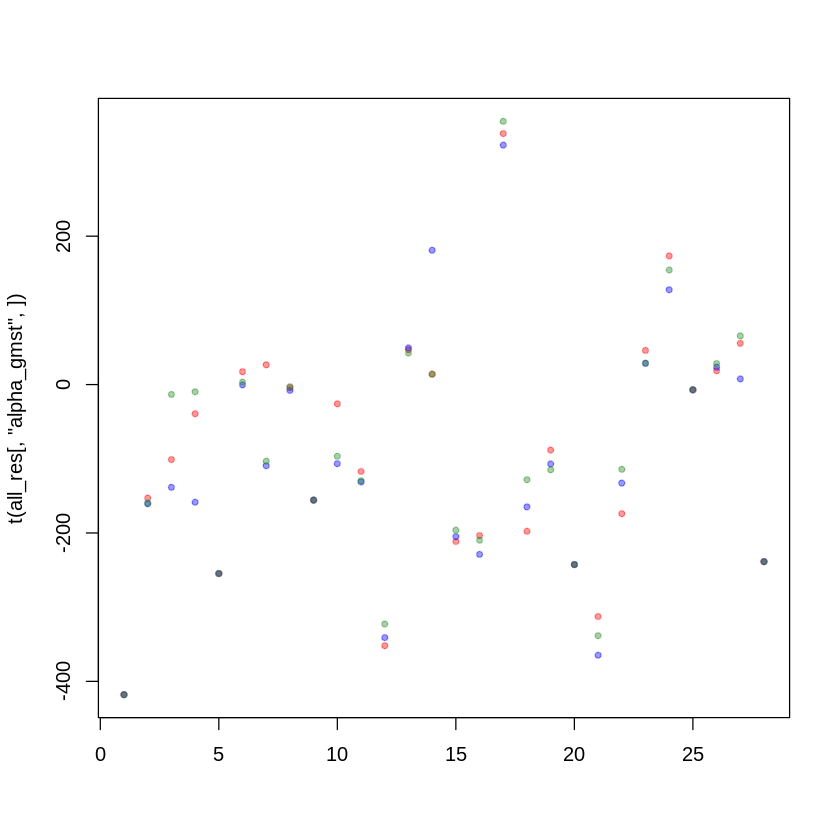

In [27]:
matplot(t(all_res[,"alpha_gmst",]), pch = 20, col = adjustcolor(c("red", "blue", "forestgreen"), 0.4))

## Trends in composites

In [39]:
# for each precip series, load the data, combine with the covariates & fit the model
models_rs <- sapply(list.files("ts", pattern = "pr-wetseason", full.names = T), function(fnm) {
    
    ts <- load_ts(fnm, col.names = c("year", "pr"))
    df <- merge(merge(gmst, nino), ts)
    
    fit_ns("norm", "fixeddisp", df, "pr", c("gmst", "nino"), lower = T)
    
}, simplify = F)
names(models_rs) <- gsub(".dat", "", sapply(strsplit(names(models_rs), "_"), "[", 3))

# specify factual & counterfactual covariates
cov_2023 <- data.frame(gmst = gmst$gmst[gmst$year == 2023], nino = nino$nino[nino$year == 2023])
cov_cf <- rbind("hist" = cov_2023 - c(1.2,0),
                "neut" = data.frame(gmst = cov_2023$gmst, nino = 0))

In [59]:
# about 4 mins to run 1000 samples
res_rs <- abind::abind(sapply(models_rs, boot_ci, cov_f = cov_2023, cov_cf = cov_cf, nsamp = 1000, simplify = F), along = 0)
res_rs["era5land","return_period",] <- NA

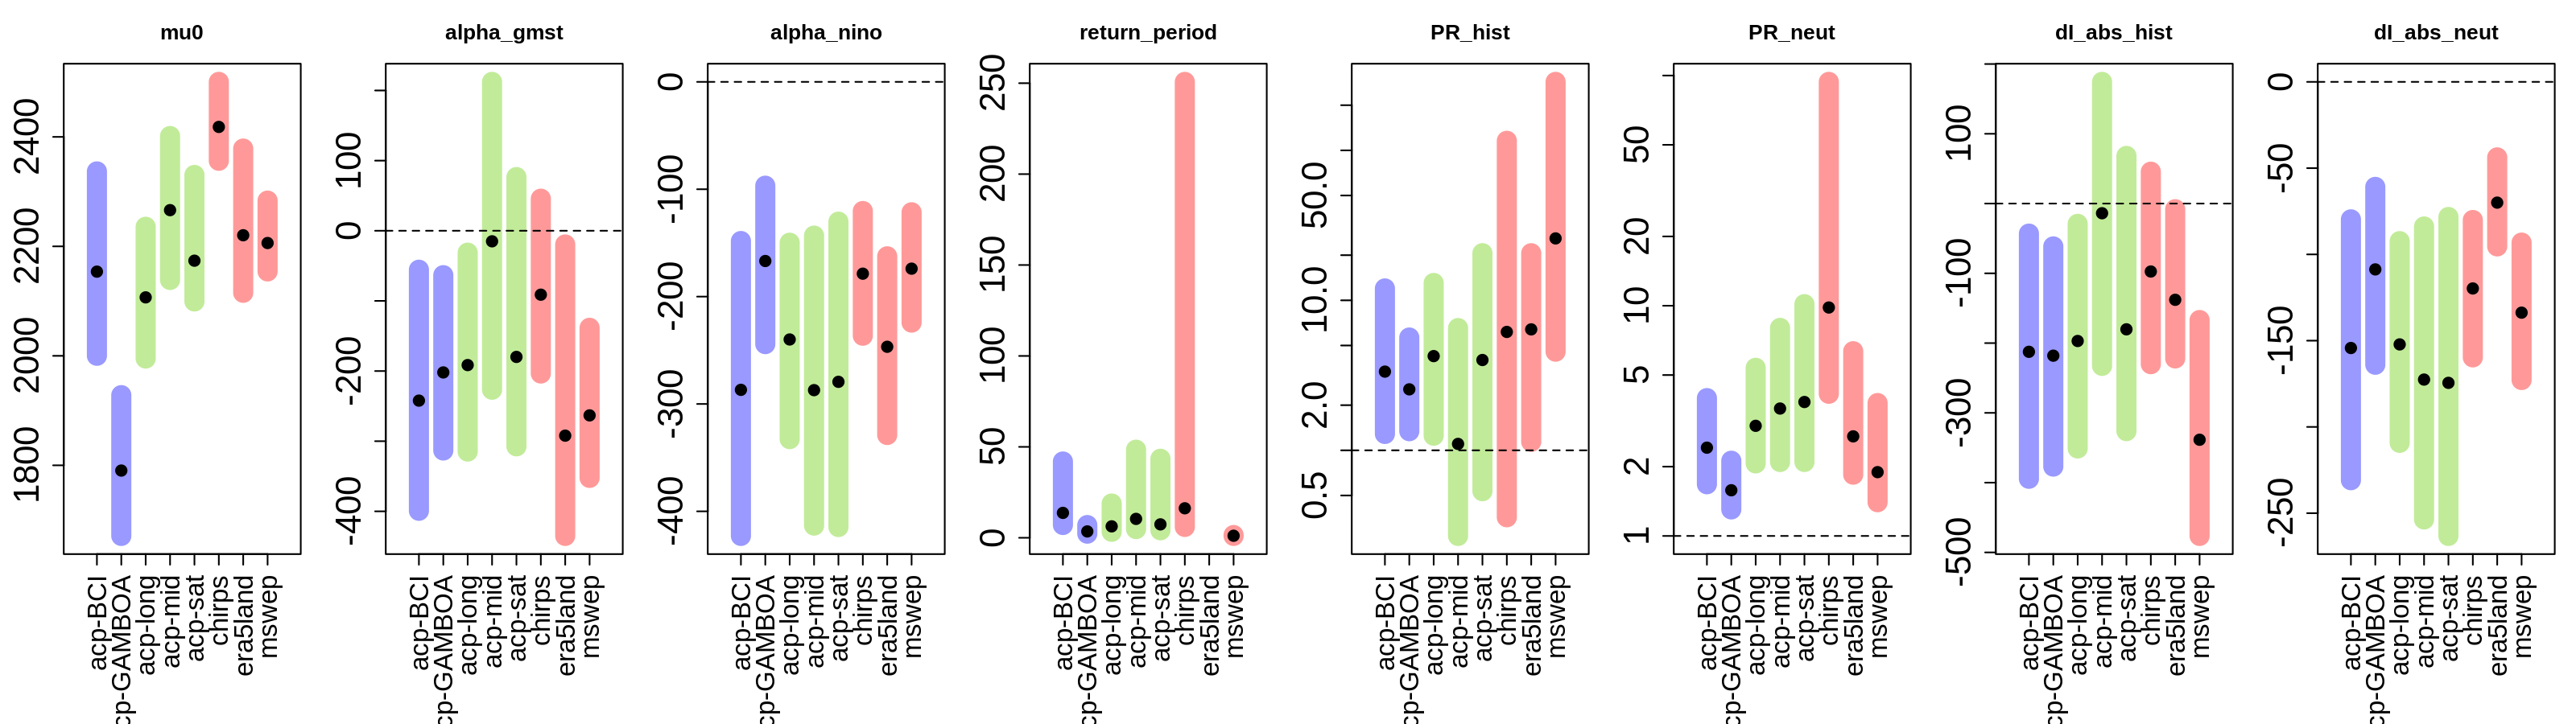

In [60]:
plot_pars <- c("mu0", "alpha_gmst", "alpha_nino", "return_period", "PR_hist", "PR_neut", "dI_abs_hist", "dI_abs_neut")
prep_window(c(1,4), h = 4.5)

png(paste0("fig/fitted-models_pr_parameters.png"), height = 480, width = 480*4); par(cex.main = 2.4); {
    par(mfrow = c(1,length(plot_pars)), mar = c(8,3,3,1))

    for (r in plot_pars) {
        res <- res_rs[,r,]
        ylim = range(res, na.rm = T)

        n <- nrow(res)
        h <- NA
        logxy = ""

        if(grepl("PR", r)) {
            logxy = "y"
            h = 1
        } else if(grepl("alpha", r) | grepl("dI", r)){
            h = 0
        }
        ylim = range(h, res, na.rm = T)

        plot(1, type = "n", ylim = ylim, xlim = c(0,n+1), main = r, xaxt = "n", xlab = "", ylab = "", cex.axis = 2, log = logxy)
        axis(1, at = 1:n, labels = rownames(res), las = 2, cex.axis = 1.5)
        segments(x0 = 1:n, y0 = res[,"2.5%"], y1 = res[,"97.5%"], lwd = 12, col = adjustcolor(c(rep("blue", 2), rep("chartreuse3", 3), rep("red", 3)), alpha = 0.4))
        points(1:n, res[,"est"], pch = 20, cex = 2)
        abline(h = h, lty = 2)
    }
}; dev.off()

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8


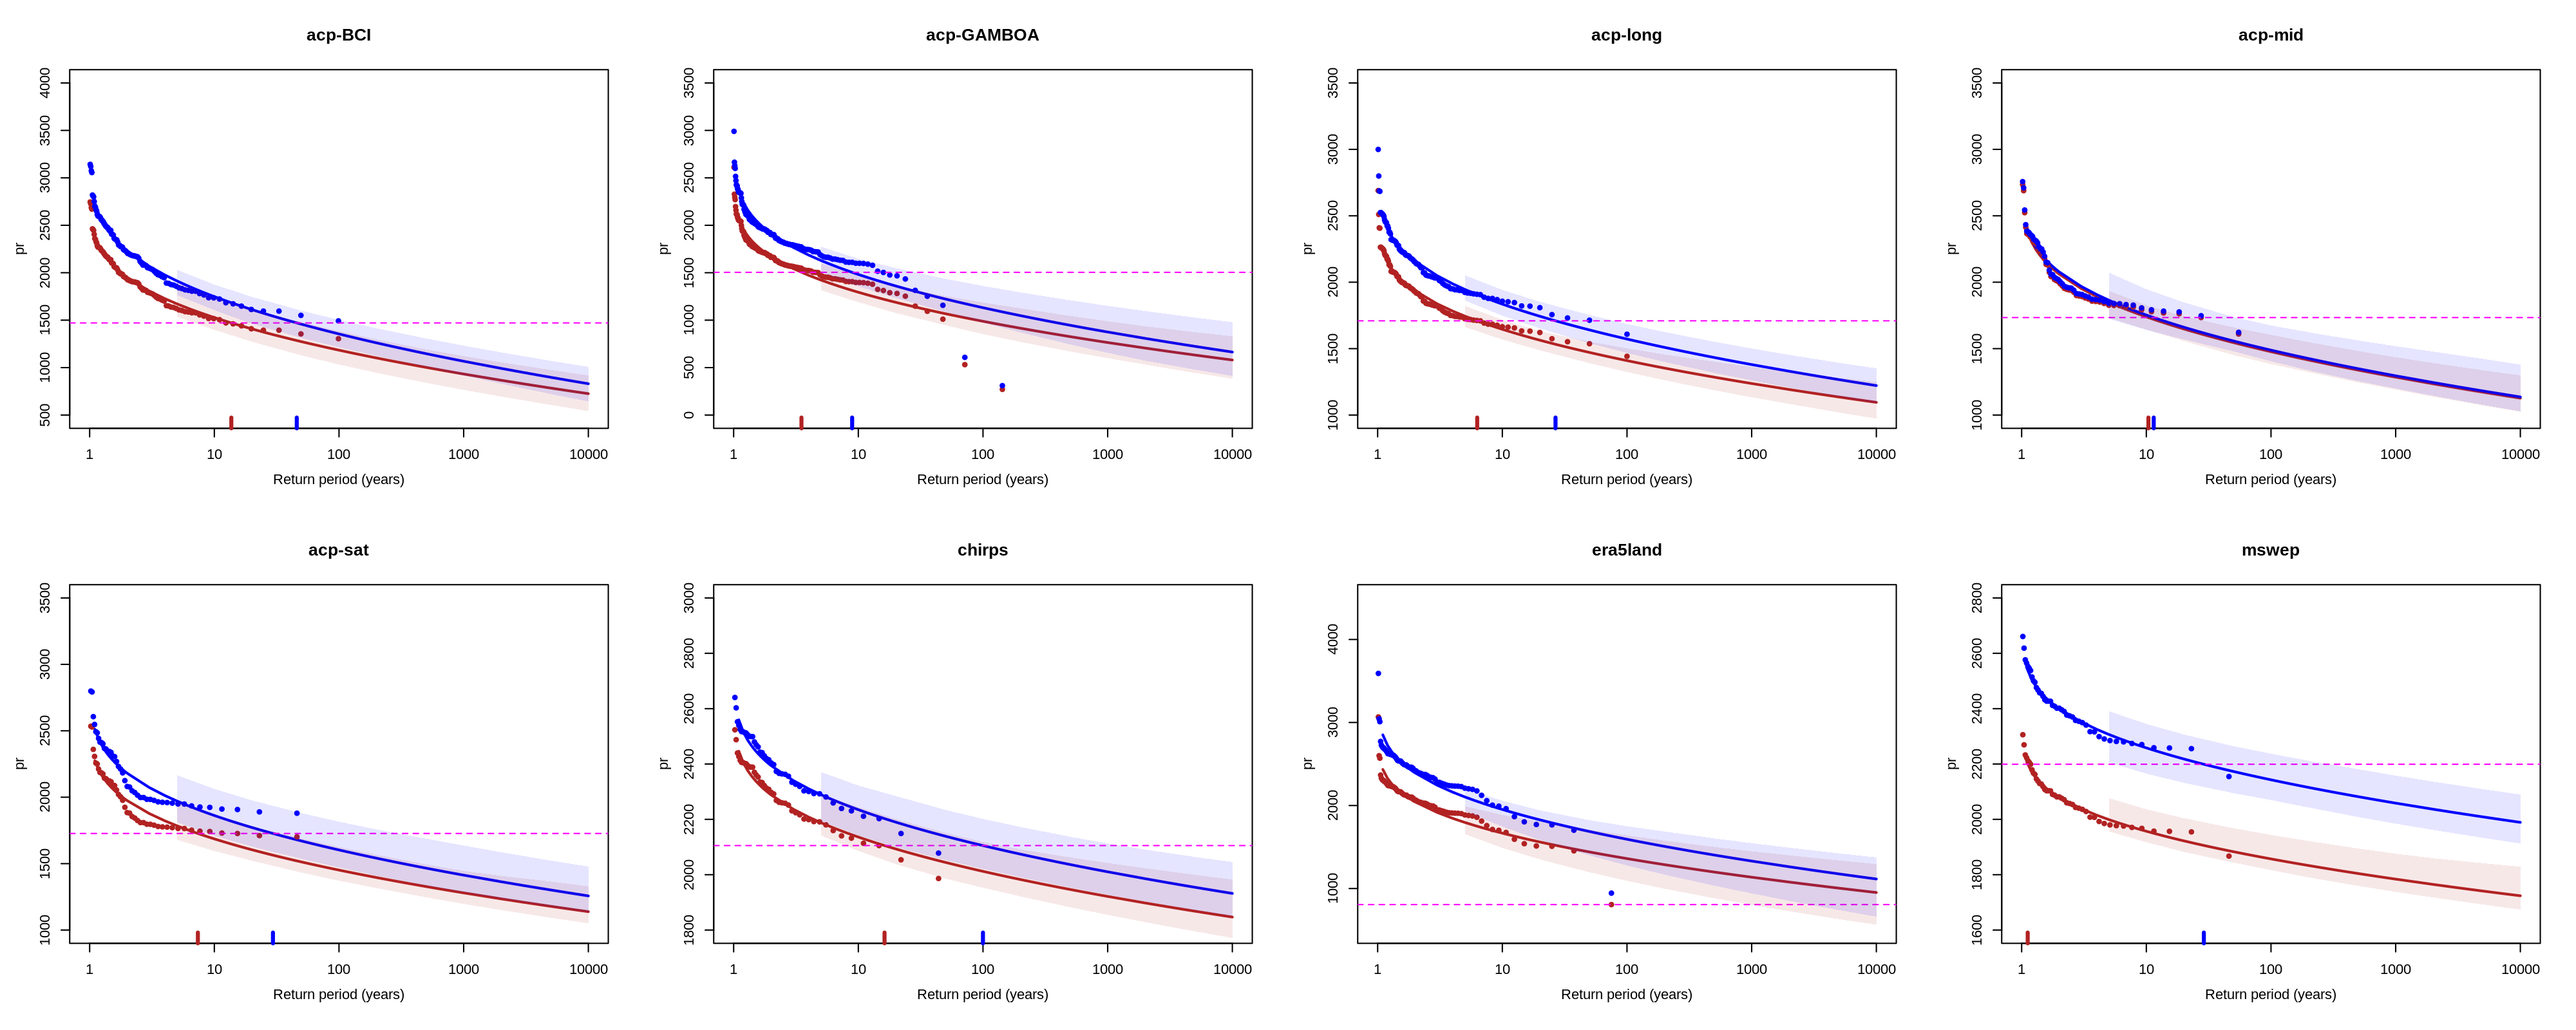

In [69]:
prep_window(c(2,4), h = 4, w = 5)

for (i in 1:length(models_rs)) {
    mdl <- models_rs[[i]]
    plot_returnlevels(mdl, cov_f = cov_2023, cov_cf = cov_cf["hist",,drop=F], nsamp = 50, main = names(models_rs)[[i]])
}

In [90]:
zz <- load_ts("ts/panama_pr-wetseason_acp-GAMBOA.dat", col.names = c("year", "pr"))
zz$logpr <- log(zz$pr)

nino <- load_ts("ts/panama_nino-rs.dat", col.names = c("year", "nino"))

gmst <- read.table("ts/gmst.dat", col.names = c("year", "gmst"))
gmst$gmst <- gmst$gmst - gmst$gmst[gmst$year == 2023]

zz <- merge(merge(zz, nino), gmst)

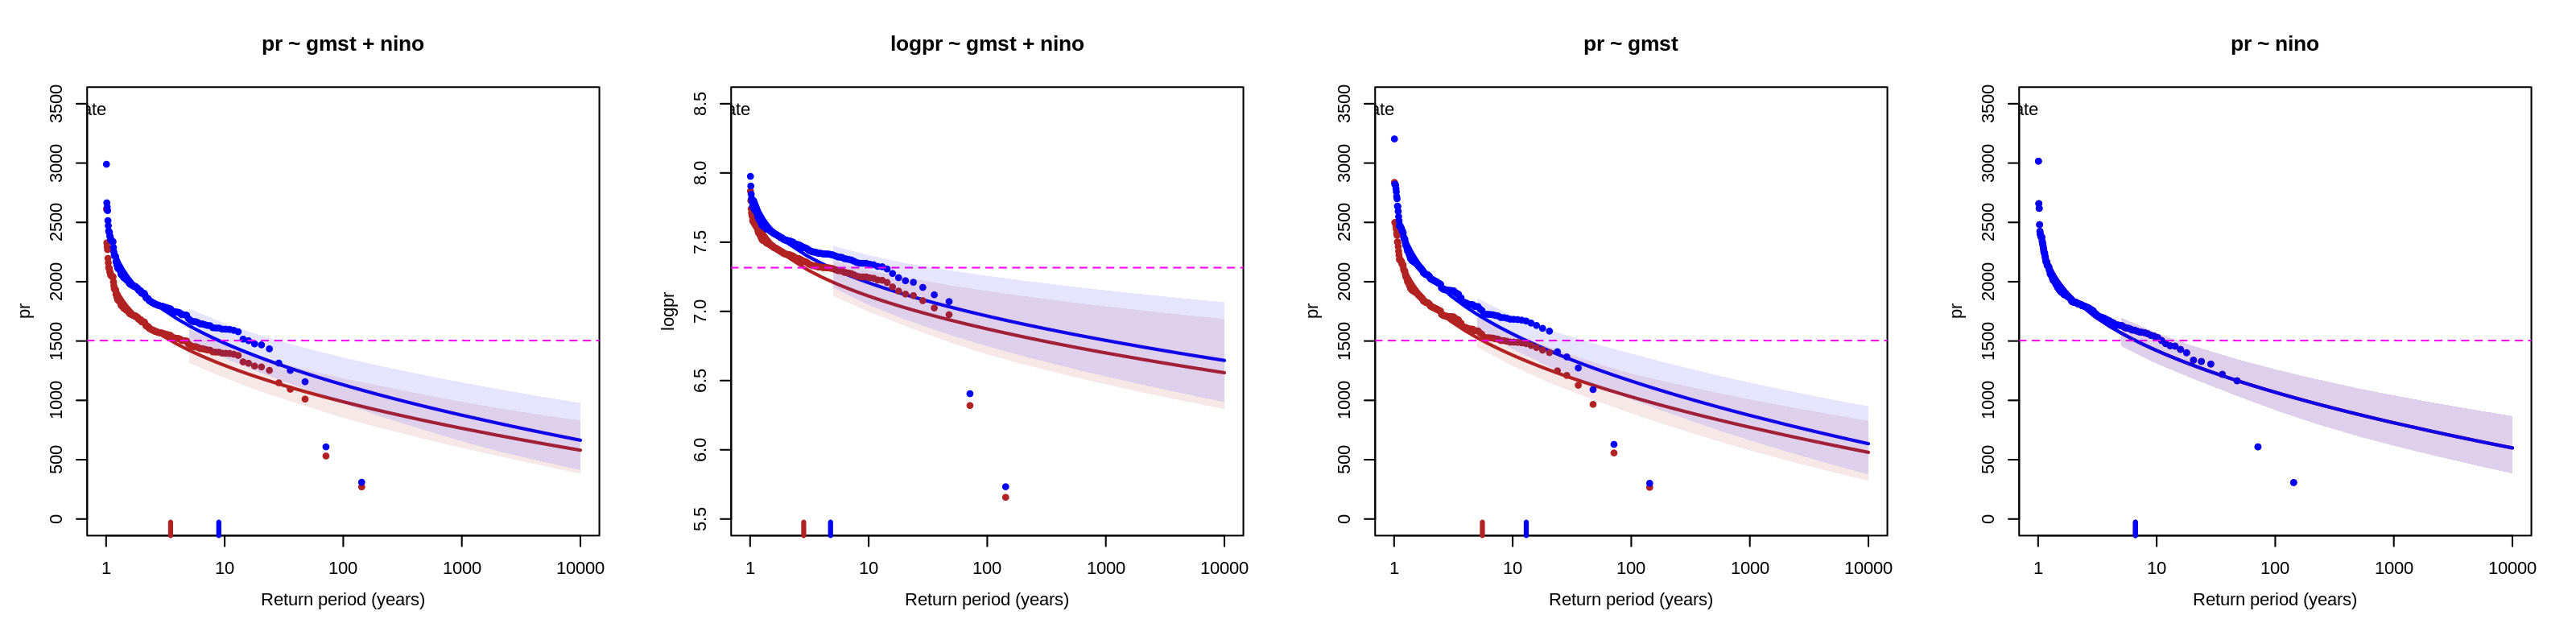

In [94]:
zmodels <- list("pr ~ gmst + nino" =  fit_ns("norm", "fixeddisp", zz, "pr", c("gmst", "nino"), lower = T),
                "logpr ~ gmst + nino" =  fit_ns("norm", "fixeddisp", zz, "logpr", c("gmst", "nino"), lower = T),
                "pr ~ gmst" =  fit_ns("norm", "fixeddisp", zz, "pr", c("gmst"), lower = T),
                "pr ~ nino" =  fit_ns("norm", "fixeddisp", zz, "pr", c("nino"), lower = T))

prep_window(c(1,4))
for (i in 1:4) {
    plot_returnlevels(zmodels[[i]], cov_f = cov_2023, cov_cf = cov_cf["hist",,drop=F], nsamp = 50, main = names(zmodels)[i])
}